In [4]:
import wandb

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch

from dataset import get_learn_data, save_datasets
from topo_image import TopoImage, HeightFiltration
from models import BasicAutoEncoder
from train import fit
from metrics import evaluate_model
from utils import set_random_seed

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!wandb login

wandb: Currently logged in as: volodin-daniil. Use `wandb login --relogin` to force relogin


In [3]:
RANDOM_SEED = 42

# CRACK500

### Generate Data

In [5]:
set_random_seed(RANDOM_SEED)

noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=0.6),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=0.6)
])

train_loader, val_loader, test_loader = get_learn_data("data/CrackTree/CRACK500/original_images", noise_transformations=noise_transformations, 
                                                       patch_mode="resize", patch_size=(40, 40), img_size=(400, 400), batch_size=32, filter_empty=True)

save_datasets("data/CrackTree/CRACK500/", [train_loader, val_loader, test_loader], ["train", "val", "test"])


100%|██████████| 18/18 [00:02<00:00,  8.38it/s]


### Load Data

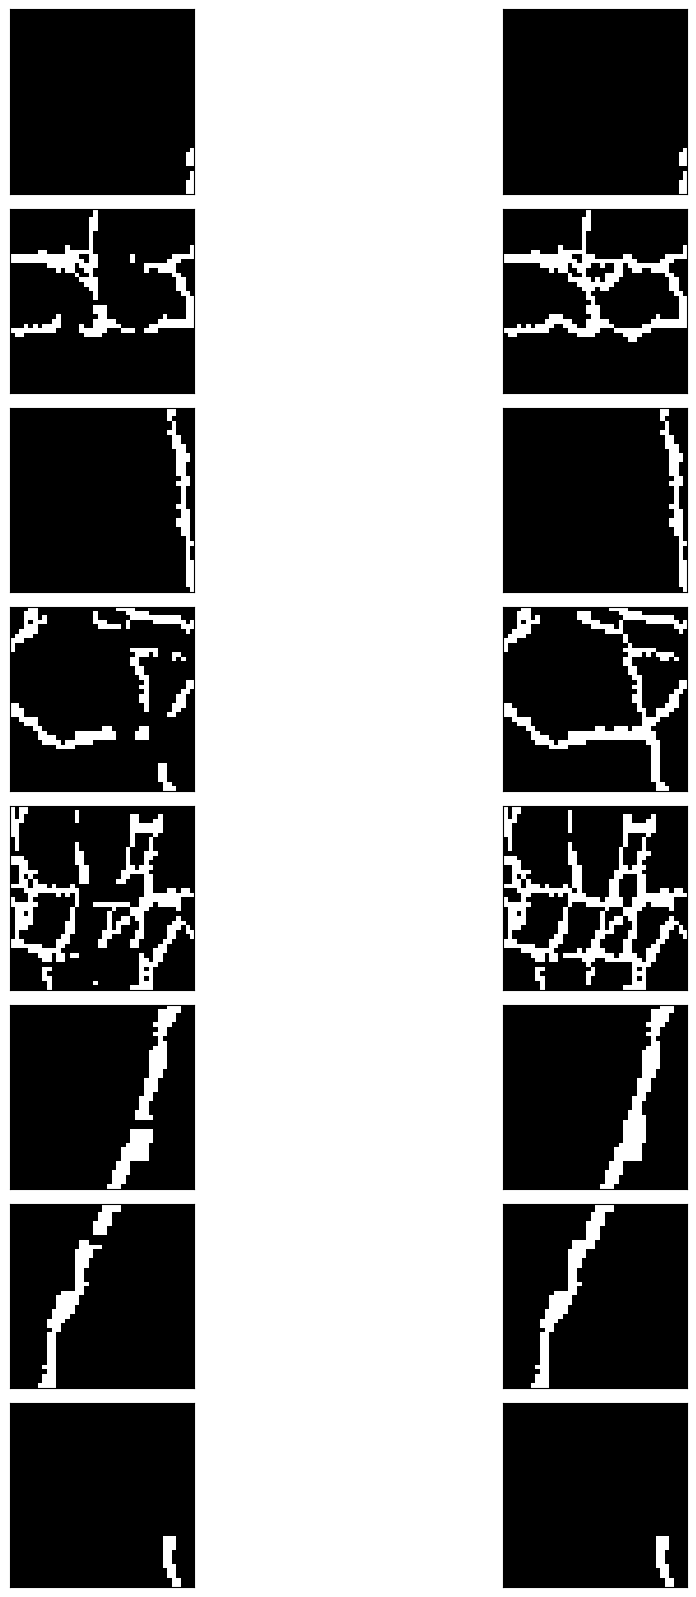

In [5]:
noise_transformations = A.Compose([
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=1),
    A.CoarseDropout(min_holes=1, max_holes=1, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=1),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=2, max_height=4, min_width=10, max_width=20, fill_value=0, p=0.6),
    A.CoarseDropout(min_holes=2, max_holes=4, min_height=10, max_height=20, min_width=2, max_width=4, fill_value=0, p=0.6)
])

train_loader, val_loader, test_loader = get_learn_data("data/CrackTree/CRACK500", "train_gt", "val_gt", "test_gt", 
                                                       None, "val", "test", noise_transformations=noise_transformations, 
                                                       patch_mode="keep", img_size=(40, 40), batch_size=32)

fig = plt.figure(figsize=(10, 32))
for idx in np.arange(8):
    noised_image, gt_image, img_name, patch_num = val_loader.dataset[idx + 32]

    # noised input
    ax1 = fig.add_subplot(16, 2, 2 * idx + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_image), cmap='grey')

    # gt image
    ax3 = fig.add_subplot(16, 2, 2 * idx + 2, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_image), cmap='grey')

    fig.tight_layout()
plt.show()

### Betti Number Error Example

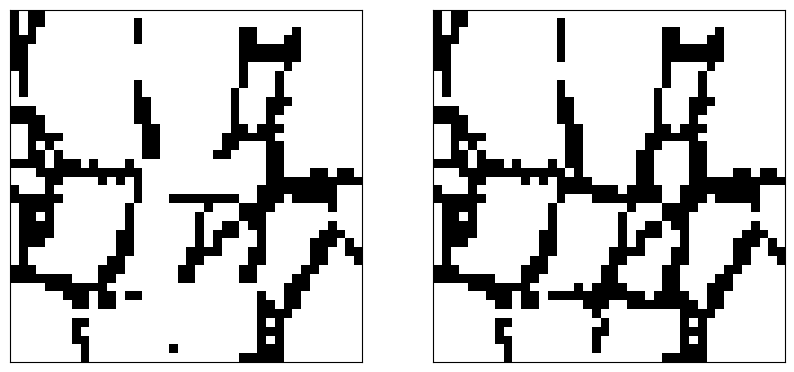

In [7]:
gt_img =  val_loader.dataset[36][1]
noised_img =  val_loader.dataset[36][0]

fig = plt.figure(figsize=(10, 32))

ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(1 - noised_img), cmap='grey')

ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(np.squeeze(1 - gt_img), cmap='grey')

plt.show()

In [8]:
TopoImage(gt_img).betti_numbers()

[4, 11, 0]

In [9]:
TopoImage(noised_img).betti_numbers()

[9, 8, 0]

### Only BCELoss

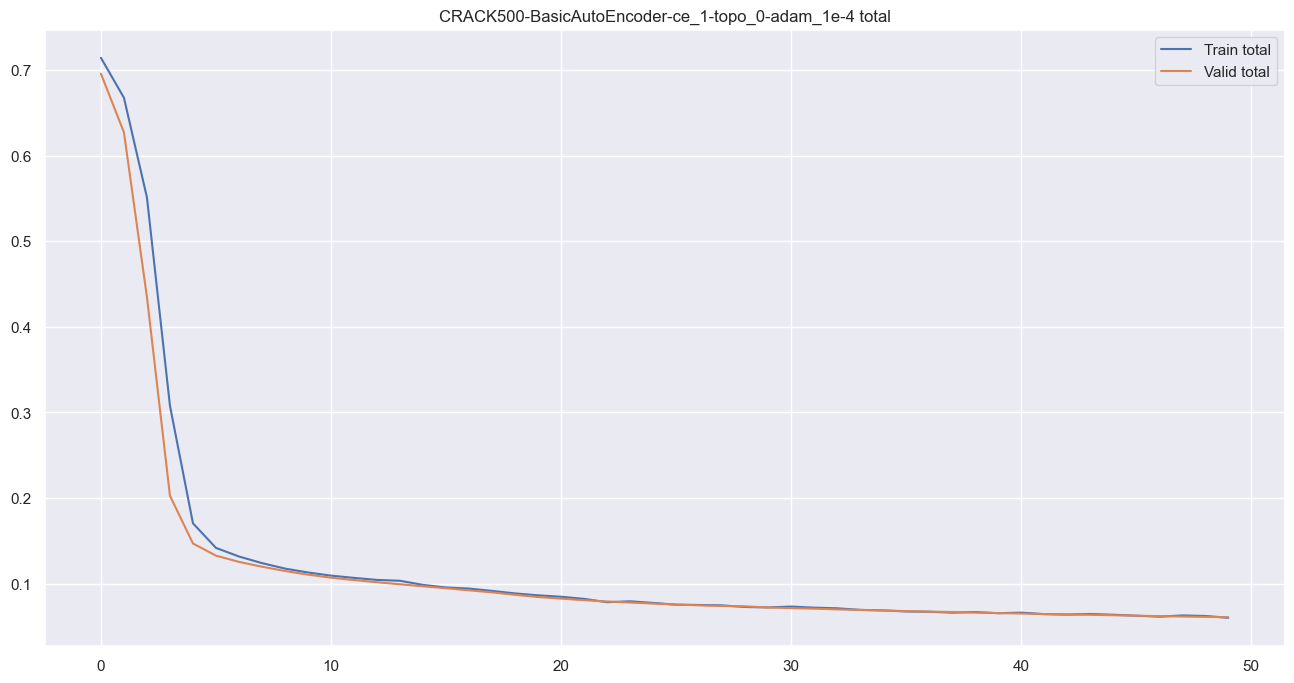

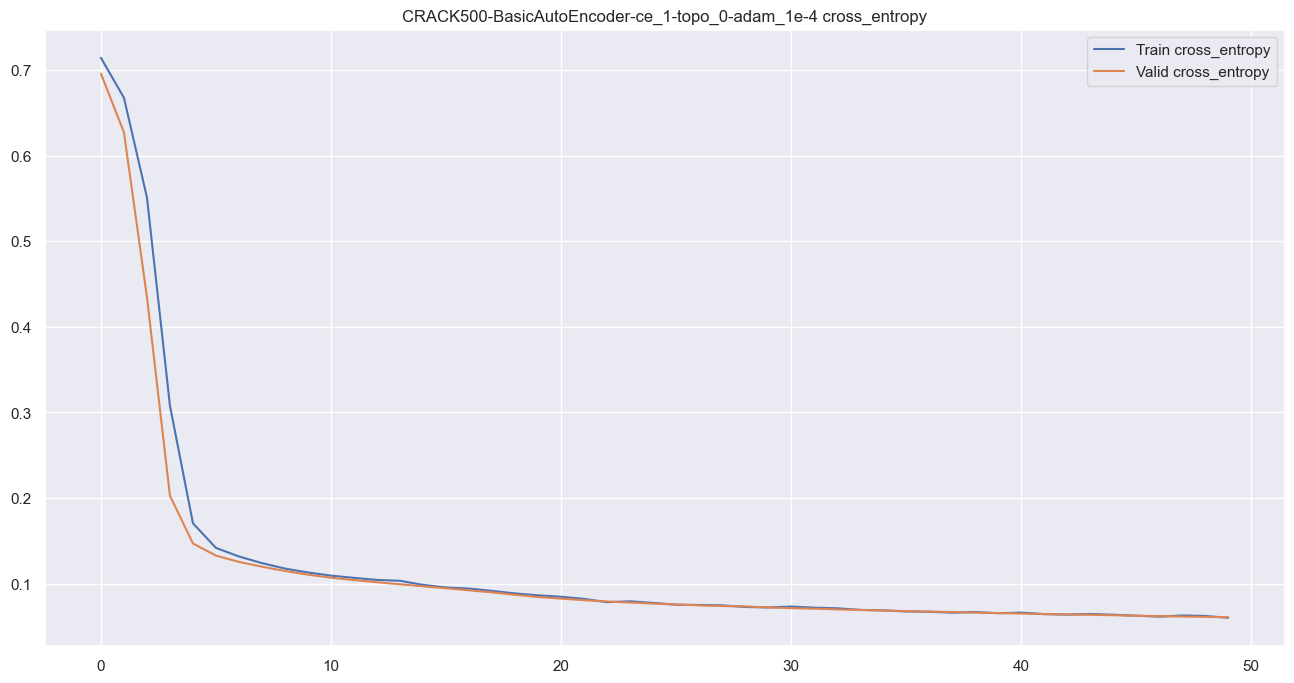

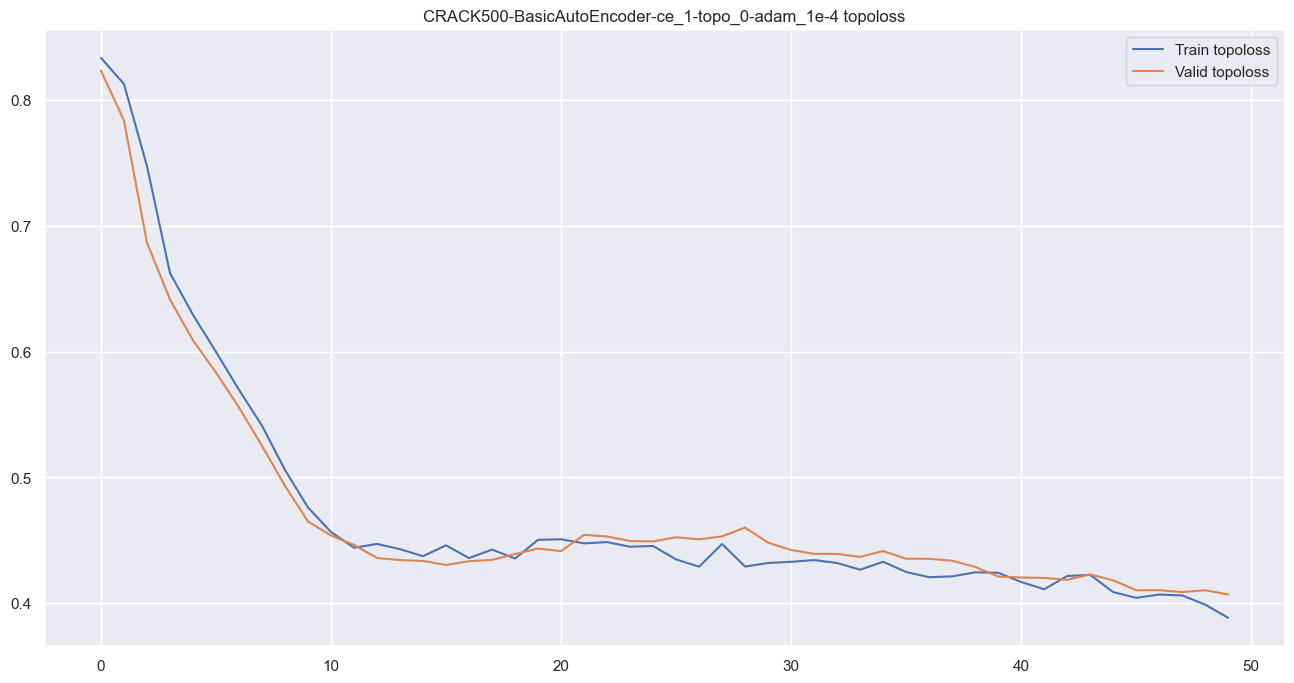

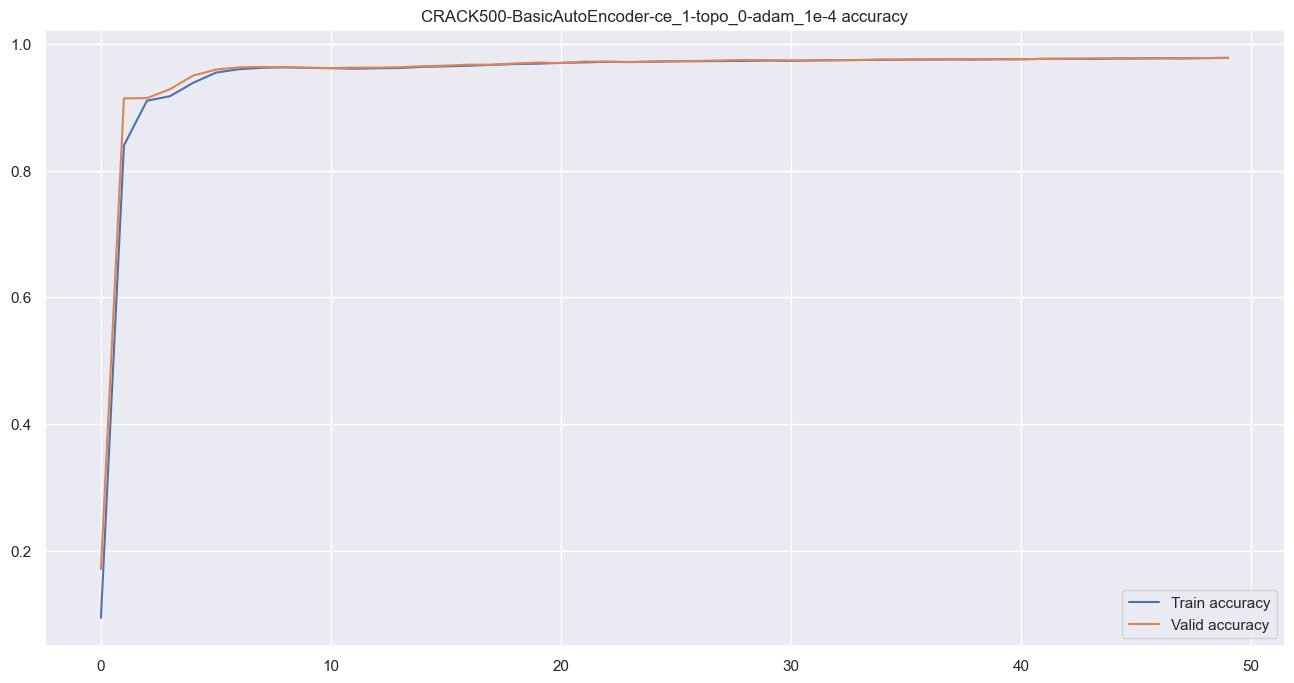

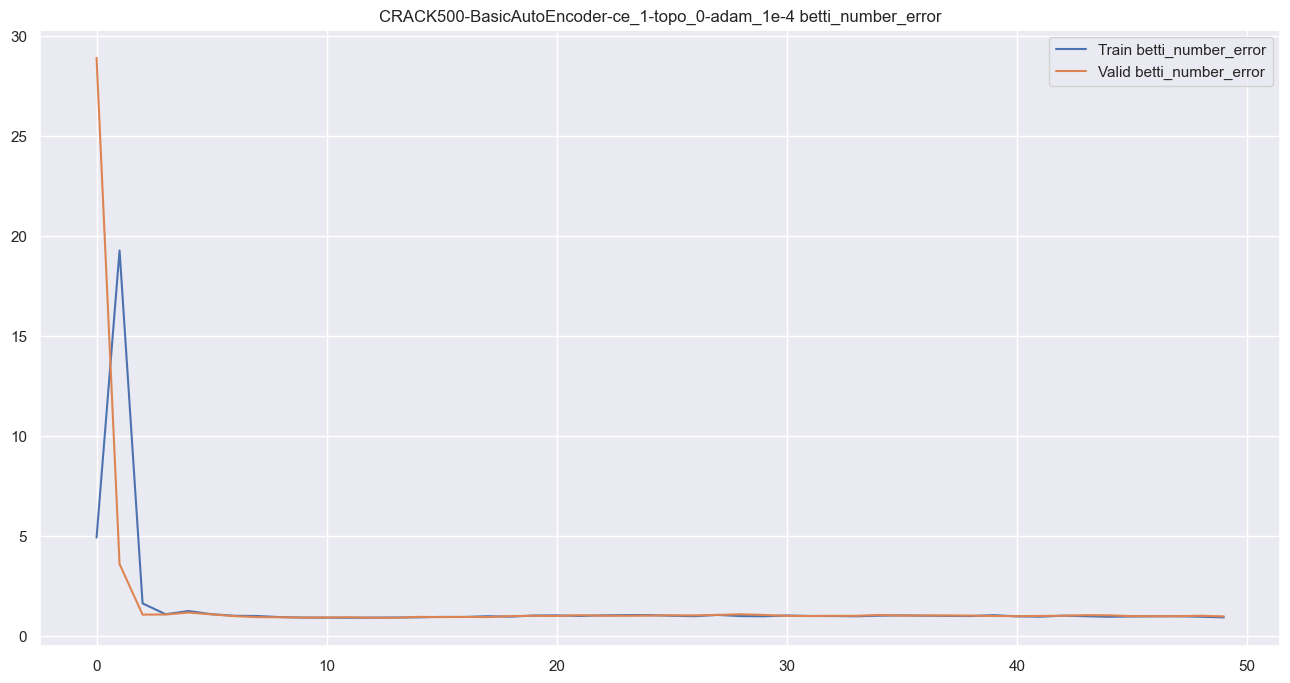

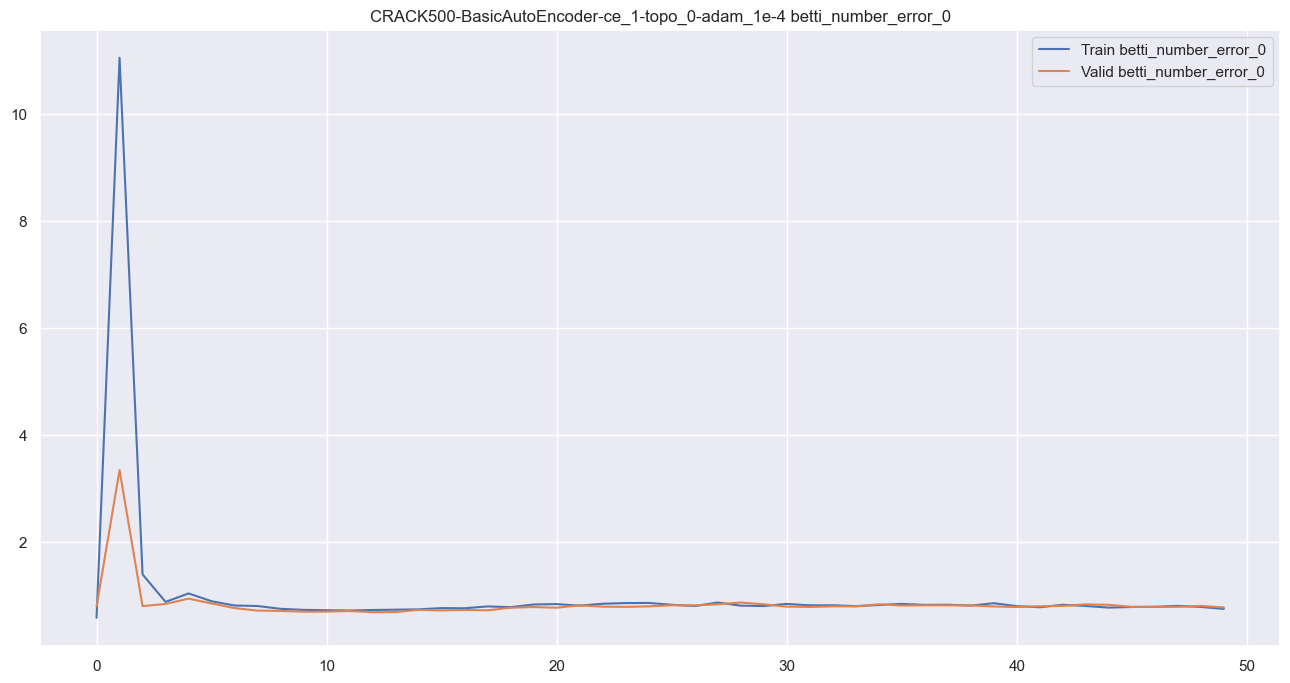

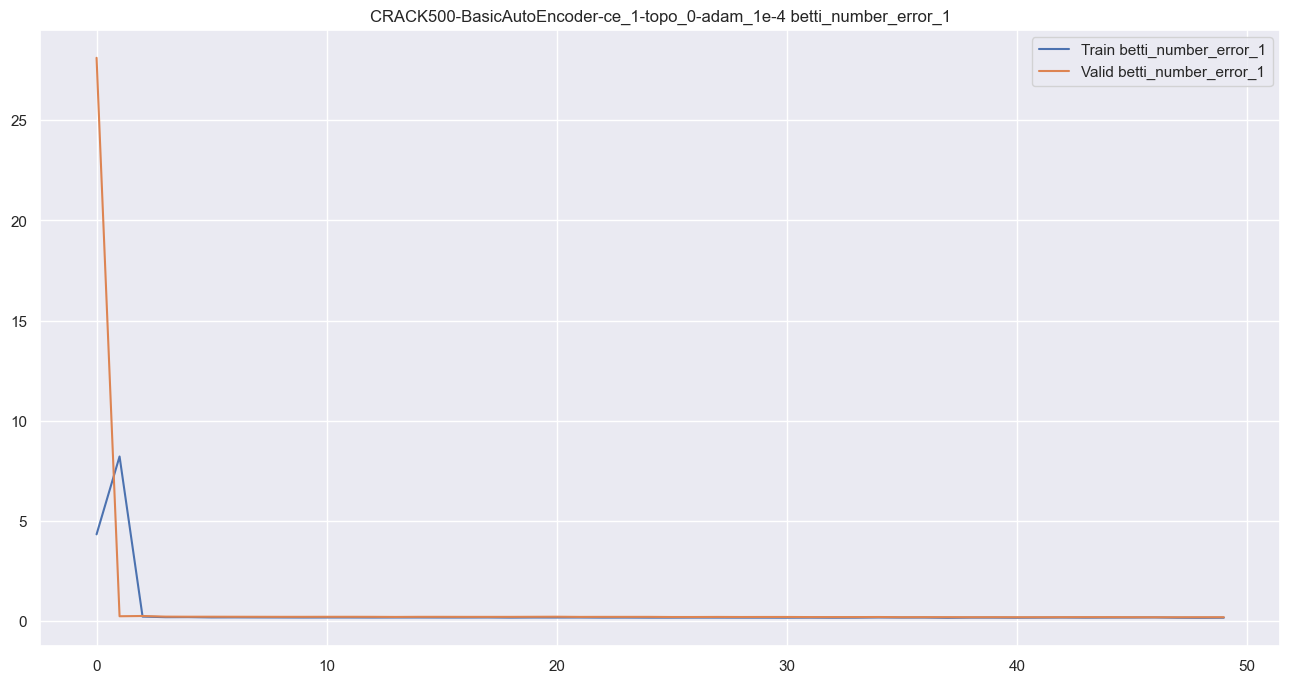

Epoch 49
 train loss: {'total': 0.05991916981708282, 'cross_entropy': 0.05991916981708282, 'topoloss': 0.38844538381106164}, train metrics: {'accuracy': 0.9783508400714602, 'betti_number_error': 0.9087624209575429, 'betti_number_error_0': 0.7389340560072267, 'betti_number_error_1': 0.16982836495031617}
 val loss: {'total': 0.060613221760037576, 'cross_entropy': 0.060613221760037576, 'topoloss': 0.4070227519081902}, val metrics: {'accuracy': 0.9781069160585593, 'betti_number_error': 0.9602169981916817, 'betti_number_error_0': 0.7667269439421338, 'betti_number_error_1': 0.19349005424954793}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [10]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

In [11]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce.pt")

100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


{'accuracy': 0.9766798363695937, 'betti_number_error': 1.092057761732852, 'betti_number_error_0': 0.855595667870036, 'betti_number_error_1': 0.2364620938628159}


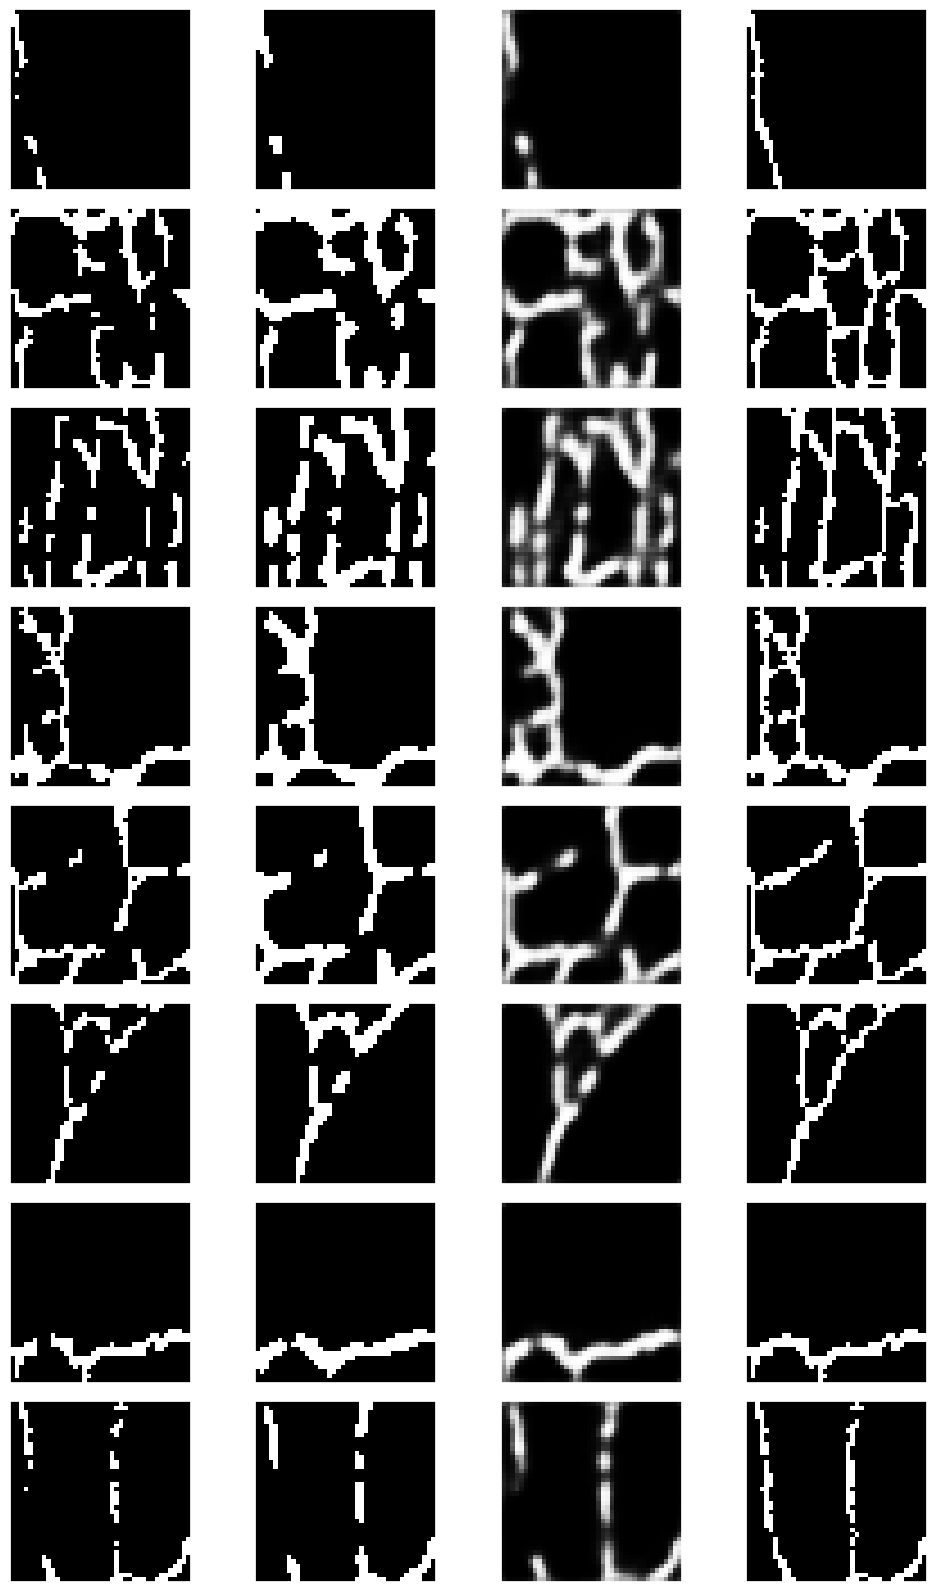

In [12]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda = 0.05$

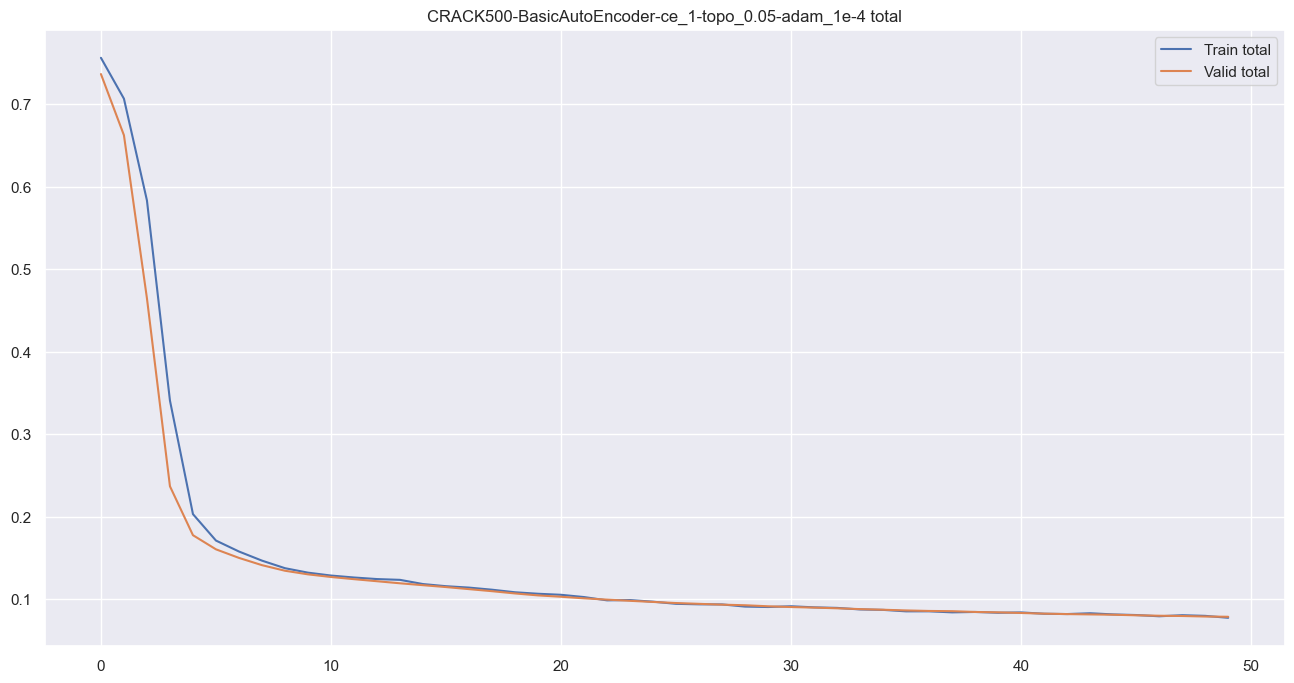

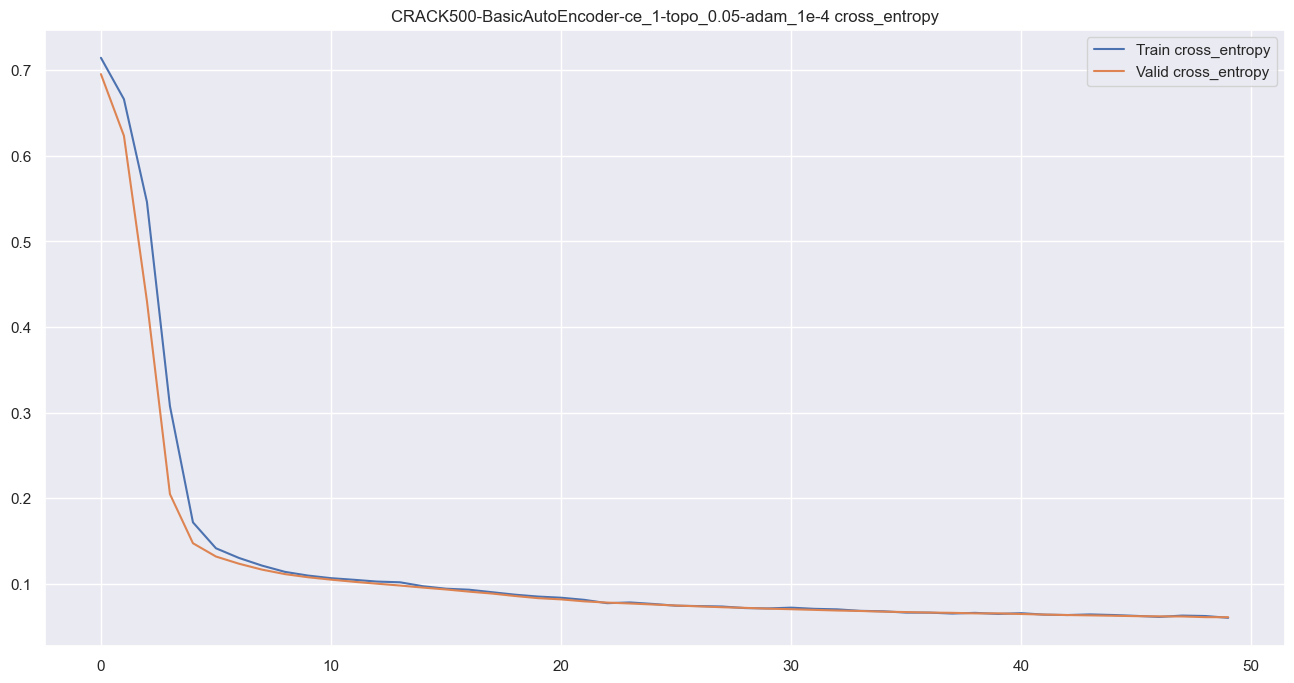

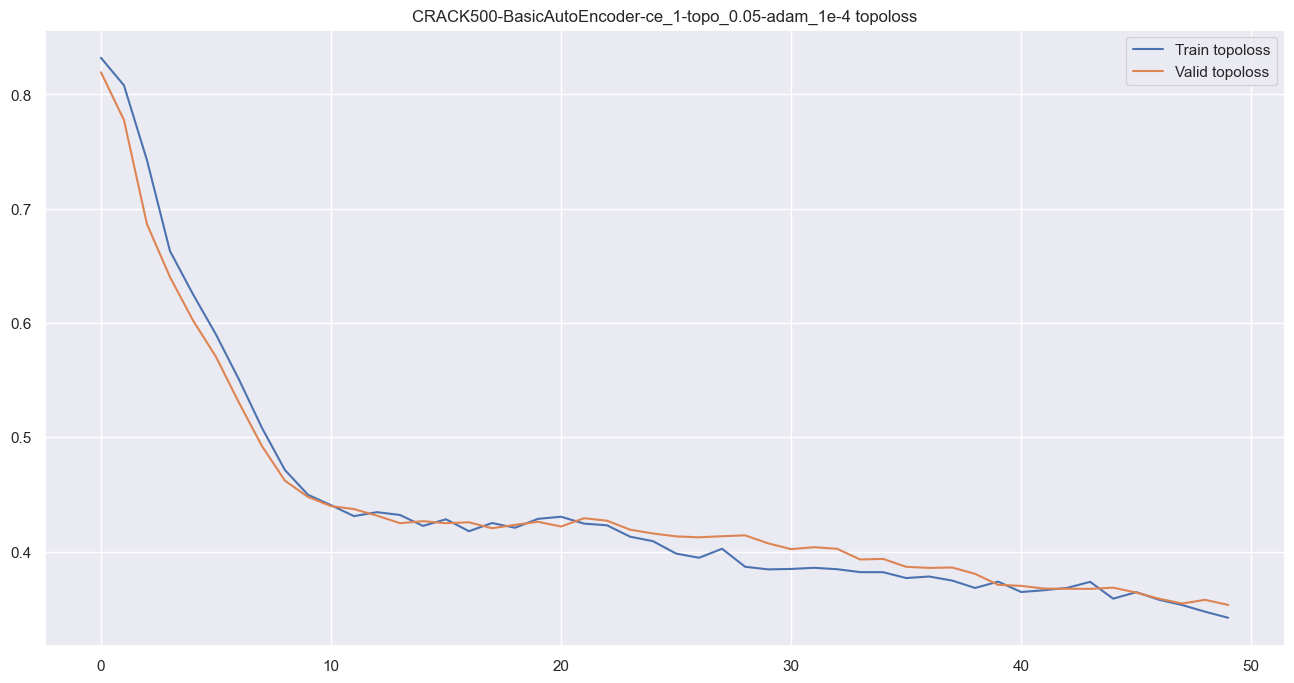

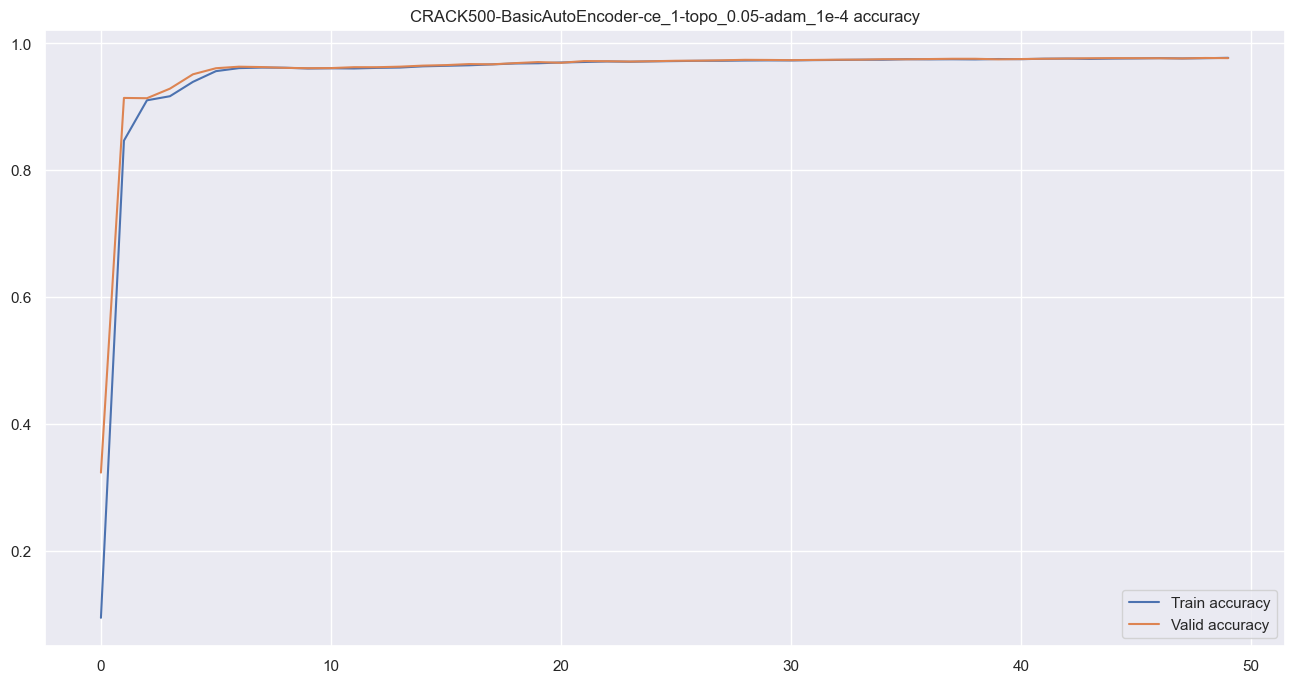

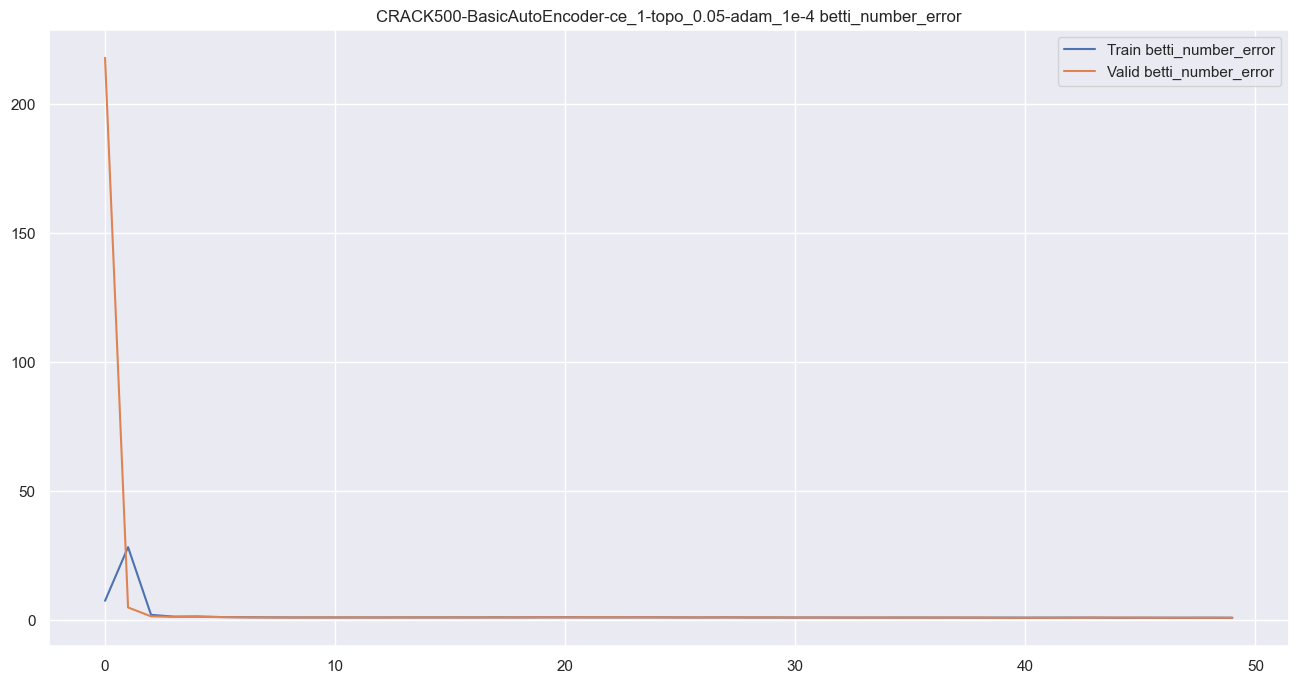

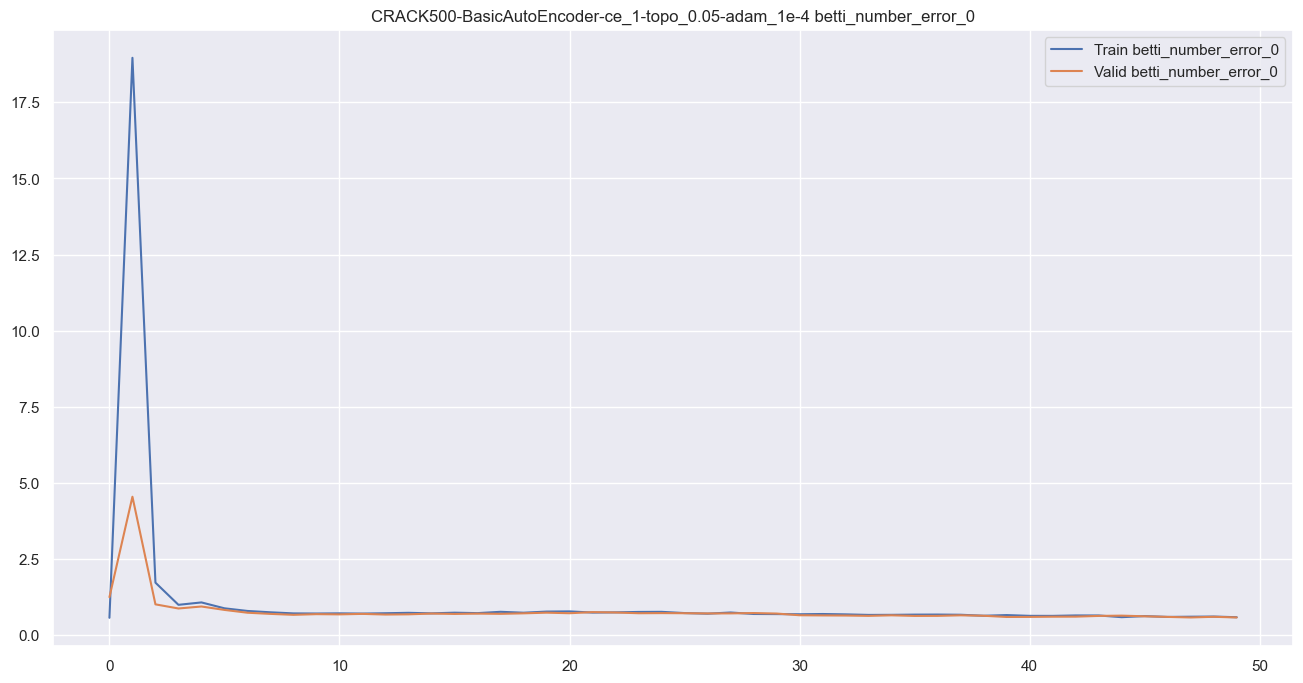

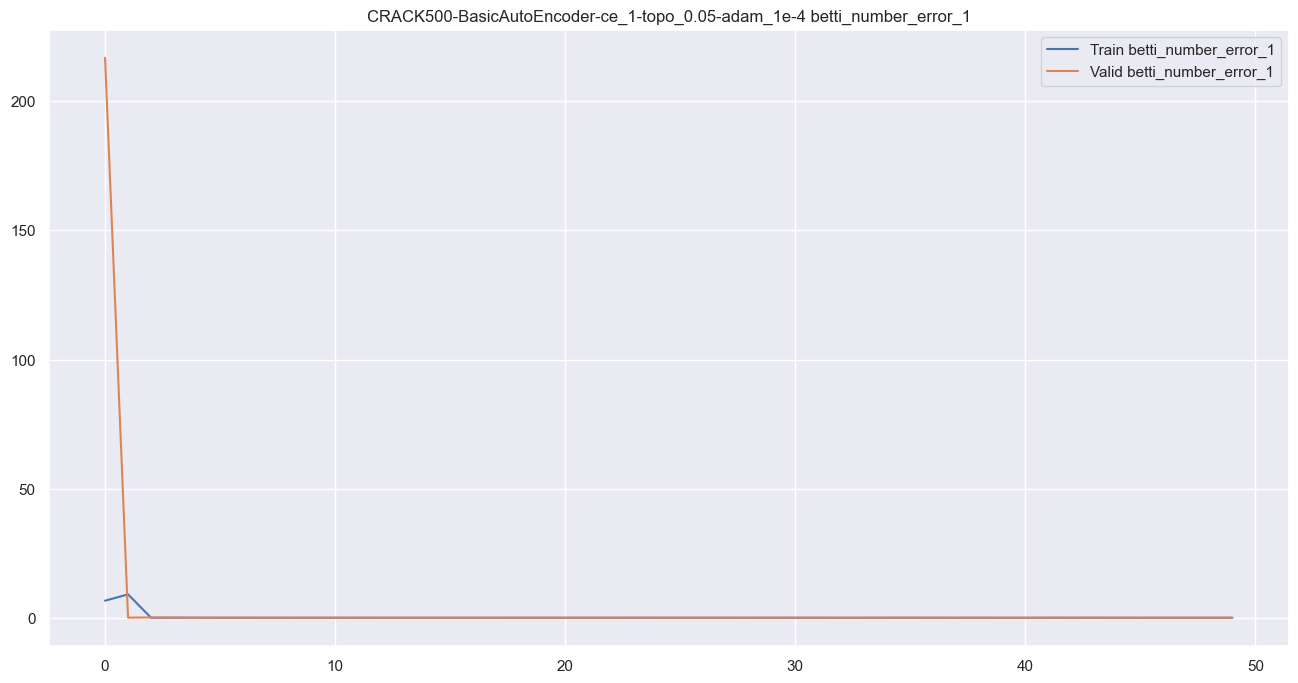

Epoch 49
 train loss: {'total': 0.07738925415649, 'cross_entropy': 0.060280862647128085, 'topoloss': 0.34216783147948004}, train metrics: {'accuracy': 0.9773492528817195, 'betti_number_error': 0.7687443541102078, 'betti_number_error_0': 0.5934959349593496, 'betti_number_error_1': 0.17524841915085818}
 val loss: {'total': 0.07864180255755378, 'cross_entropy': 0.06097035910294241, 'topoloss': 0.3534288837508741}, val metrics: {'accuracy': 0.9768297857660497, 'betti_number_error': 0.8047016274864376, 'betti_number_error_0': 0.5858951175406871, 'betti_number_error_1': 0.21880650994575046}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [20]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.05,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.05-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=True, save_checkpoints=False, save_path="", log_wandb=True)

In [21]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_5e-2.pt")

100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


{'accuracy': 0.9750699411660756, 'betti_number_error': 0.8249097472924187, 'betti_number_error_0': 0.5938628158844765, 'betti_number_error_1': 0.23104693140794225}


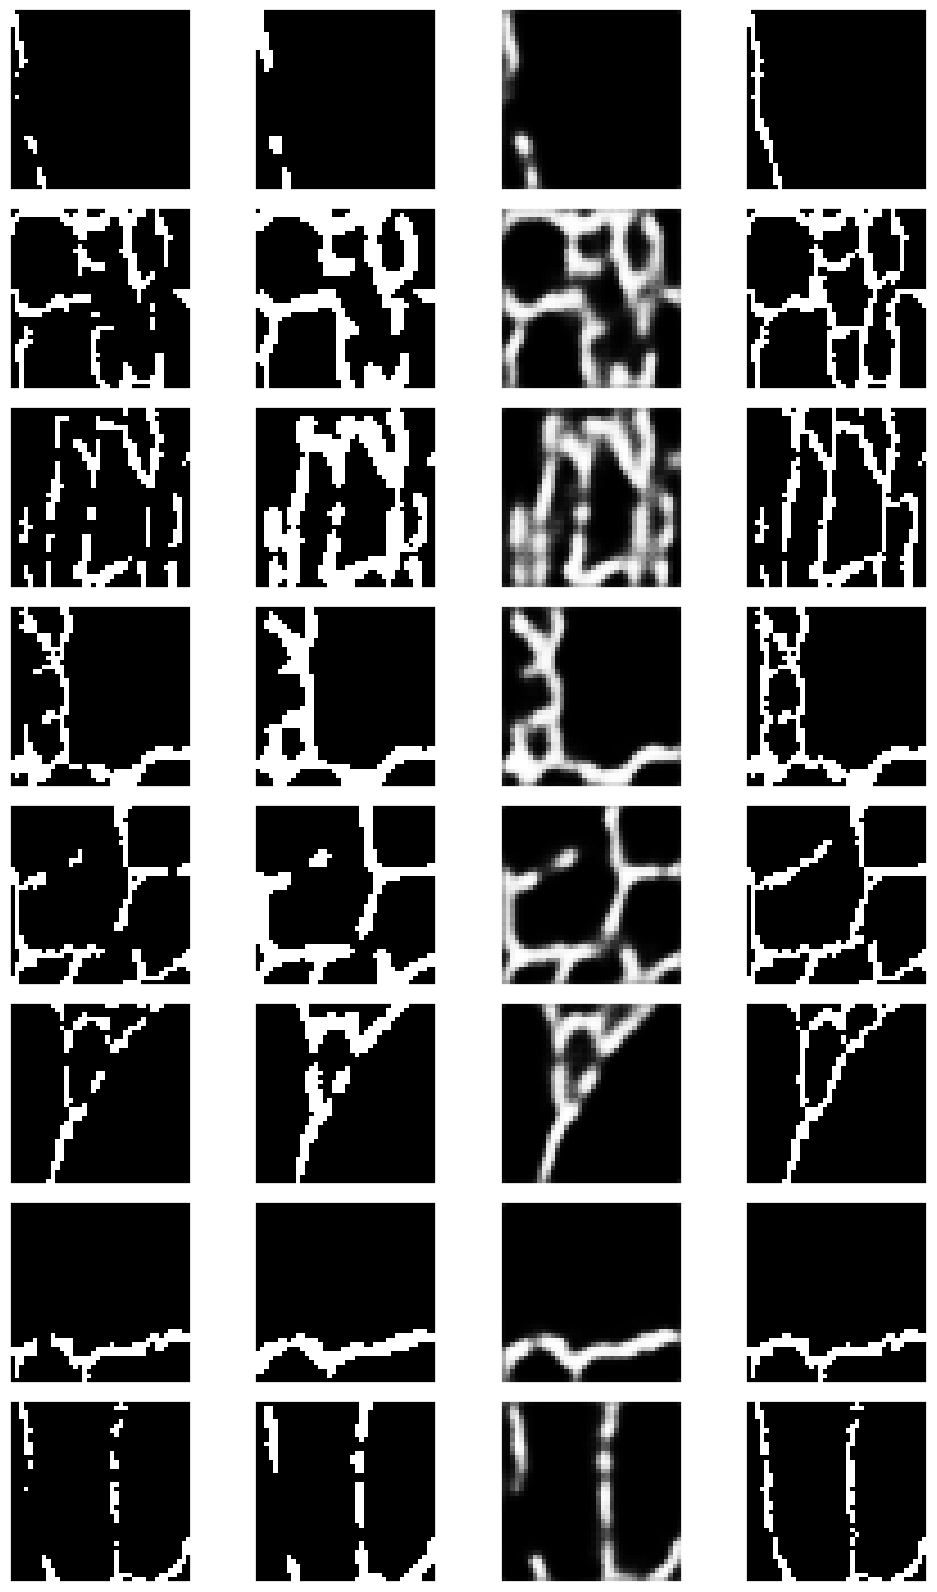

In [22]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_5e-2.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda = 0.1$

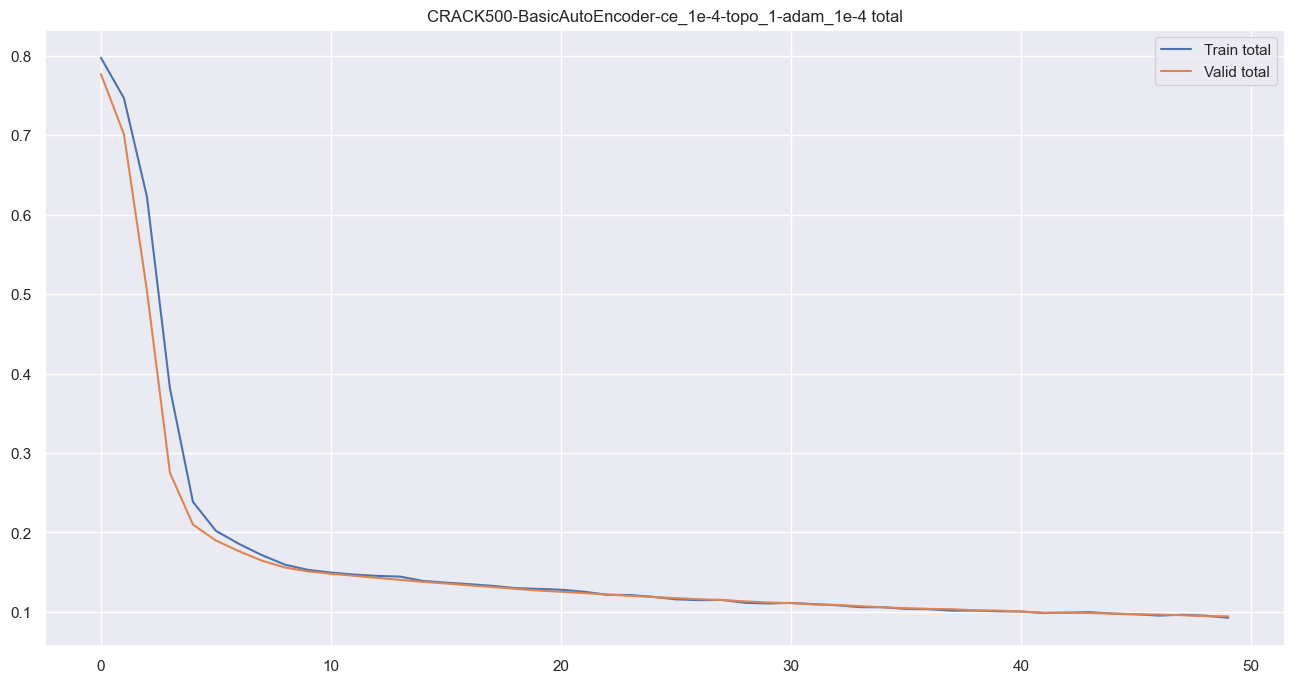

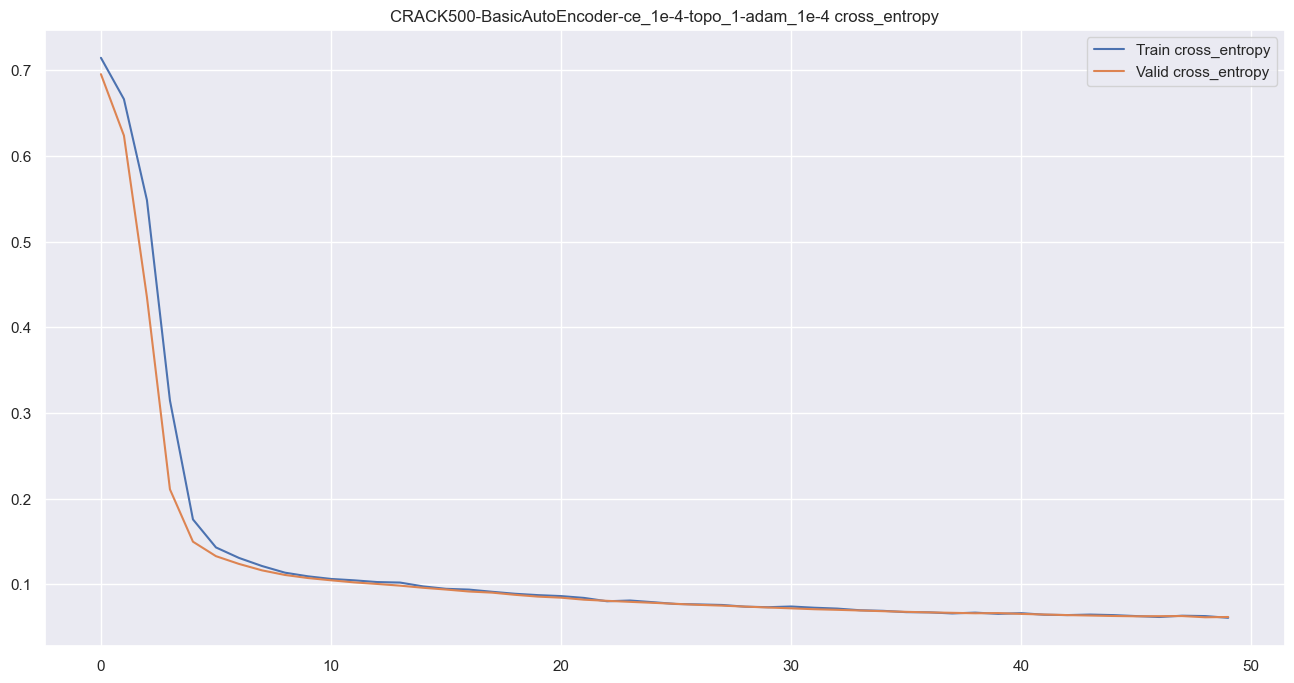

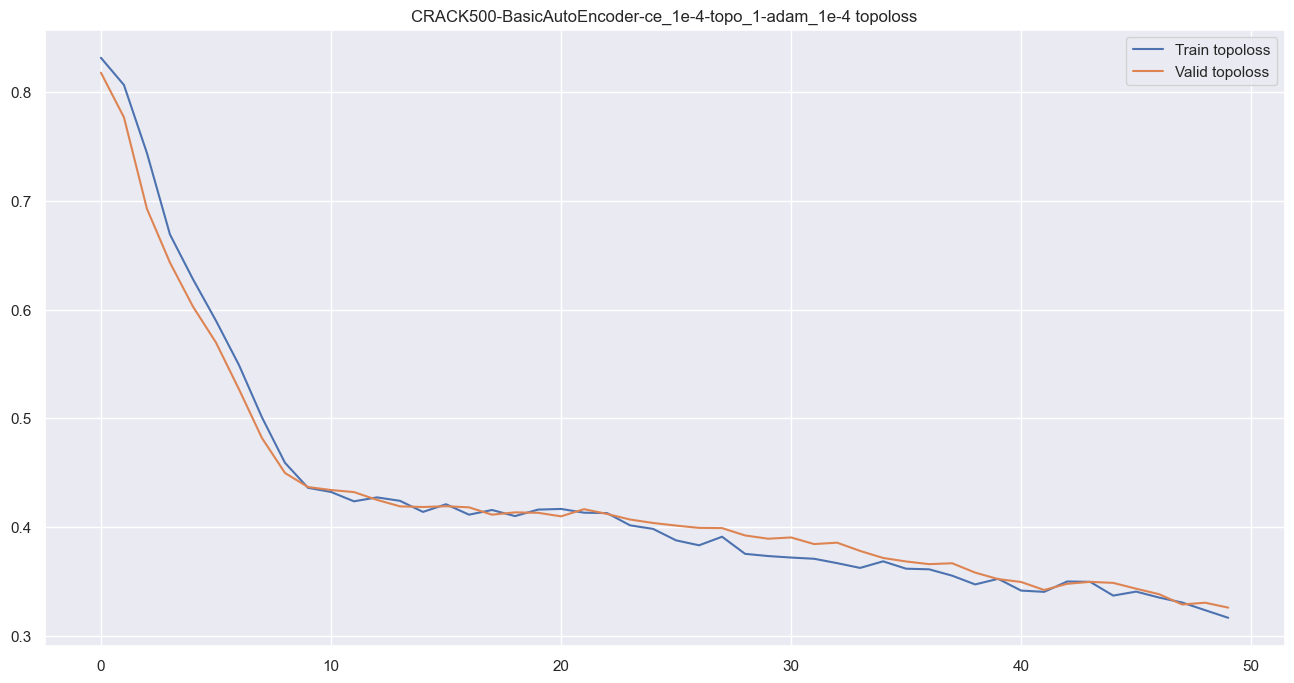

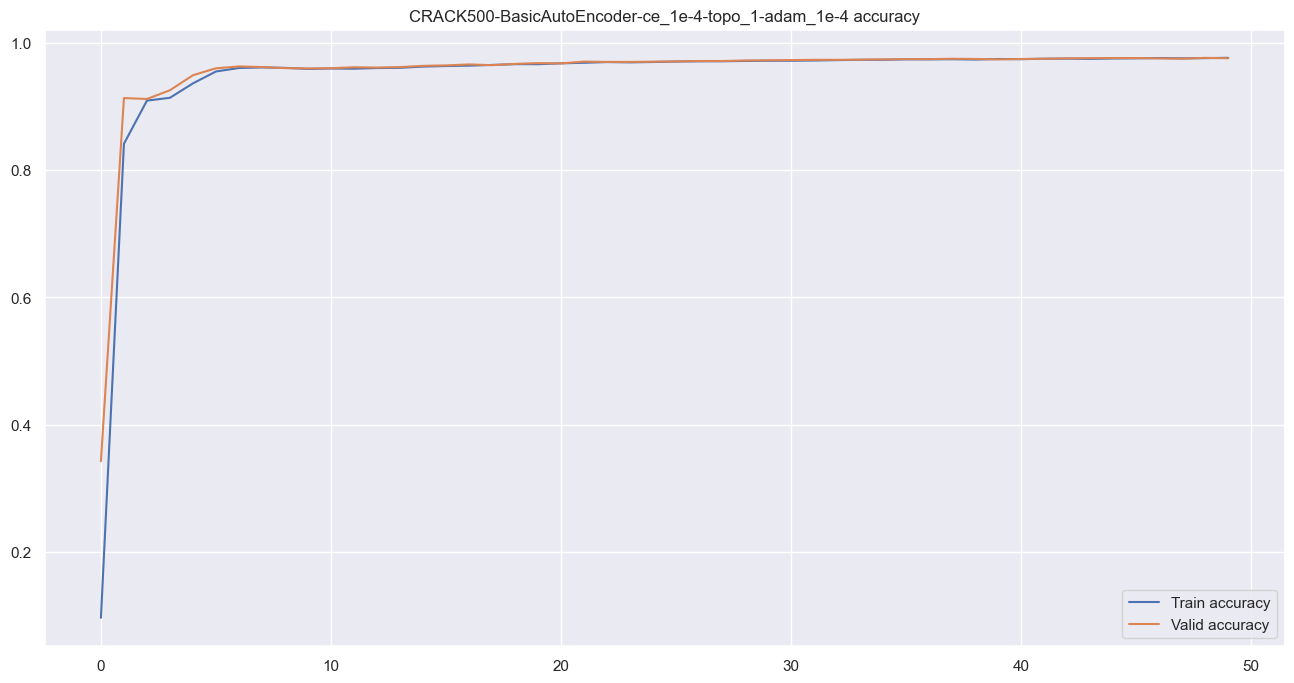

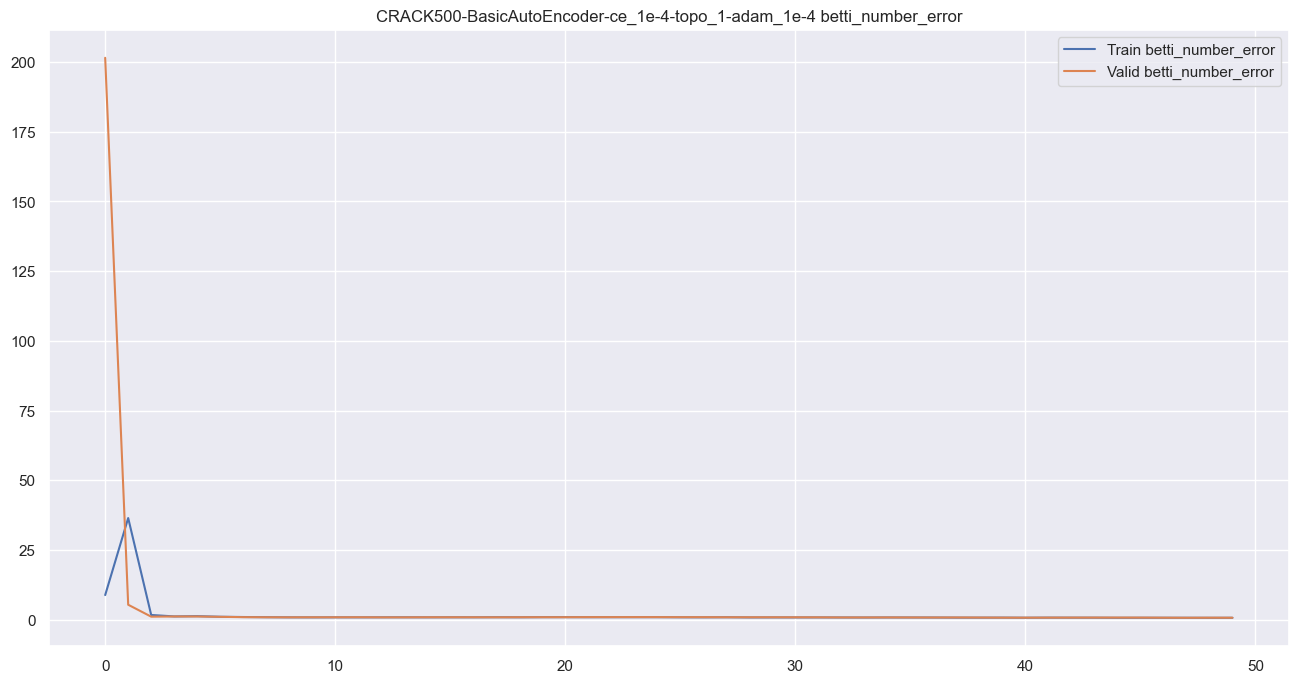

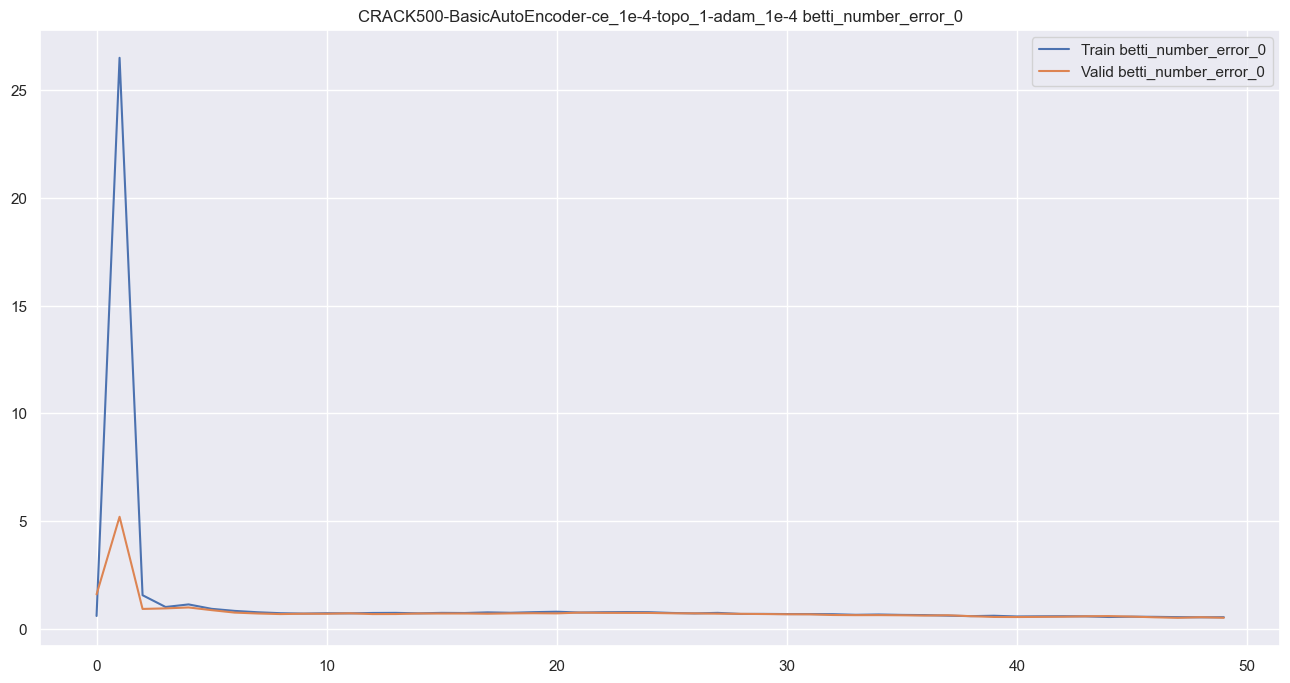

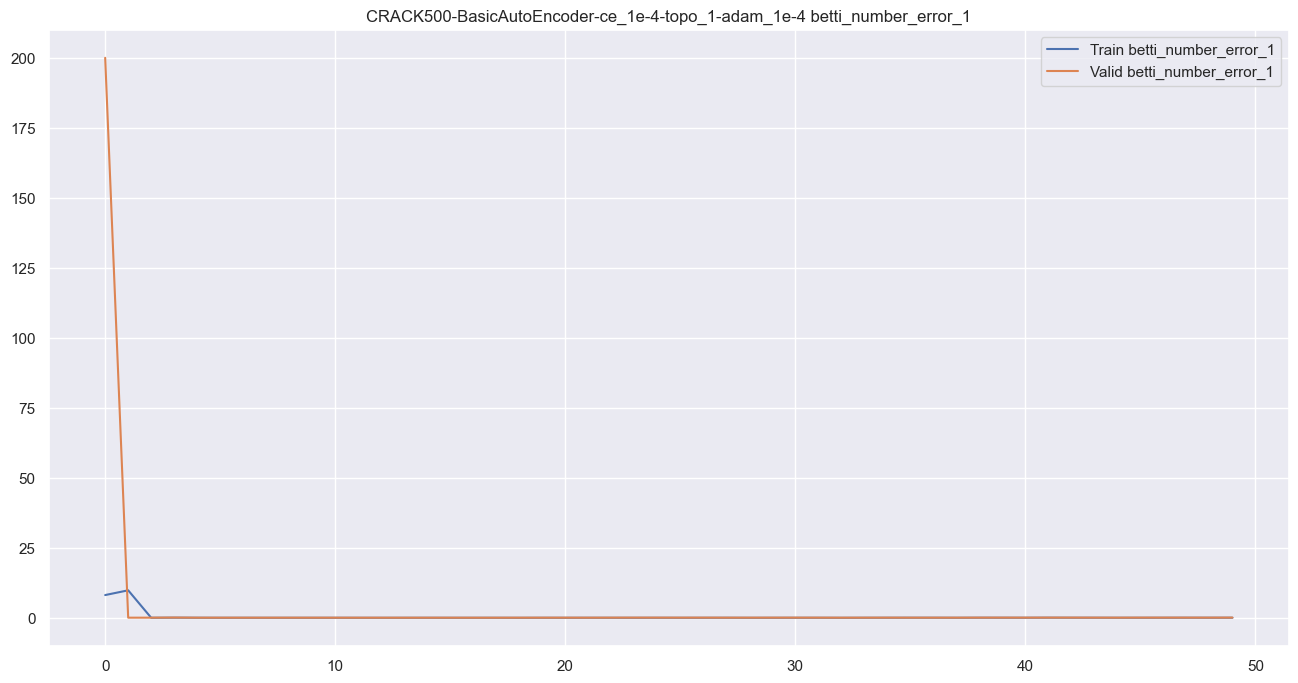

Epoch 49
 train loss: {'total': 0.09256440137244606, 'cross_entropy': 0.060900017174924936, 'topoloss': 0.3166438411137168}, train metrics: {'accuracy': 0.9770618790210424, 'betti_number_error': 0.7289972899728997, 'betti_number_error_0': 0.5266485998193315, 'betti_number_error_1': 0.2023486901535682}
 val loss: {'total': 0.09445110356829266, 'cross_entropy': 0.06185013659392731, 'topoloss': 0.3260096615520567}, val metrics: {'accuracy': 0.9763336267867959, 'betti_number_error': 0.7468354430379747, 'betti_number_error_0': 0.5009041591320073, 'betti_number_error_1': 0.24593128390596744}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [13]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

In [14]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_1e-1.pt")

100%|██████████| 18/18 [00:07<00:00,  2.32it/s]


{'accuracy': 0.974437026770967, 'betti_number_error': 0.8140794223826715, 'betti_number_error_0': 0.5018050541516246, 'betti_number_error_1': 0.31227436823104693}


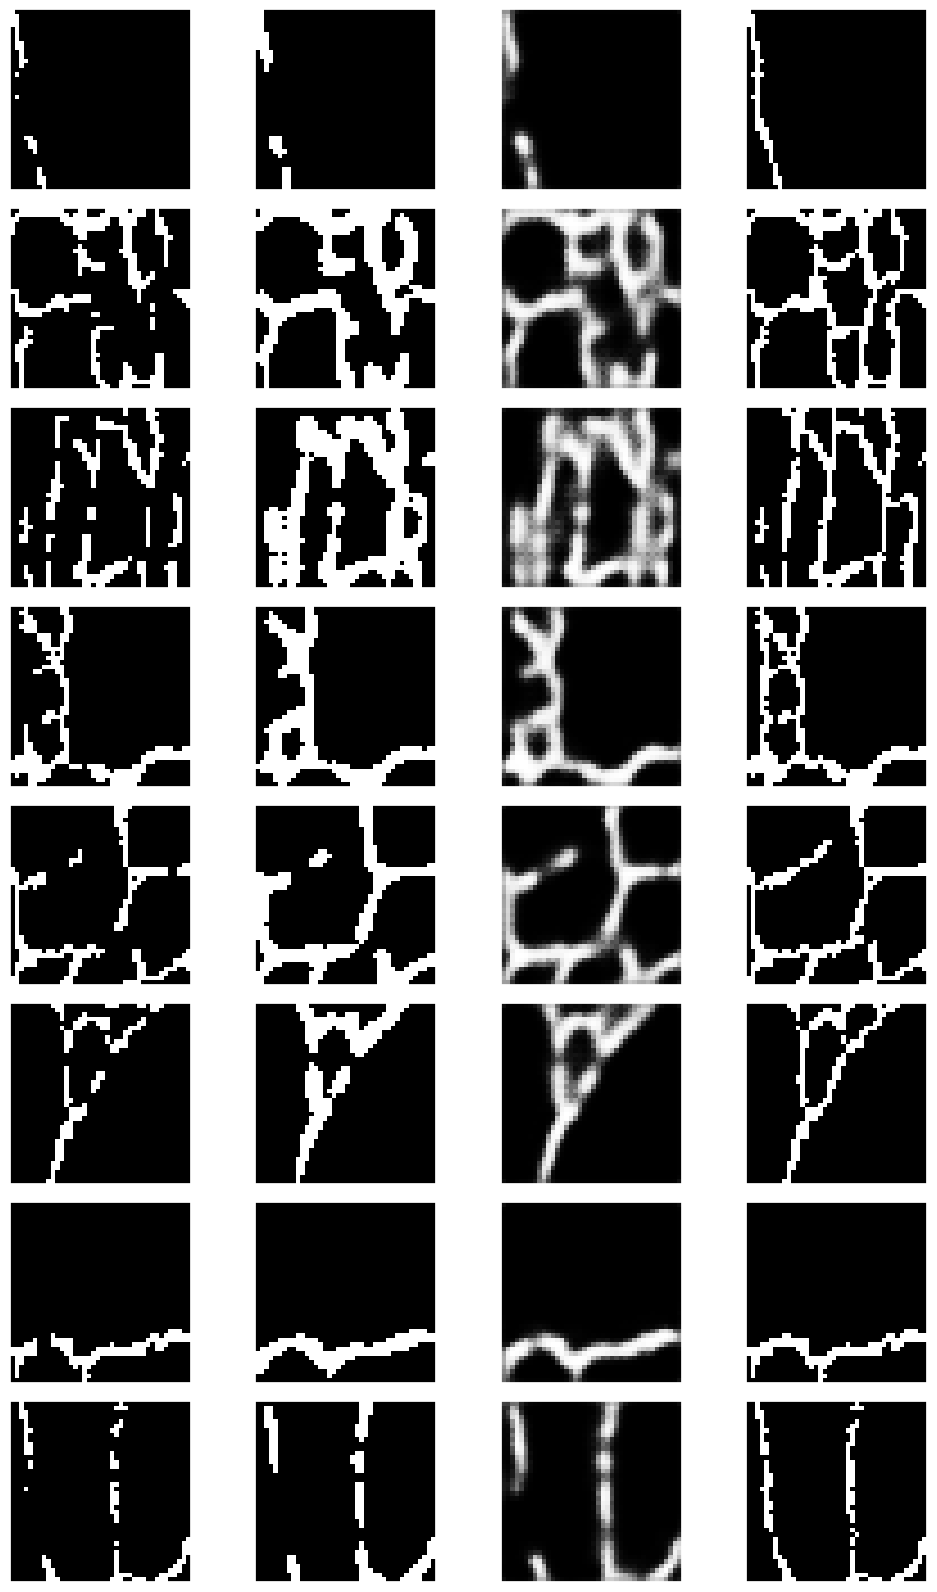

In [15]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_1e-1.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda = 0.2$

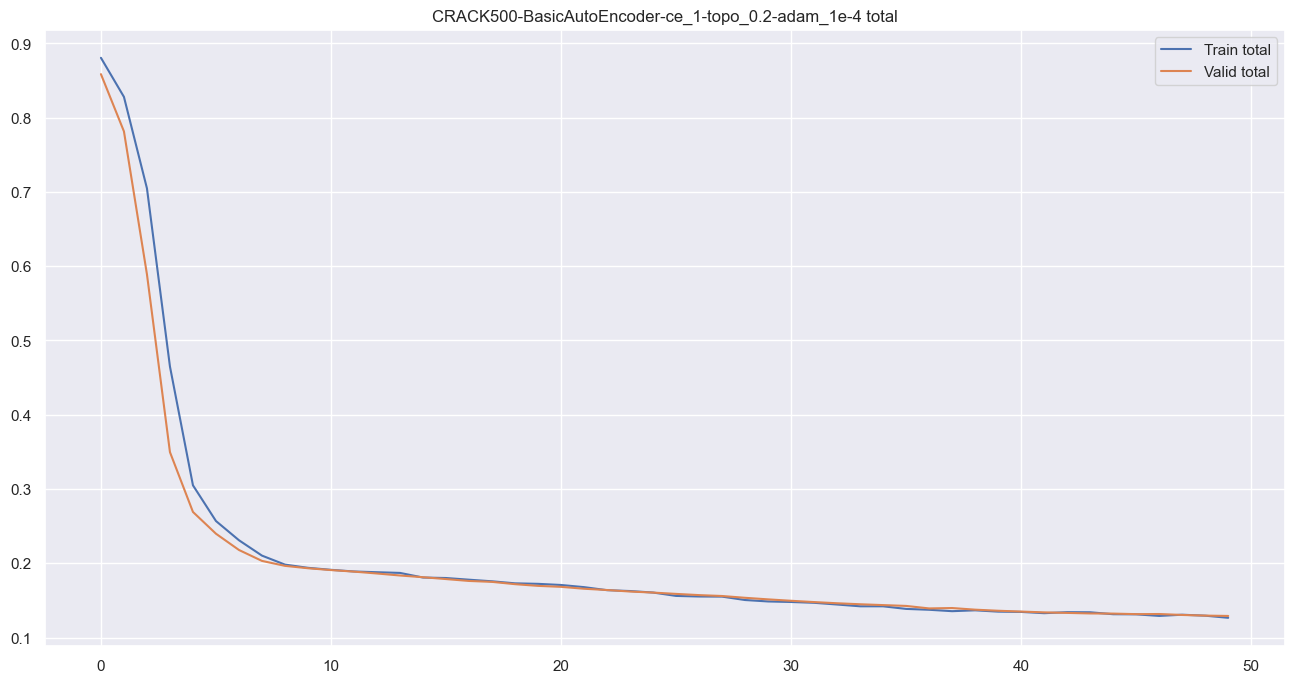

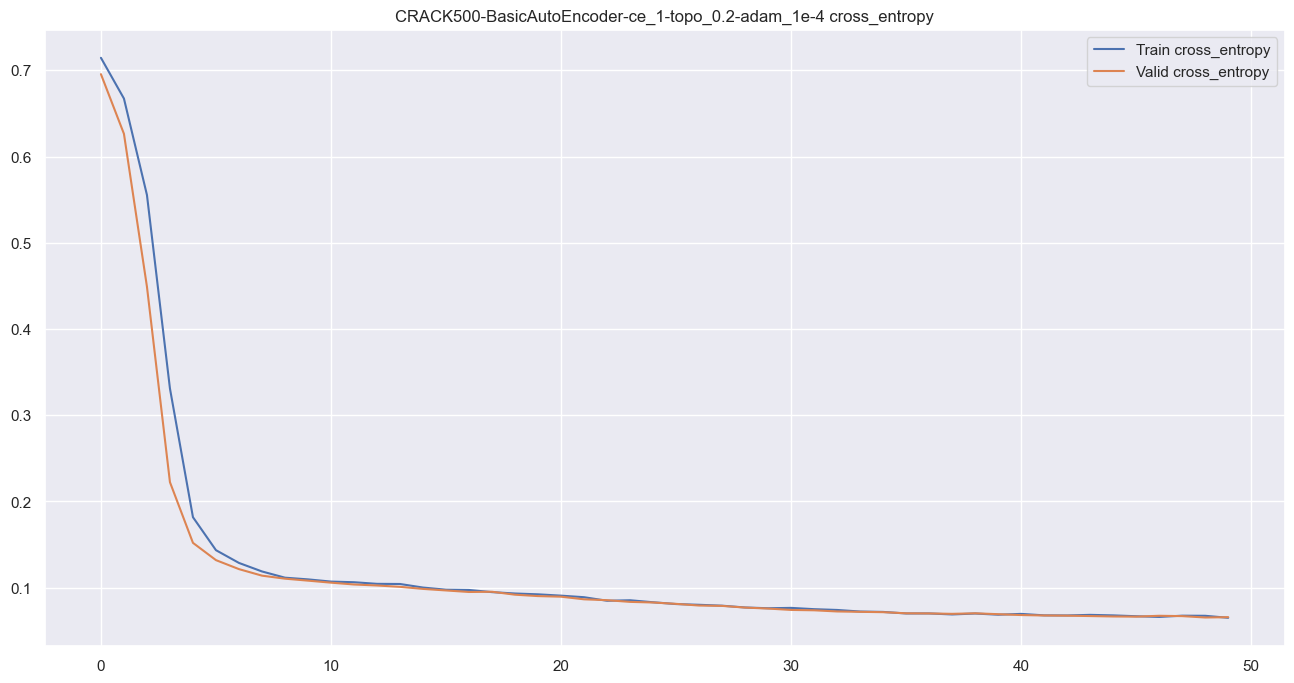

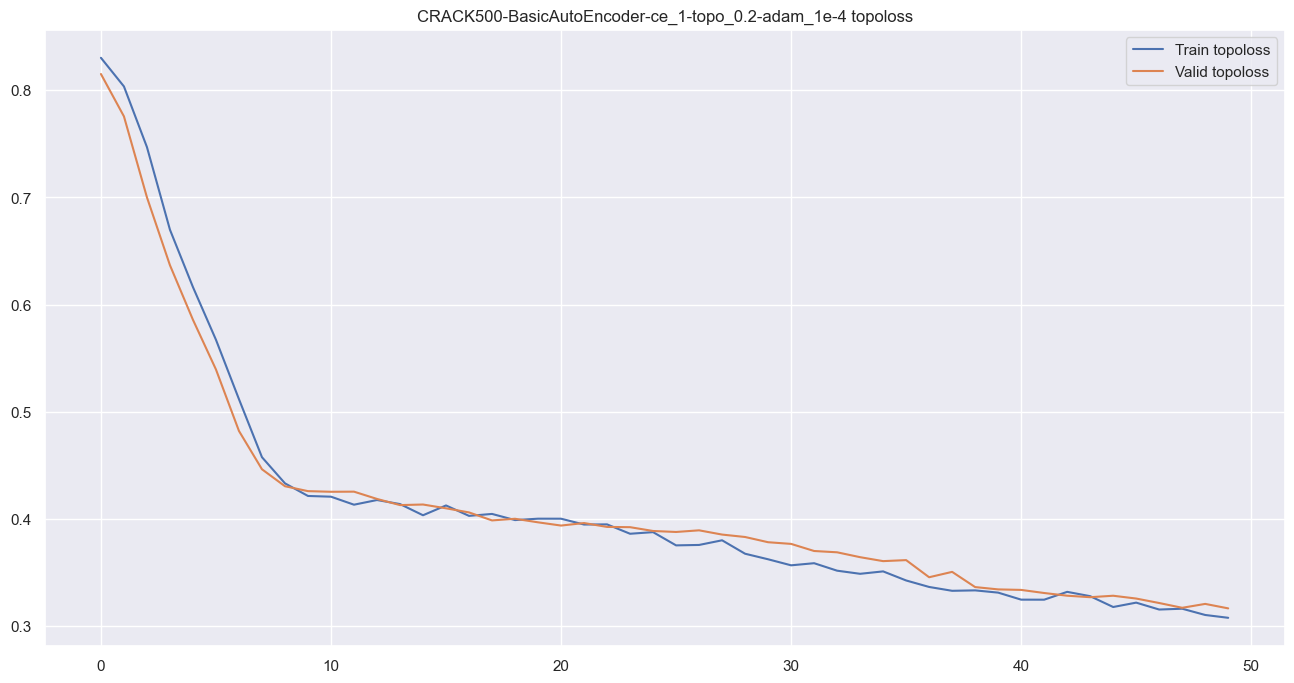

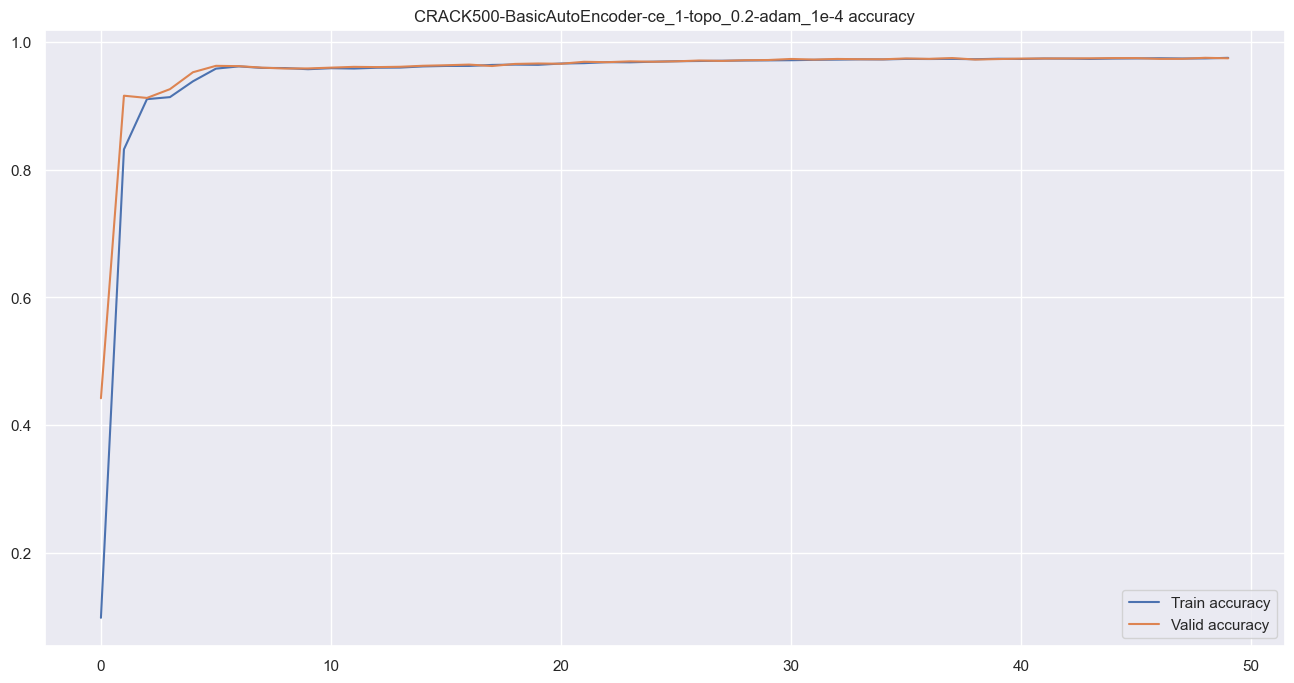

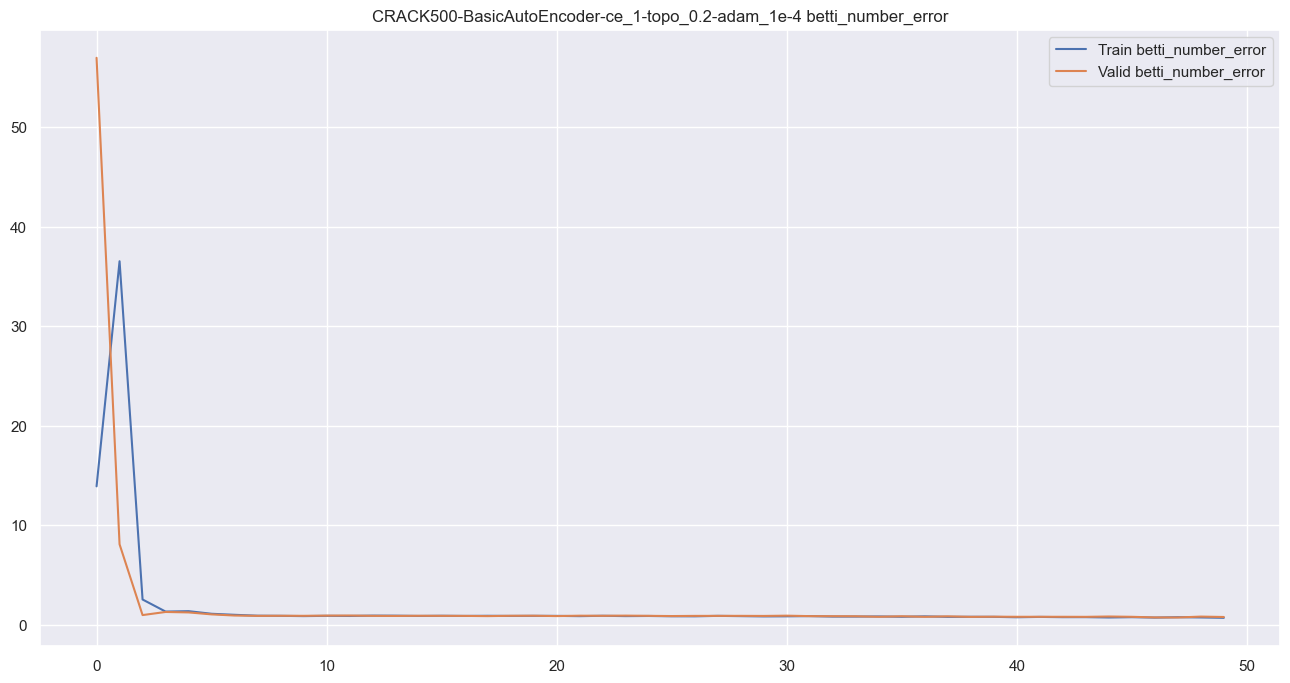

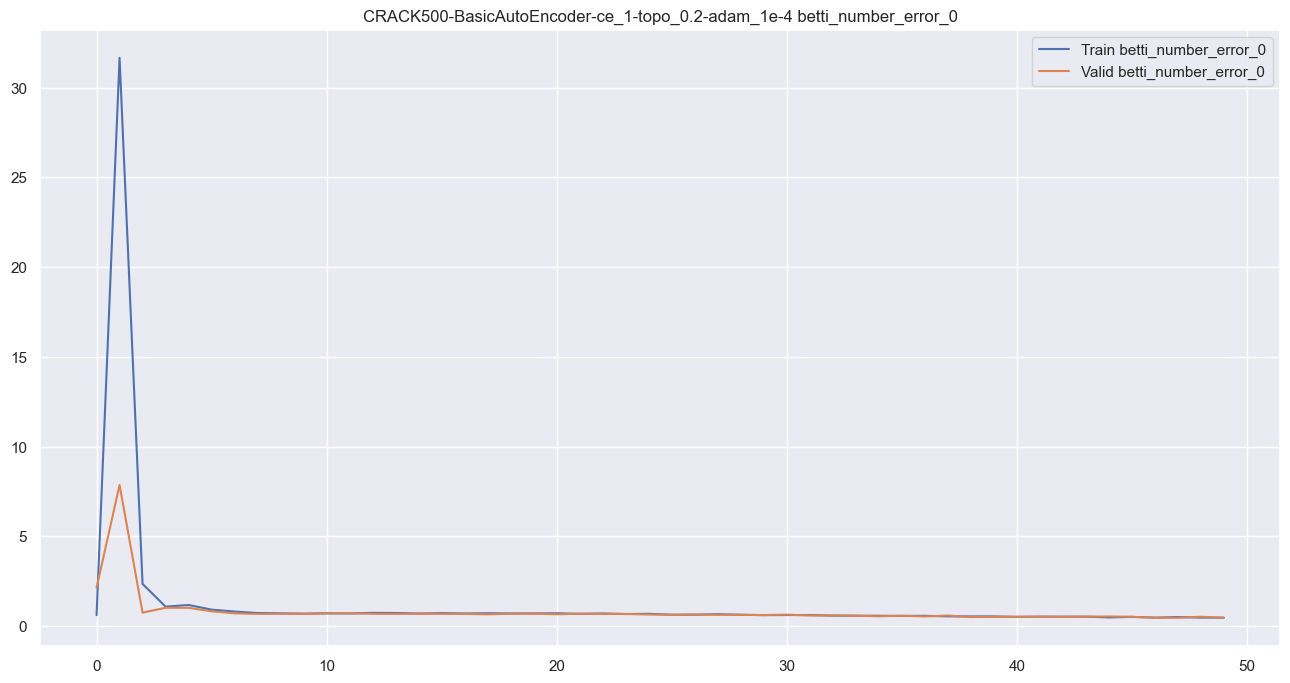

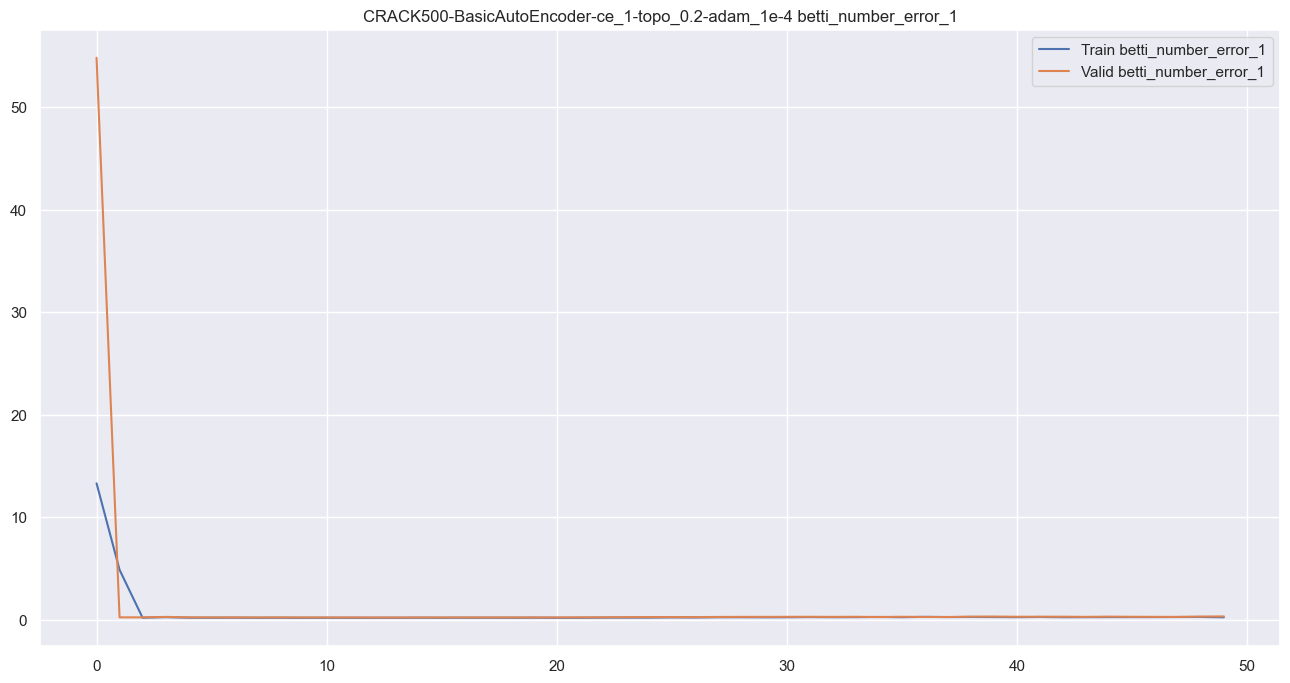

Epoch 49
 train loss: {'total': 0.12659144573849176, 'cross_entropy': 0.0650187882627575, 'topoloss': 0.30786328759404485}, train metrics: {'accuracy': 0.9748577248867073, 'betti_number_error': 0.6937669376693767, 'betti_number_error_0': 0.46612466124661245, 'betti_number_error_1': 0.22764227642276422}
 val loss: {'total': 0.12909312920803187, 'cross_entropy': 0.0657607922717848, 'topoloss': 0.3166616808010053}, val metrics: {'accuracy': 0.9741127986804486, 'betti_number_error': 0.7757685352622061, 'betti_number_error_0': 0.4629294755877034, 'betti_number_error_1': 0.3128390596745027}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [16]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.2,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.2-{config['optimizer']}_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

In [17]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_2e-1.pt")

100%|██████████| 18/18 [00:08<00:00,  2.20it/s]


{'accuracy': 0.972074685974672, 'betti_number_error': 0.8122743682310469, 'betti_number_error_0': 0.4657039711191336, 'betti_number_error_1': 0.34657039711191334}


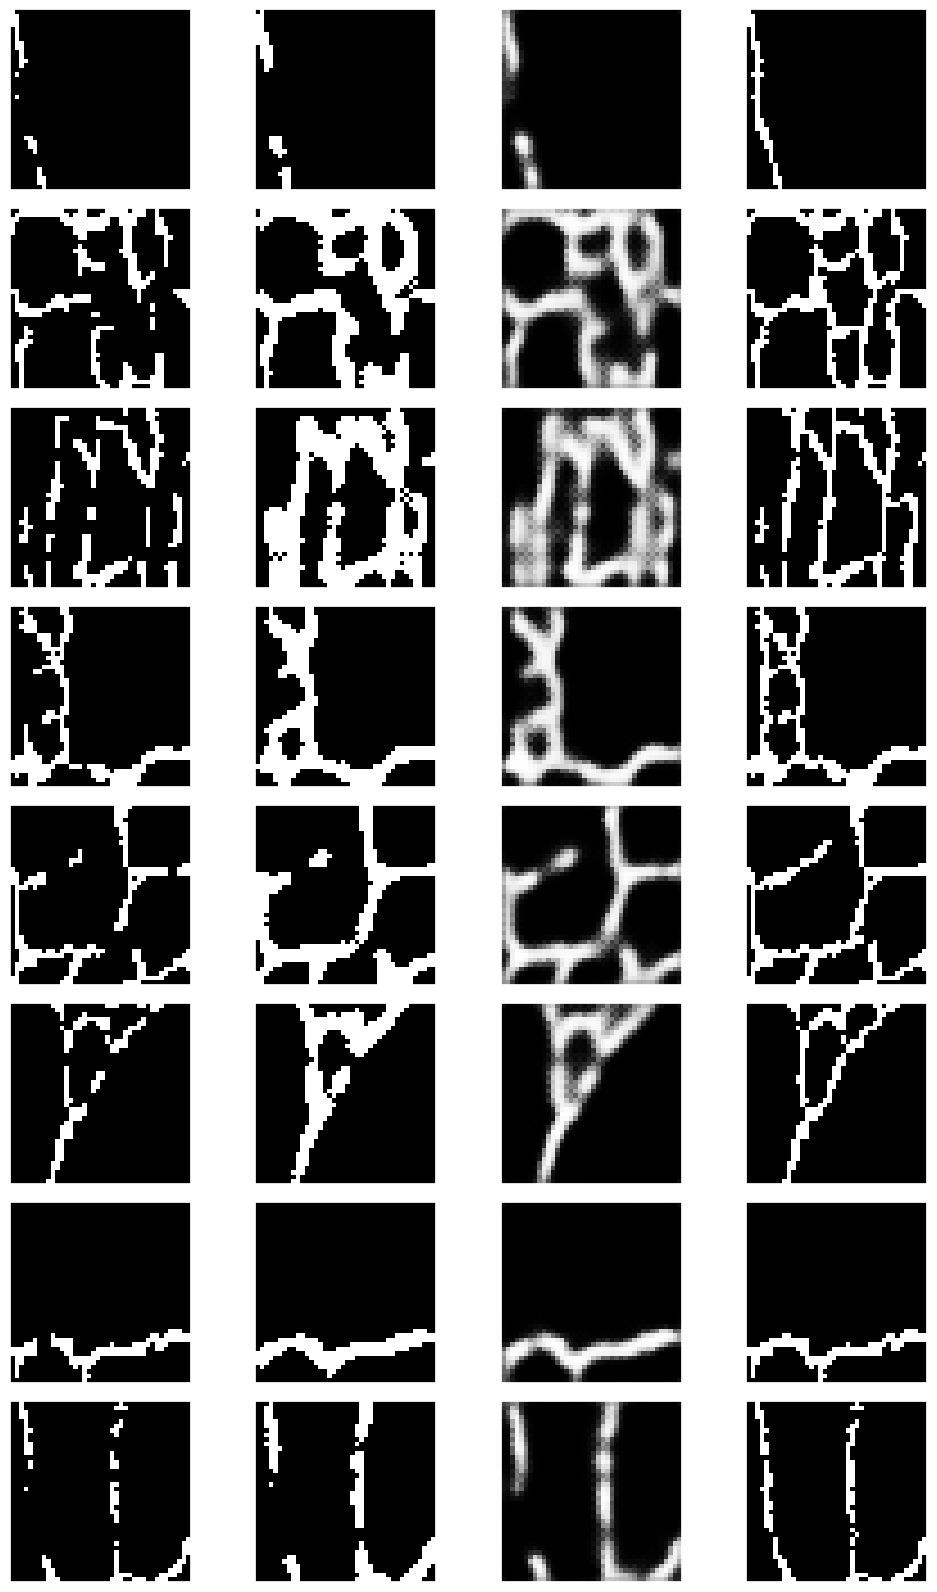

In [18]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_2e-1.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda=0.1$ & Height Filtration $v = (1, 1)$

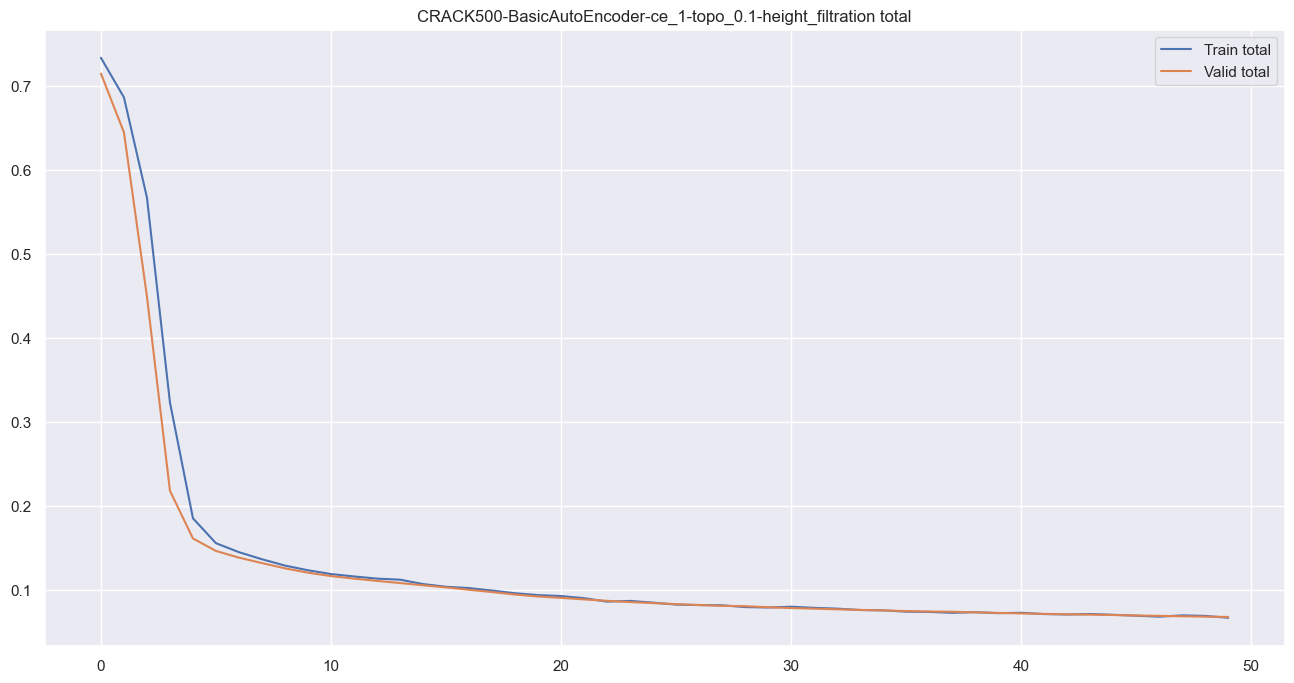

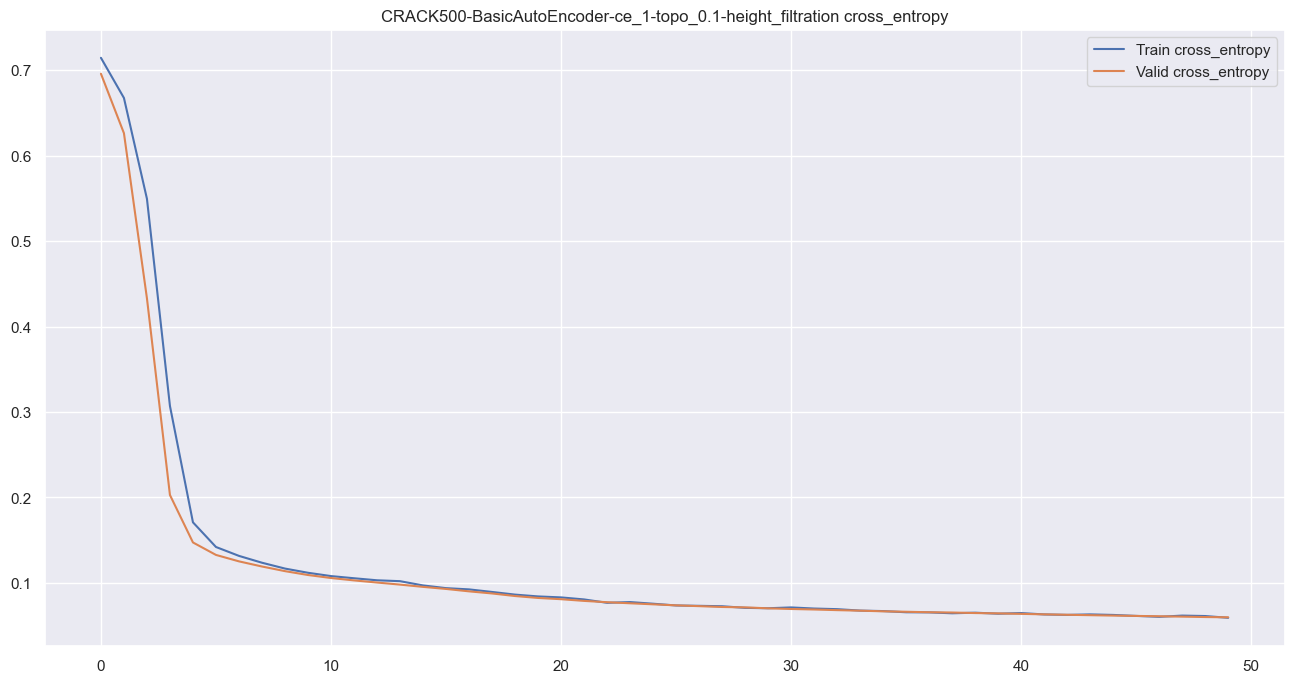

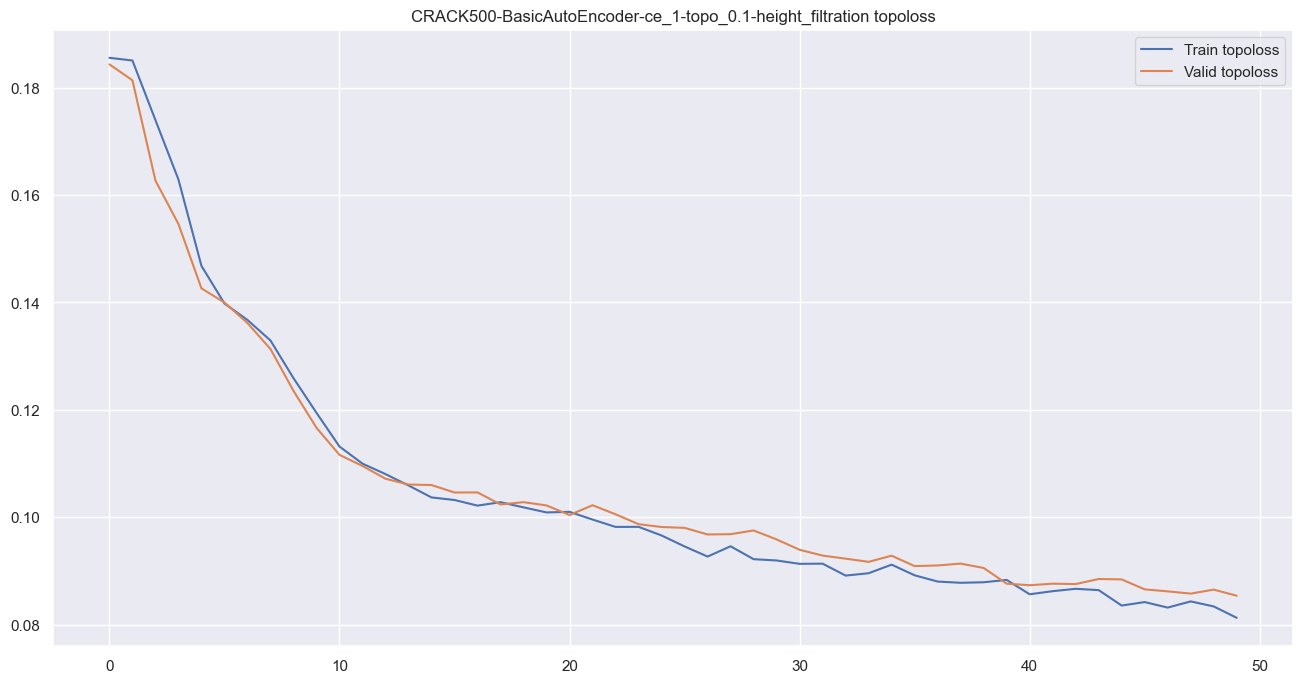

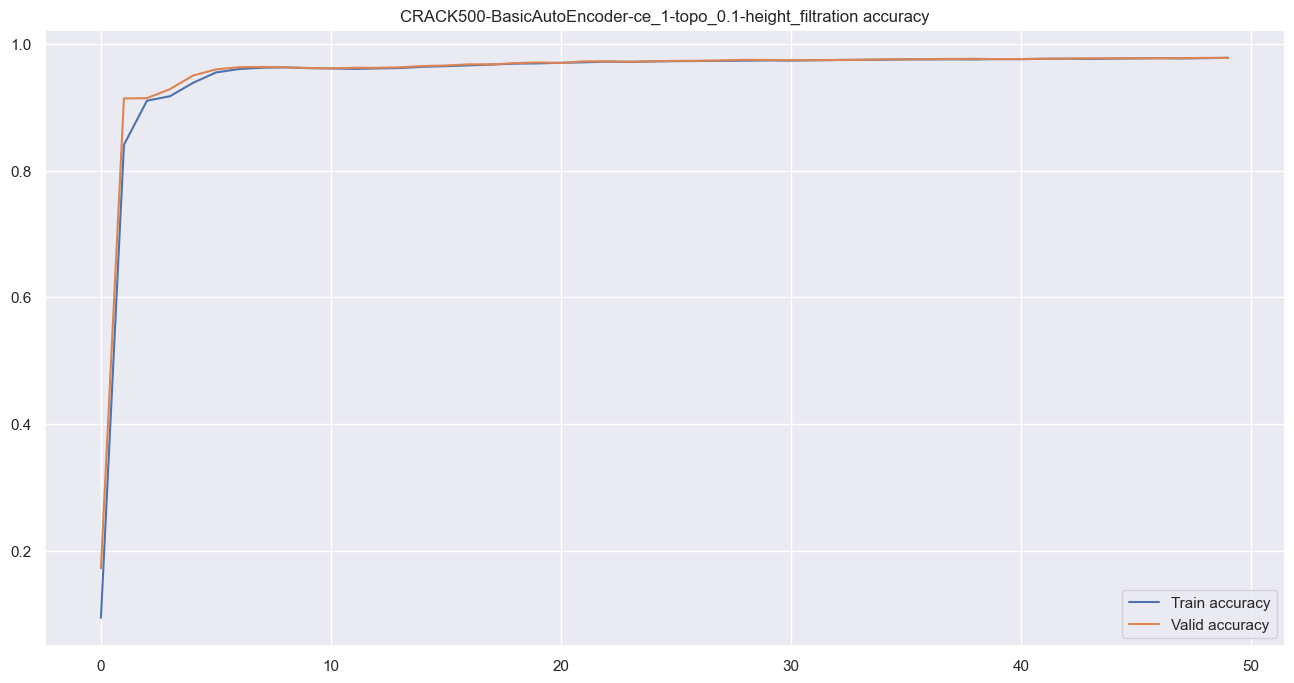

Epoch 49
 train loss: {'total': 0.06728381285828329, 'cross_entropy': 0.05915548097150436, 'topoloss': 0.08128331886778936}, train metrics: {'accuracy': 0.9781176542094299}
 val loss: {'total': 0.06828329335416125, 'cross_entropy': 0.059743833477199616, 'topoloss': 0.08539459876961629}, val metrics: {'accuracy': 0.9779916232145285, 'betti_number_error': 0.8824593128390597, 'betti_number_error_0': 0.674502712477396, 'betti_number_error_1': 0.20795660036166366}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [23]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['filtration']}_filtration"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, 1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [24]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_1e-1_height_filtration.pt")

100%|██████████| 18/18 [00:07<00:00,  2.38it/s]


{'accuracy': 0.9763391301950393, 'betti_number_error': 0.9693140794223827, 'betti_number_error_0': 0.7129963898916968, 'betti_number_error_1': 0.2563176895306859}


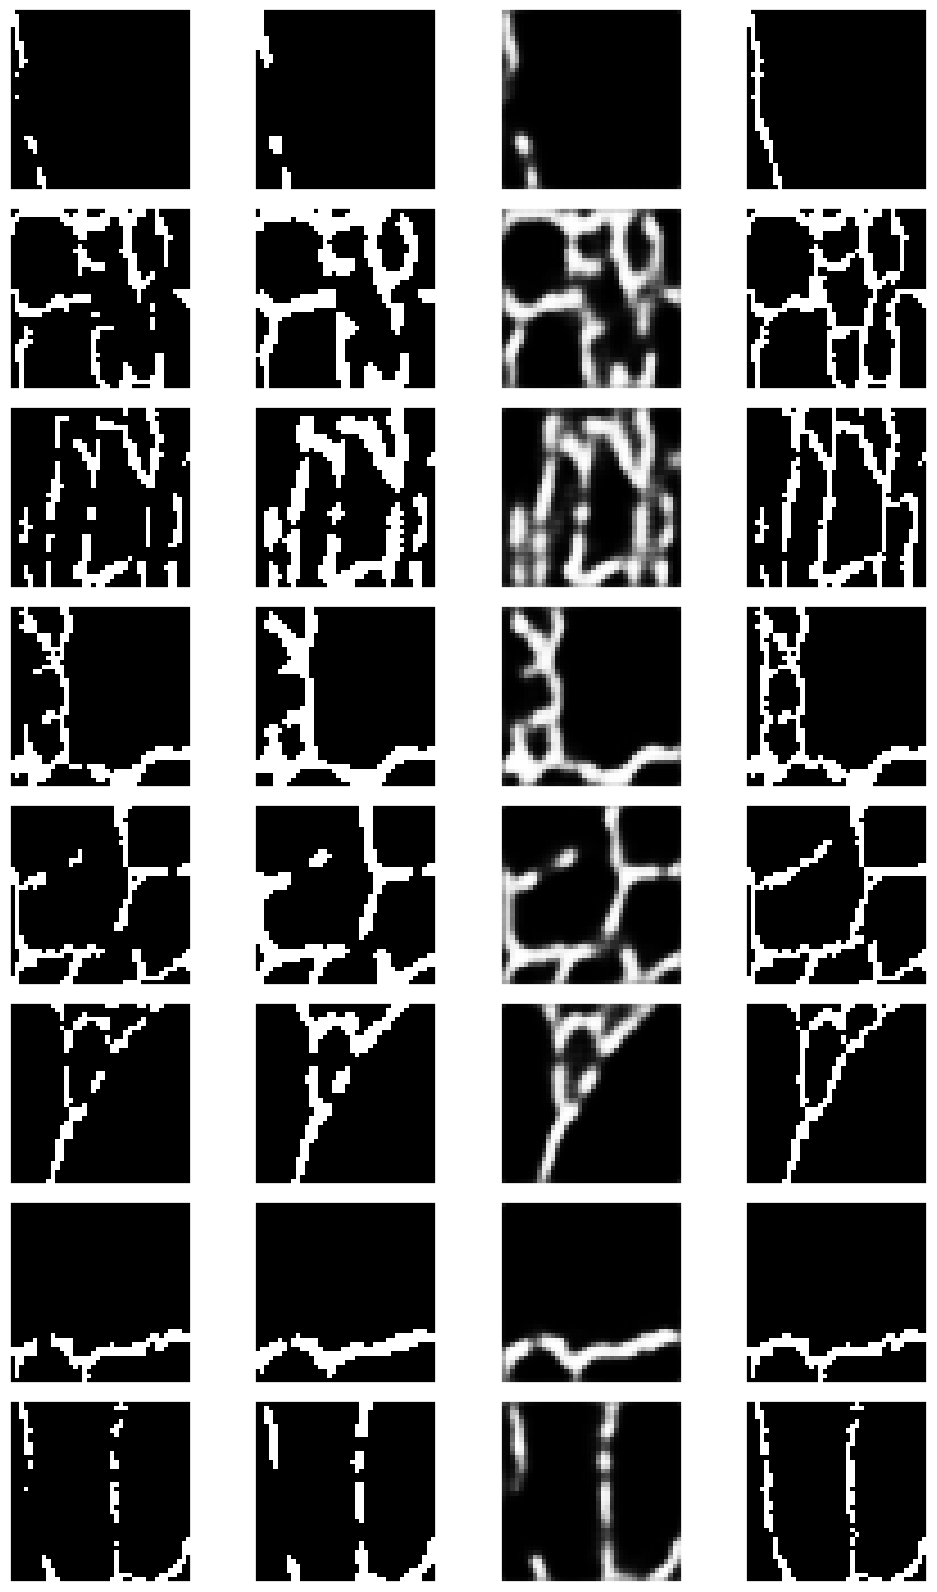

In [25]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_1e-1_height_filtration.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda=0.5$ & Height Filtration $v = (1, 1)$

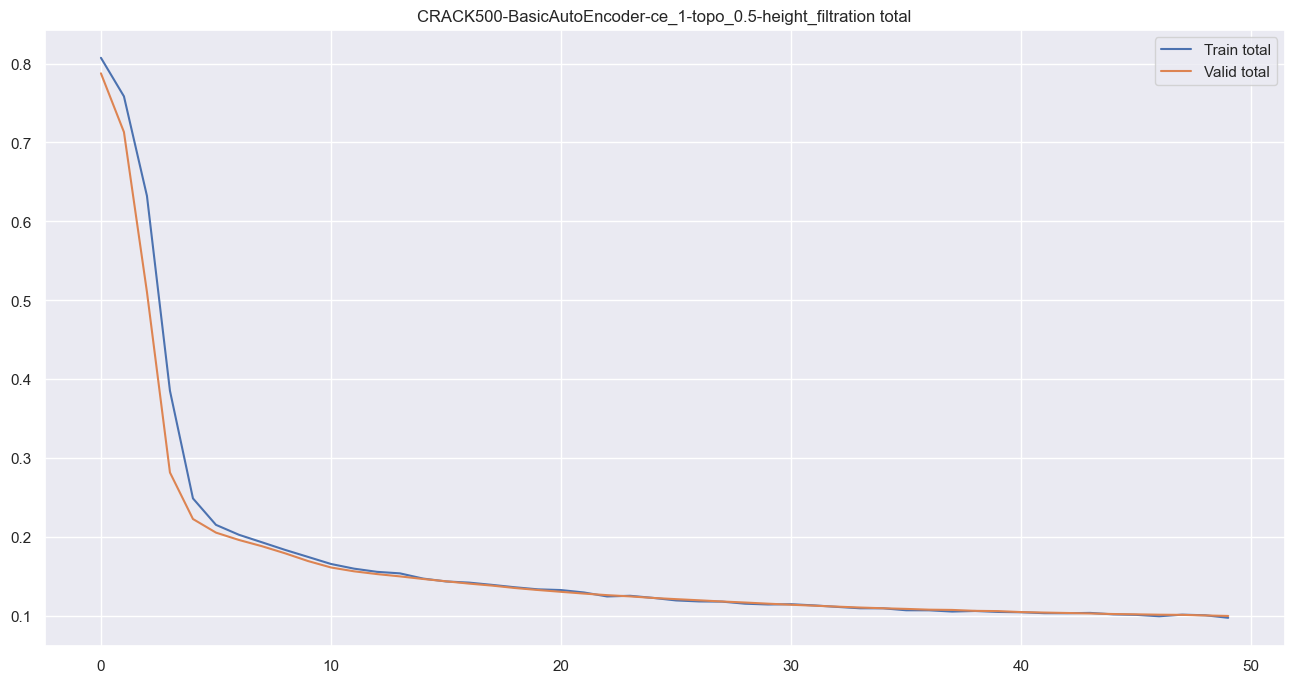

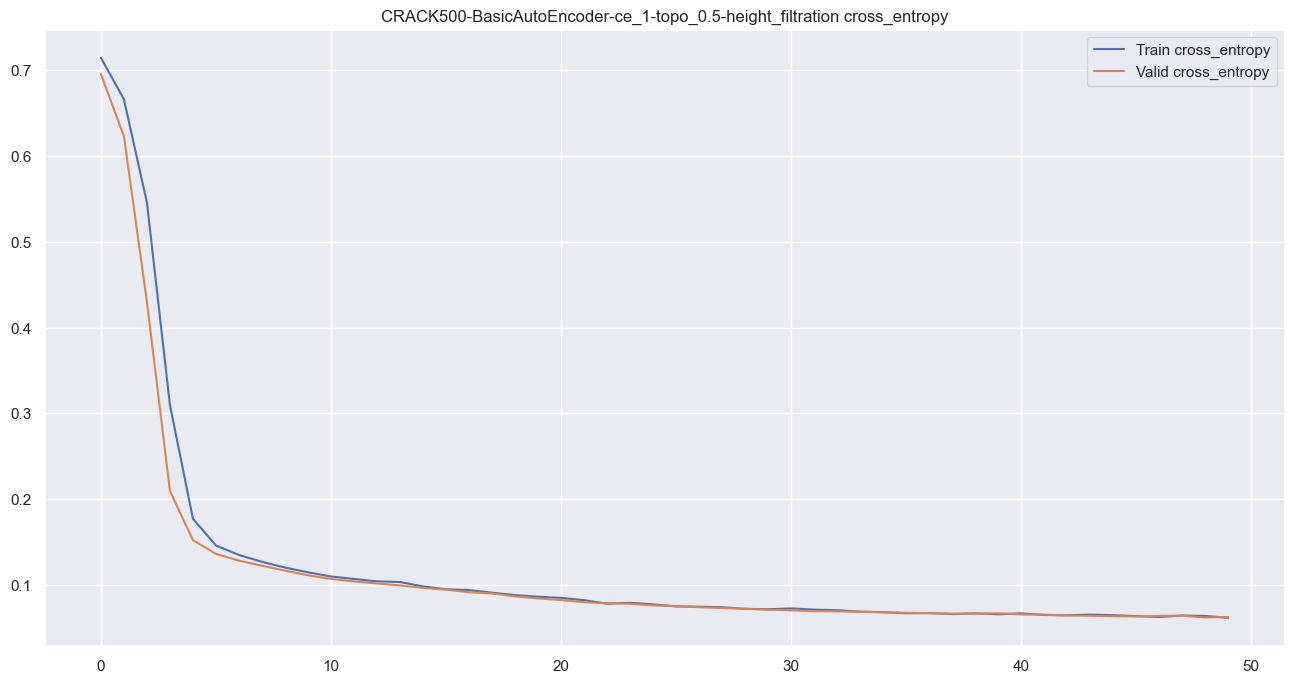

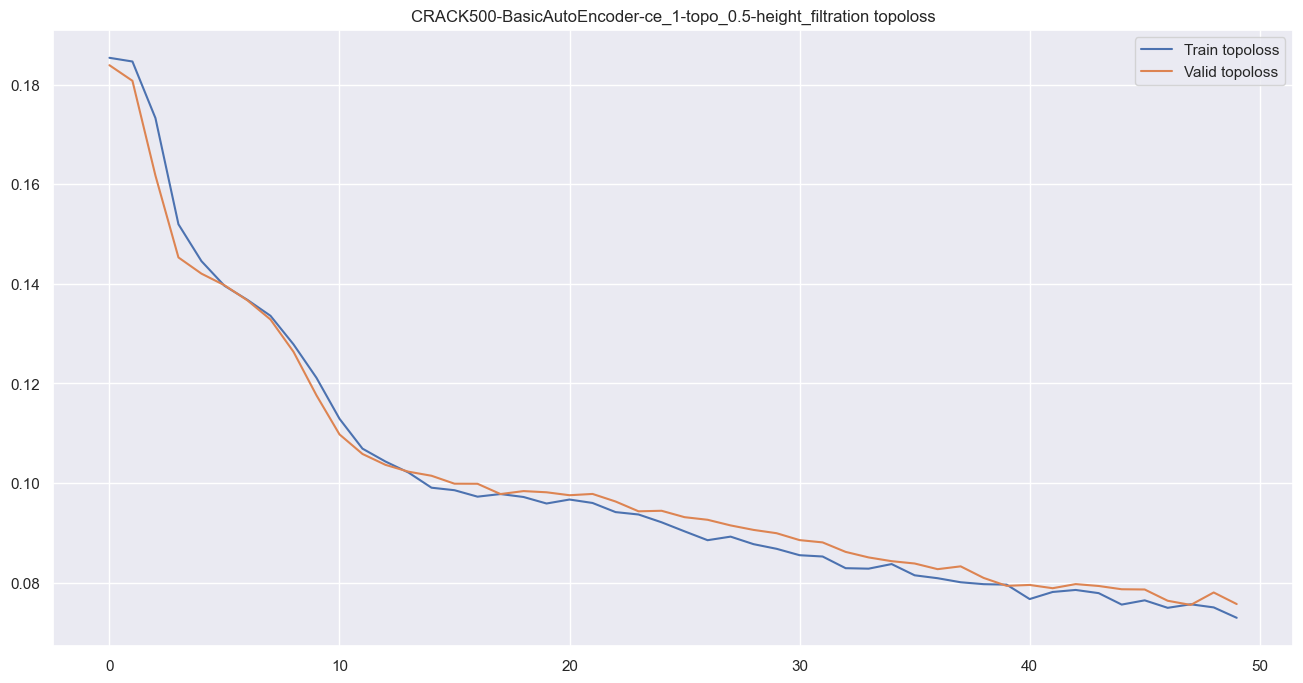

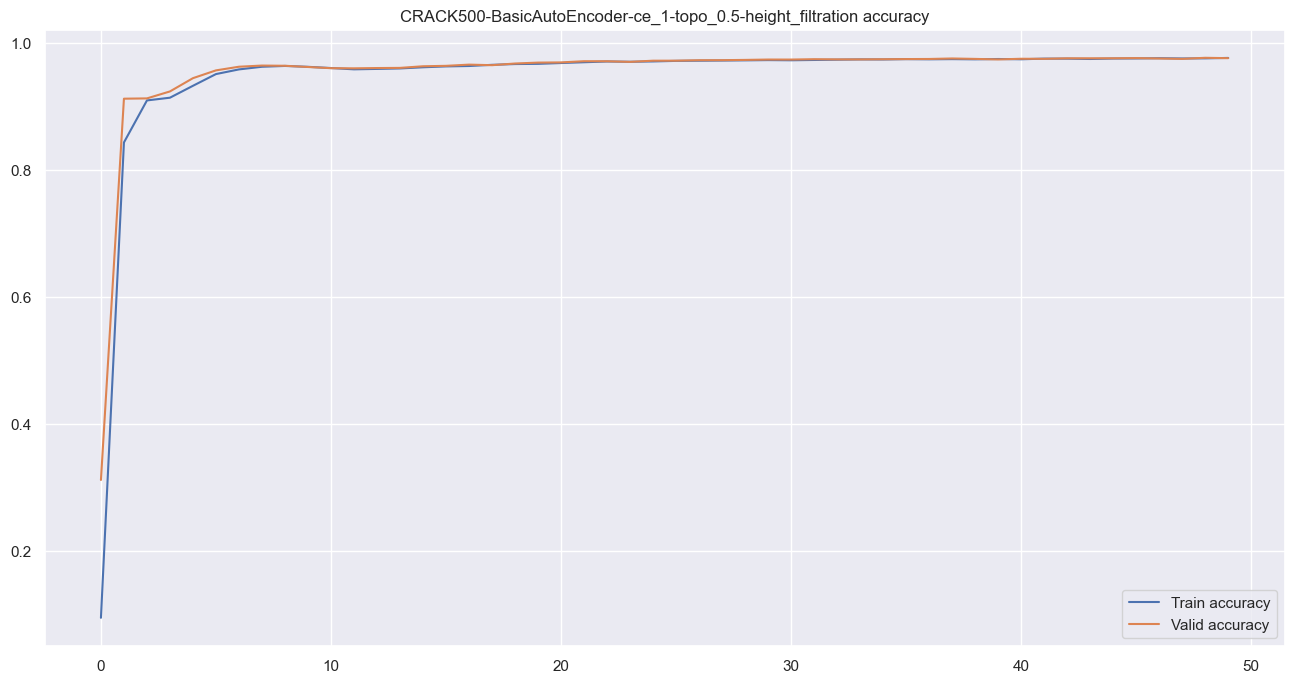

Epoch 49
 train loss: {'total': 0.09805355941559774, 'cross_entropy': 0.06158520880322685, 'topoloss': 0.0729367012247418}, train metrics: {'accuracy': 0.9761263598379188}
 val loss: {'total': 0.10039779021631585, 'cross_entropy': 0.06254789055363826, 'topoloss': 0.0756997993253552}, val metrics: {'accuracy': 0.9757459185222606, 'betti_number_error': 0.779385171790235, 'betti_number_error_0': 0.5226039783001808, 'betti_number_error_1': 0.25678119349005424}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [26]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.5,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.5-{config['filtration']}_filtration"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, 1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [27]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_5e-1_height_filtration.pt")

100%|██████████| 18/18 [00:07<00:00,  2.52it/s]


{'accuracy': 0.9738086655682174, 'betti_number_error': 0.8249097472924187, 'betti_number_error_0': 0.5397111913357401, 'betti_number_error_1': 0.2851985559566787}


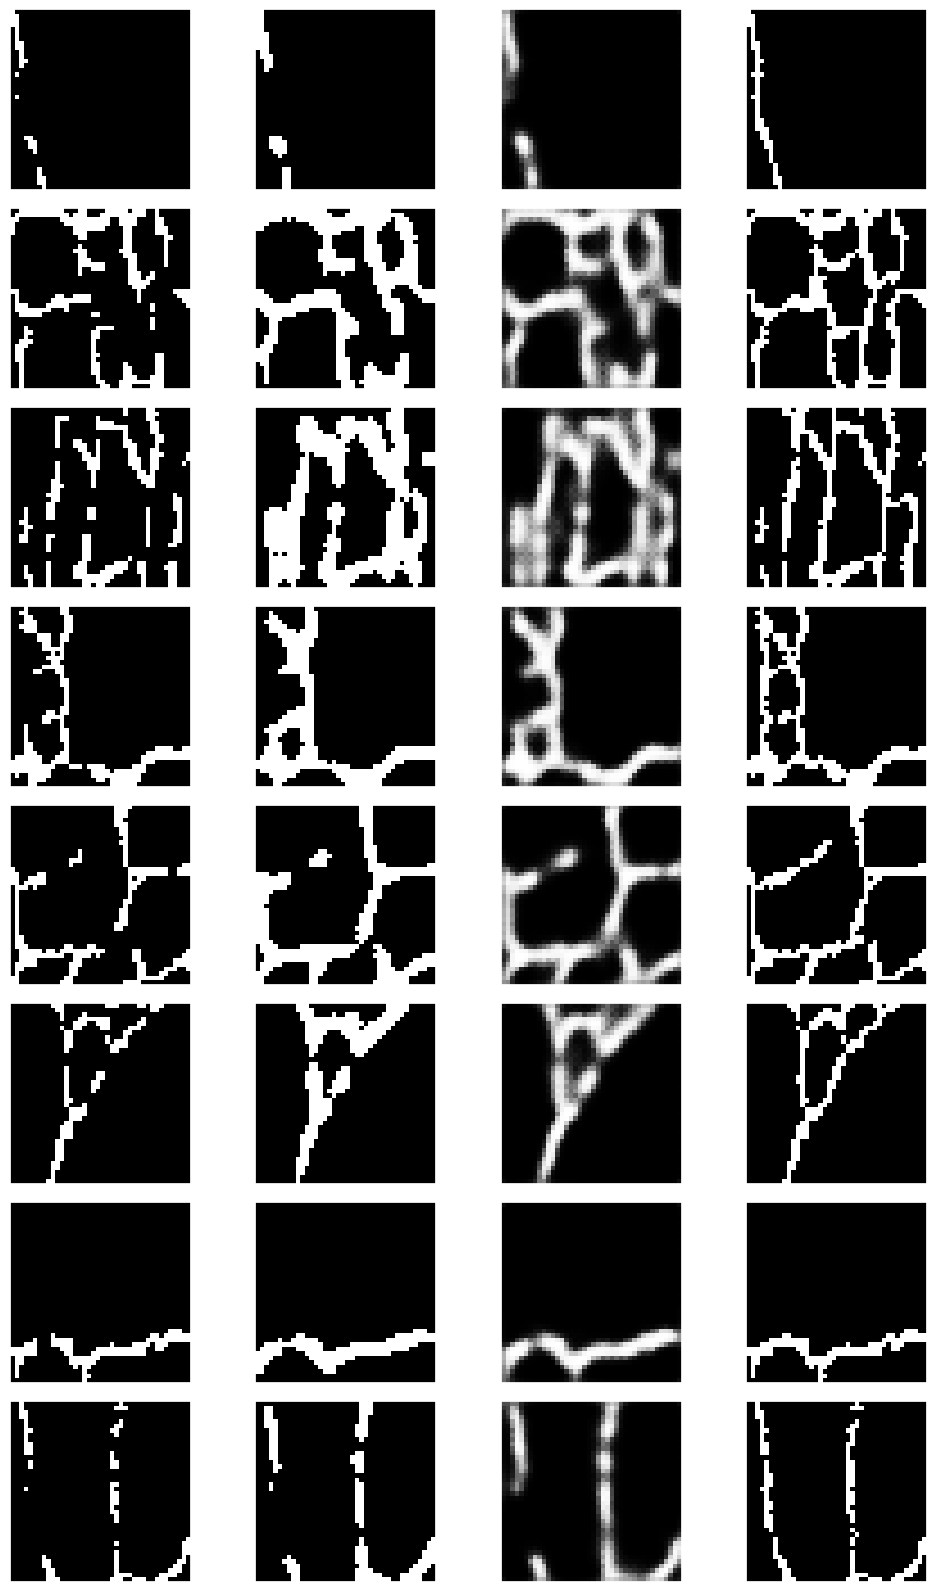

In [28]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_5e-1_height_filtration.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda=0.8$ & Height Filtration $v = (1, 1)$

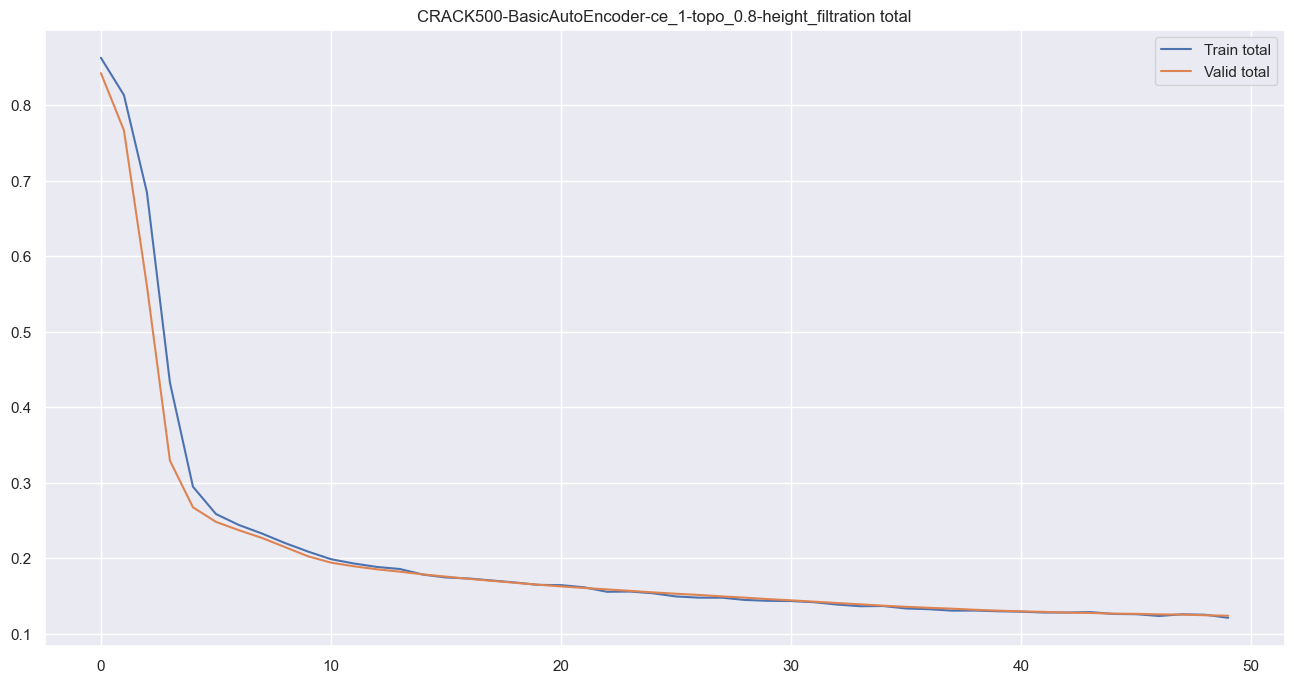

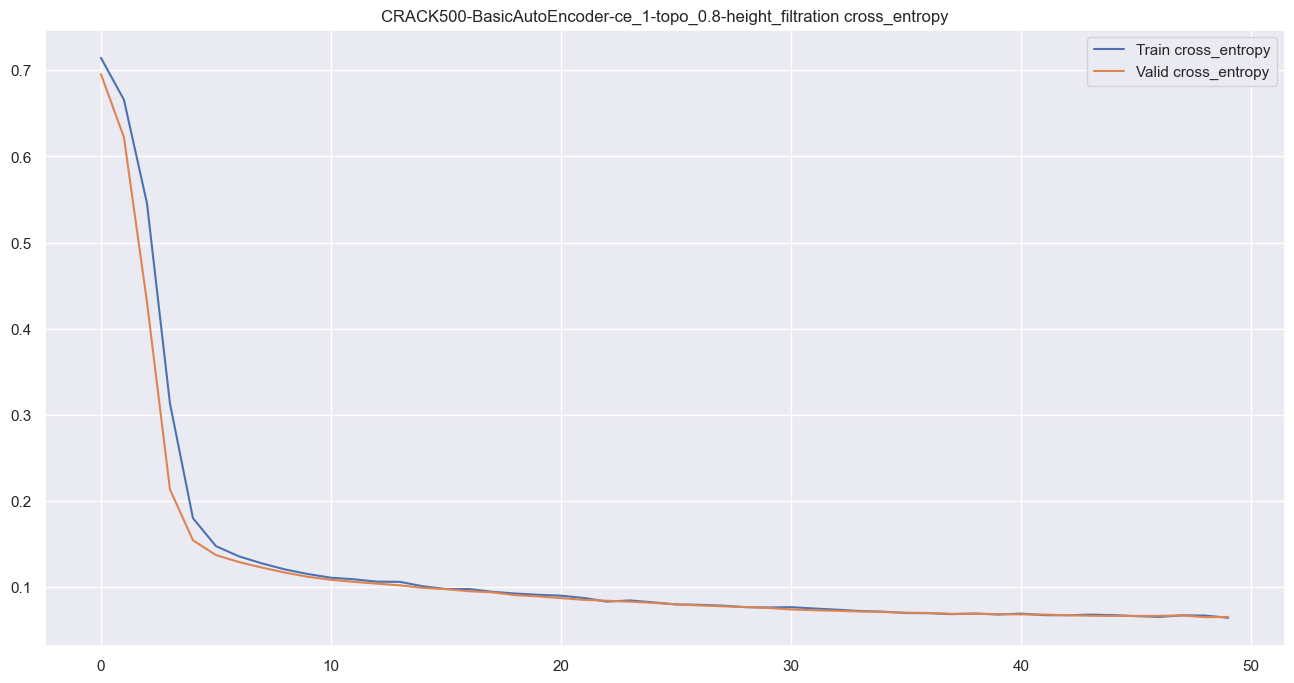

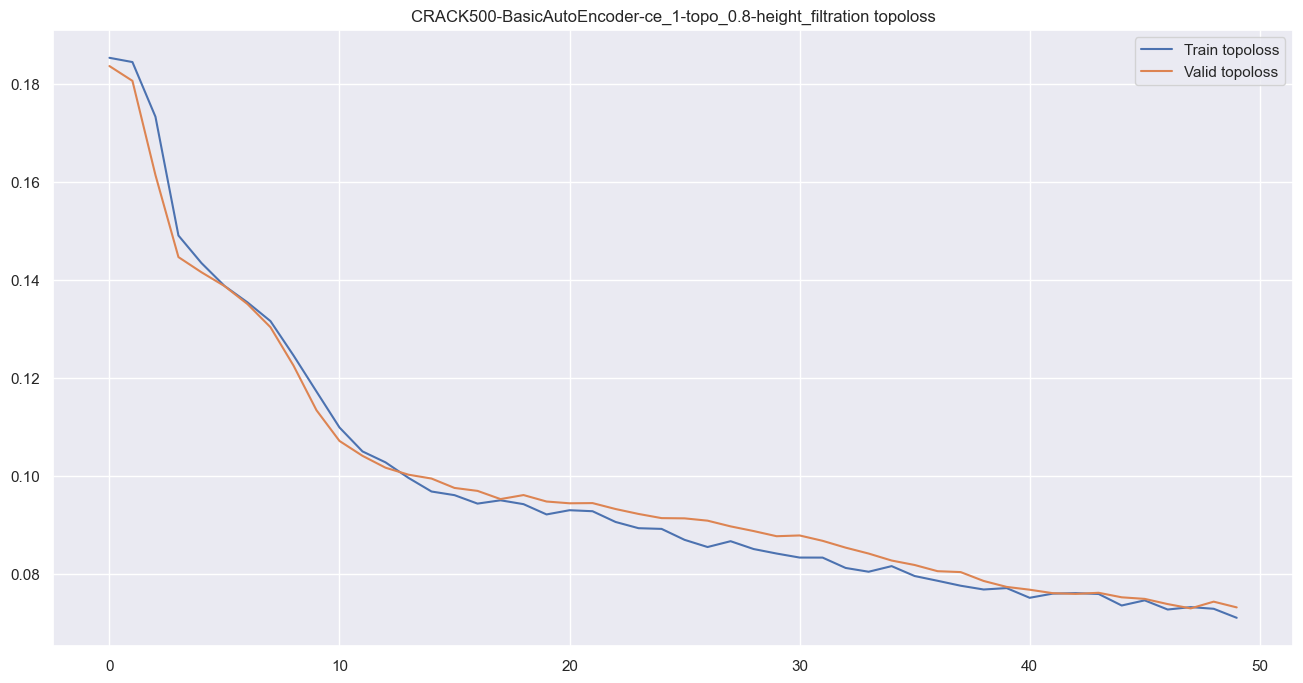

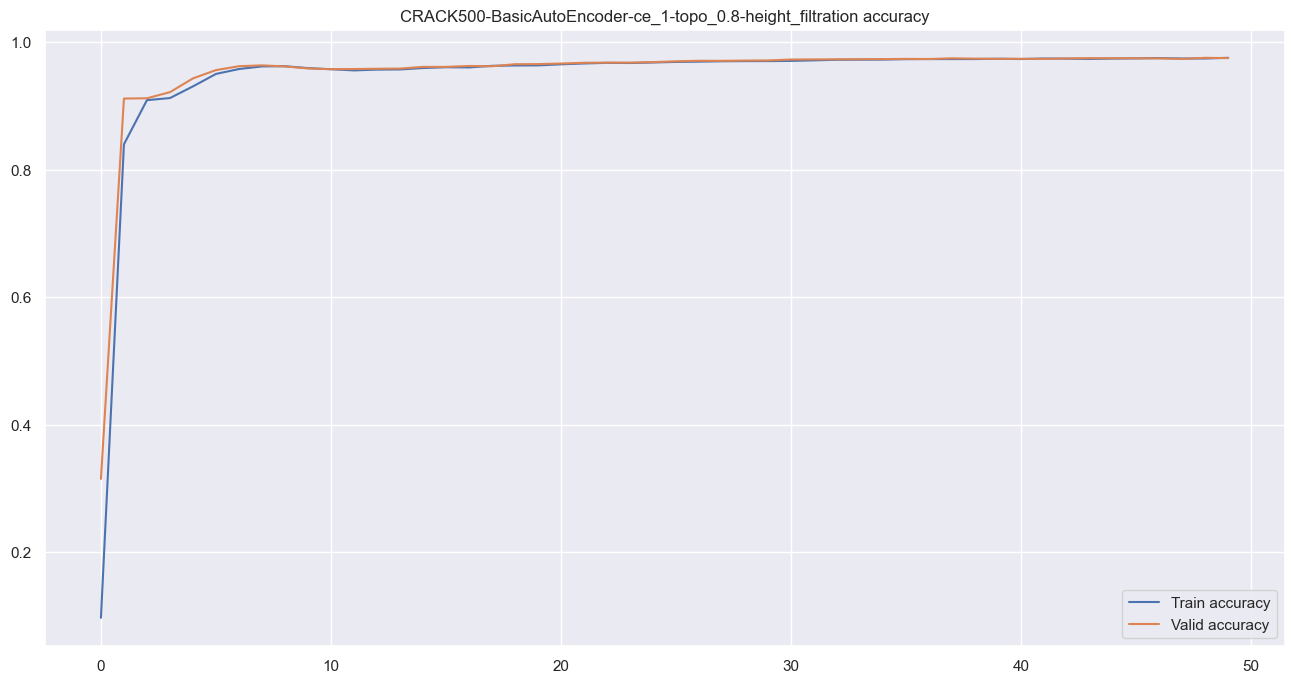

Epoch 49
 train loss: {'total': 0.12117540277639603, 'cross_entropy': 0.06440167698433728, 'topoloss': 0.07096715724007342}, train metrics: {'accuracy': 0.9752992321589883}
 val loss: {'total': 0.12390668551616914, 'cross_entropy': 0.06543222247584173, 'topoloss': 0.07309307880040926}, val metrics: {'accuracy': 0.9748135078664714, 'betti_number_error': 0.6582278481012658, 'betti_number_error_0': 0.4430379746835443, 'betti_number_error_1': 0.21518987341772153}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [29]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.8,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.8-{config['filtration']}_filtration"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, 1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [30]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_8e-1_height_filtration.pt")

100%|██████████| 18/18 [00:06<00:00,  2.58it/s]


{'accuracy': 0.9726489046420431, 'betti_number_error': 0.720216606498195, 'betti_number_error_0': 0.48375451263537905, 'betti_number_error_1': 0.2364620938628159}


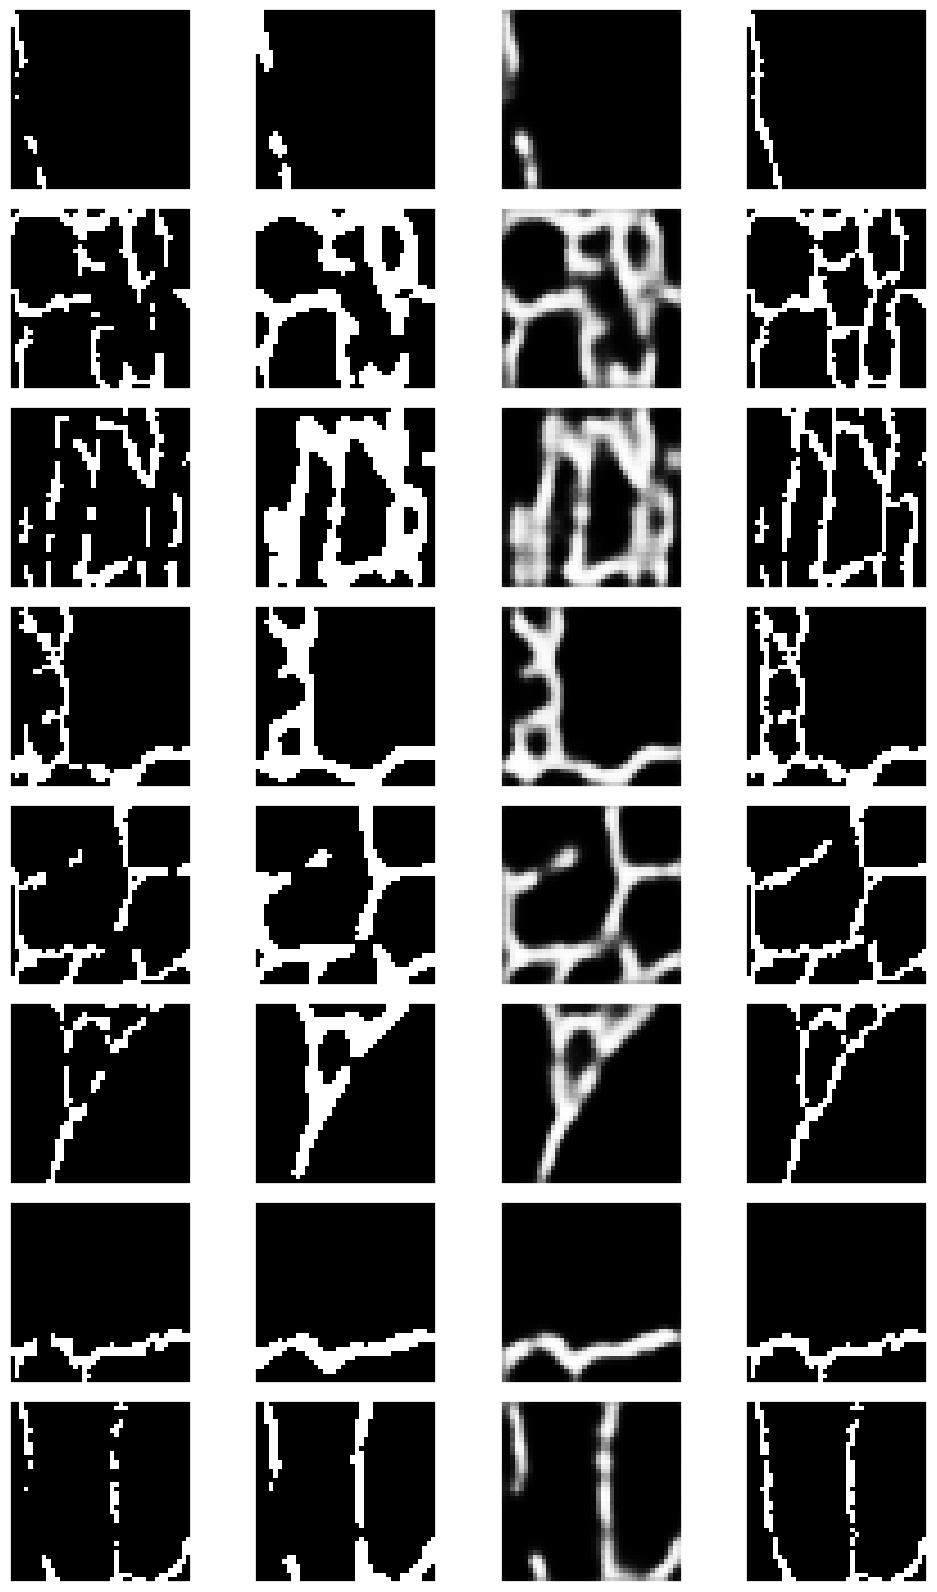

In [31]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_8e-1_height_filtration.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda=0.7$ & Height Filtration $v = (1, 1)$

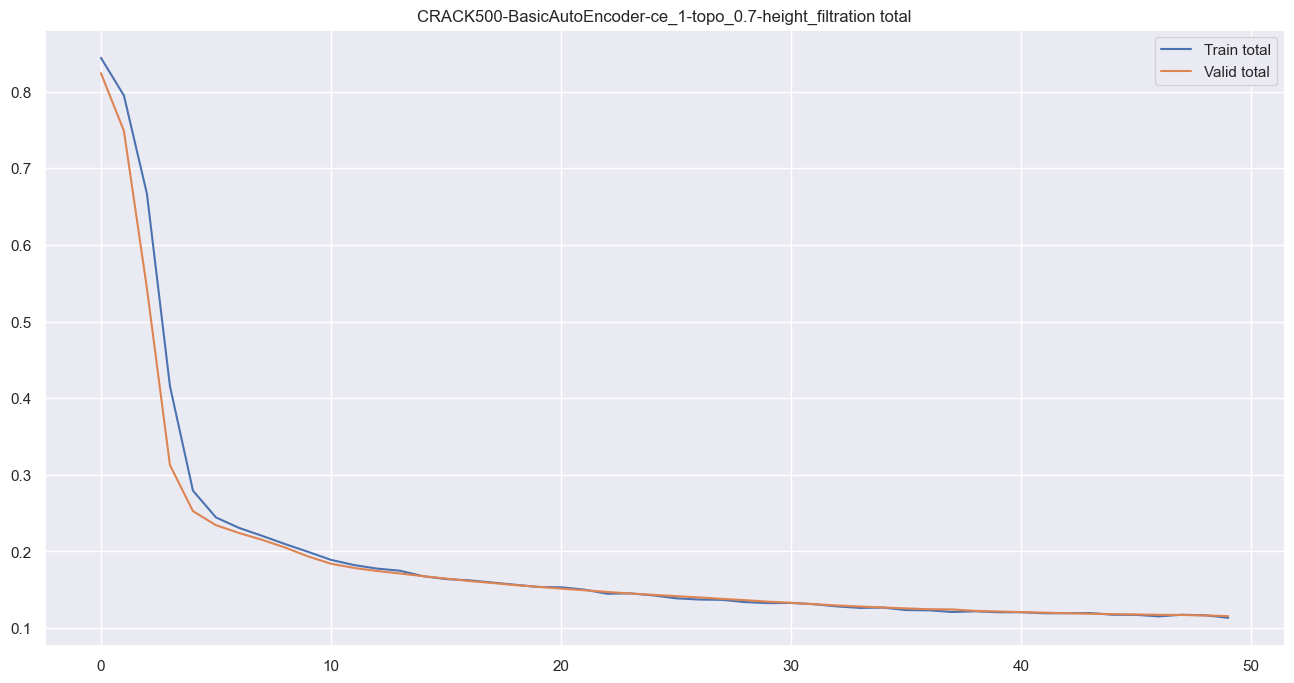

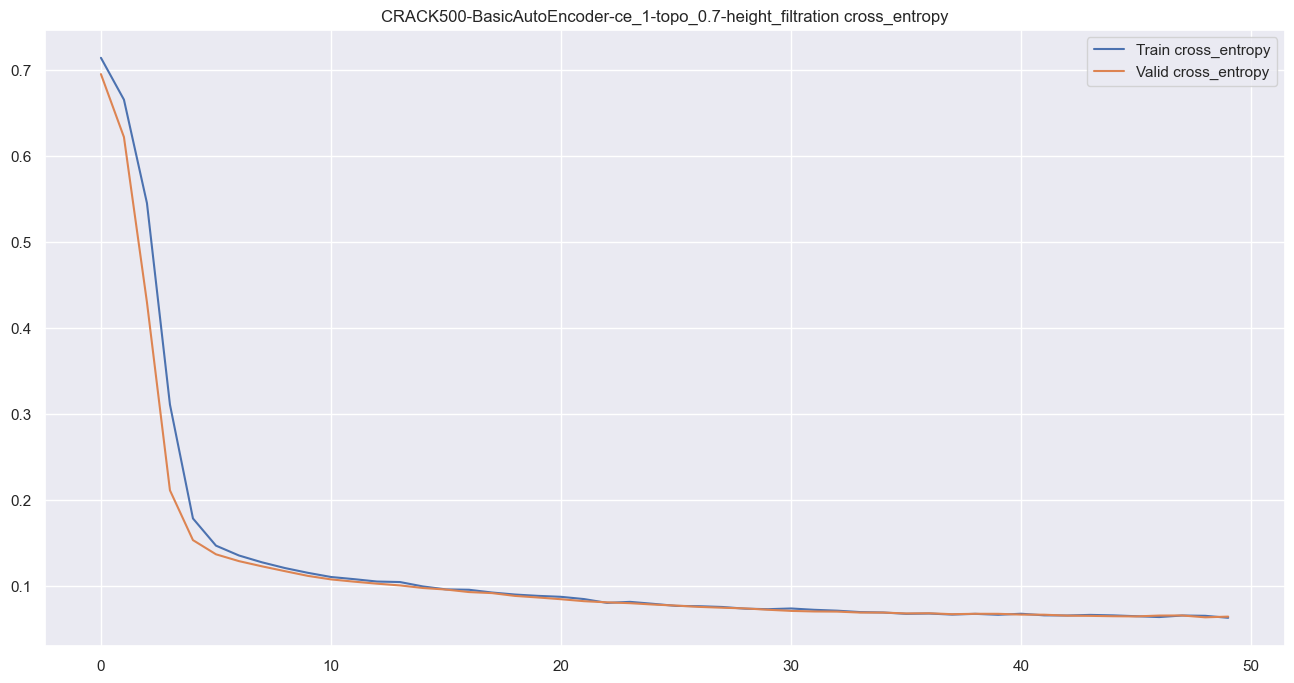

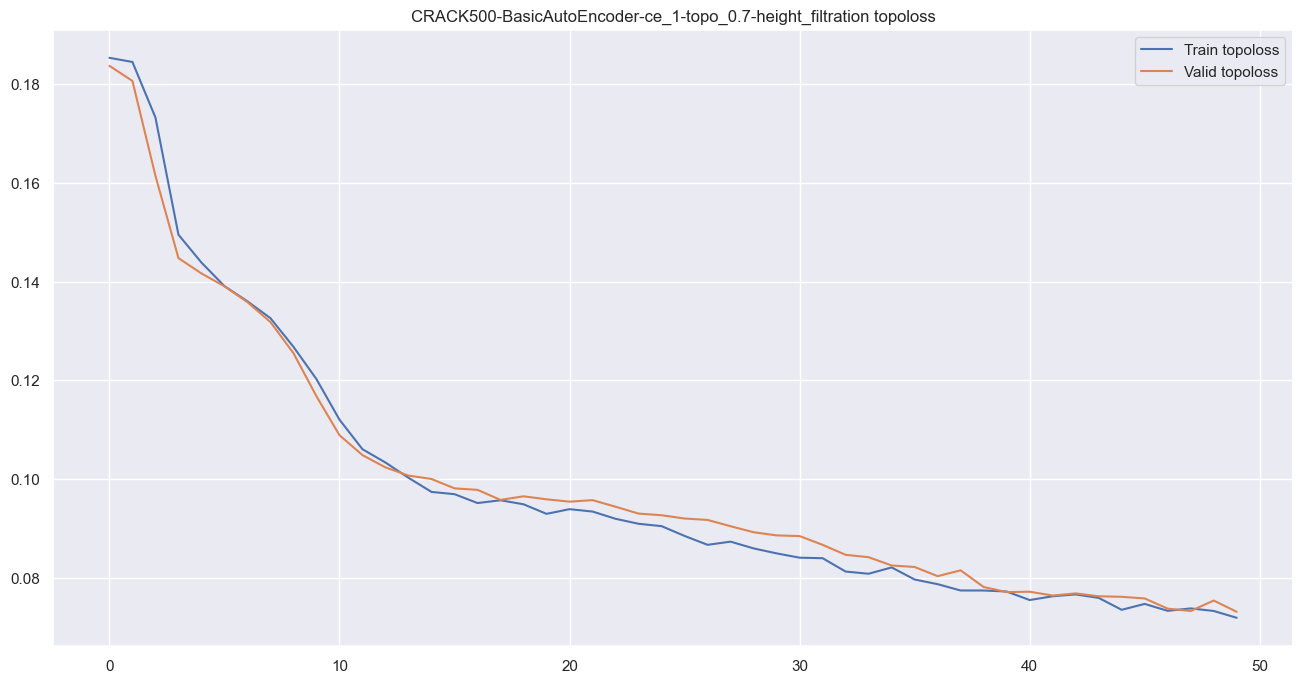

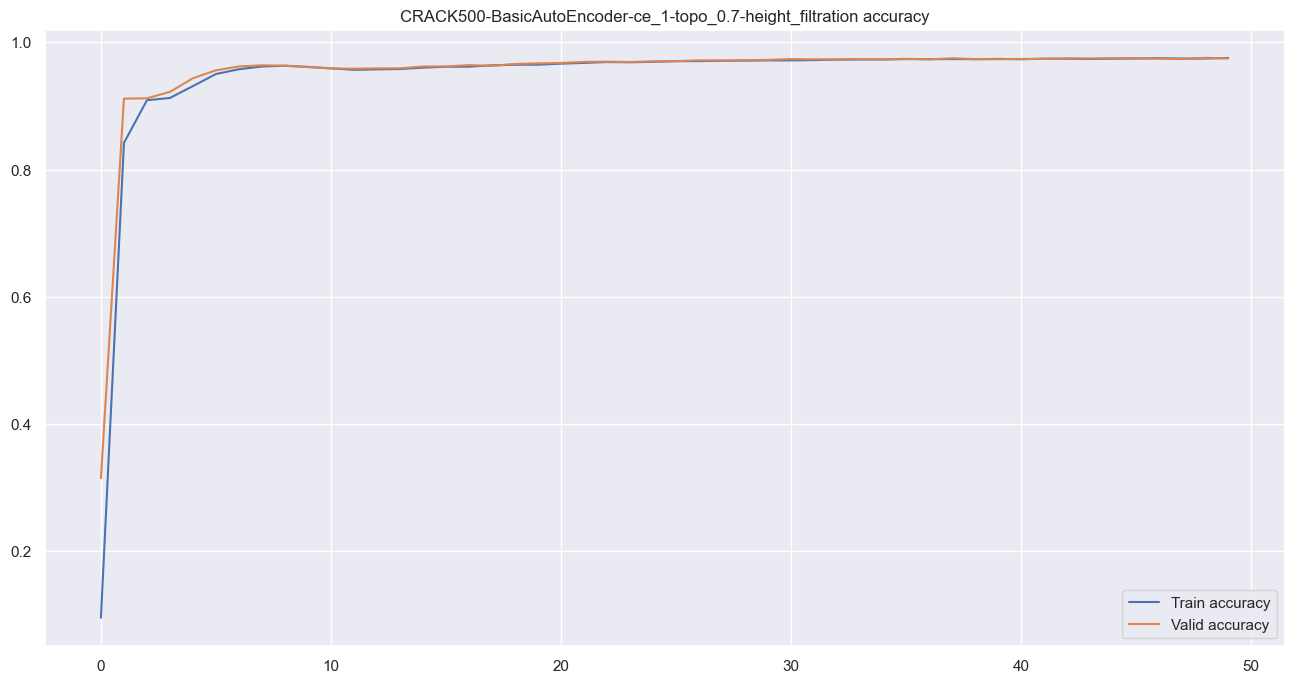

Epoch 49
 train loss: {'total': 0.11334023444378828, 'cross_entropy': 0.06304215383400438, 'topoloss': 0.07185440087111981}, train metrics: {'accuracy': 0.9754307771870545}
 val loss: {'total': 0.11557881964450904, 'cross_entropy': 0.06442977334448485, 'topoloss': 0.07307006614289176}, val metrics: {'accuracy': 0.974572793915733, 'betti_number_error': 0.7034358047016275, 'betti_number_error_0': 0.45569620253164556, 'betti_number_error_1': 0.24773960216998192}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [32]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.7,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.7-{config['filtration']}_filtration"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, 1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [33]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_7e-1_height_filtration.pt")

100%|██████████| 18/18 [00:07<00:00,  2.30it/s]


{'accuracy': 0.972631991555114, 'betti_number_error': 0.7509025270758123, 'betti_number_error_0': 0.49097472924187724, 'betti_number_error_1': 0.259927797833935}


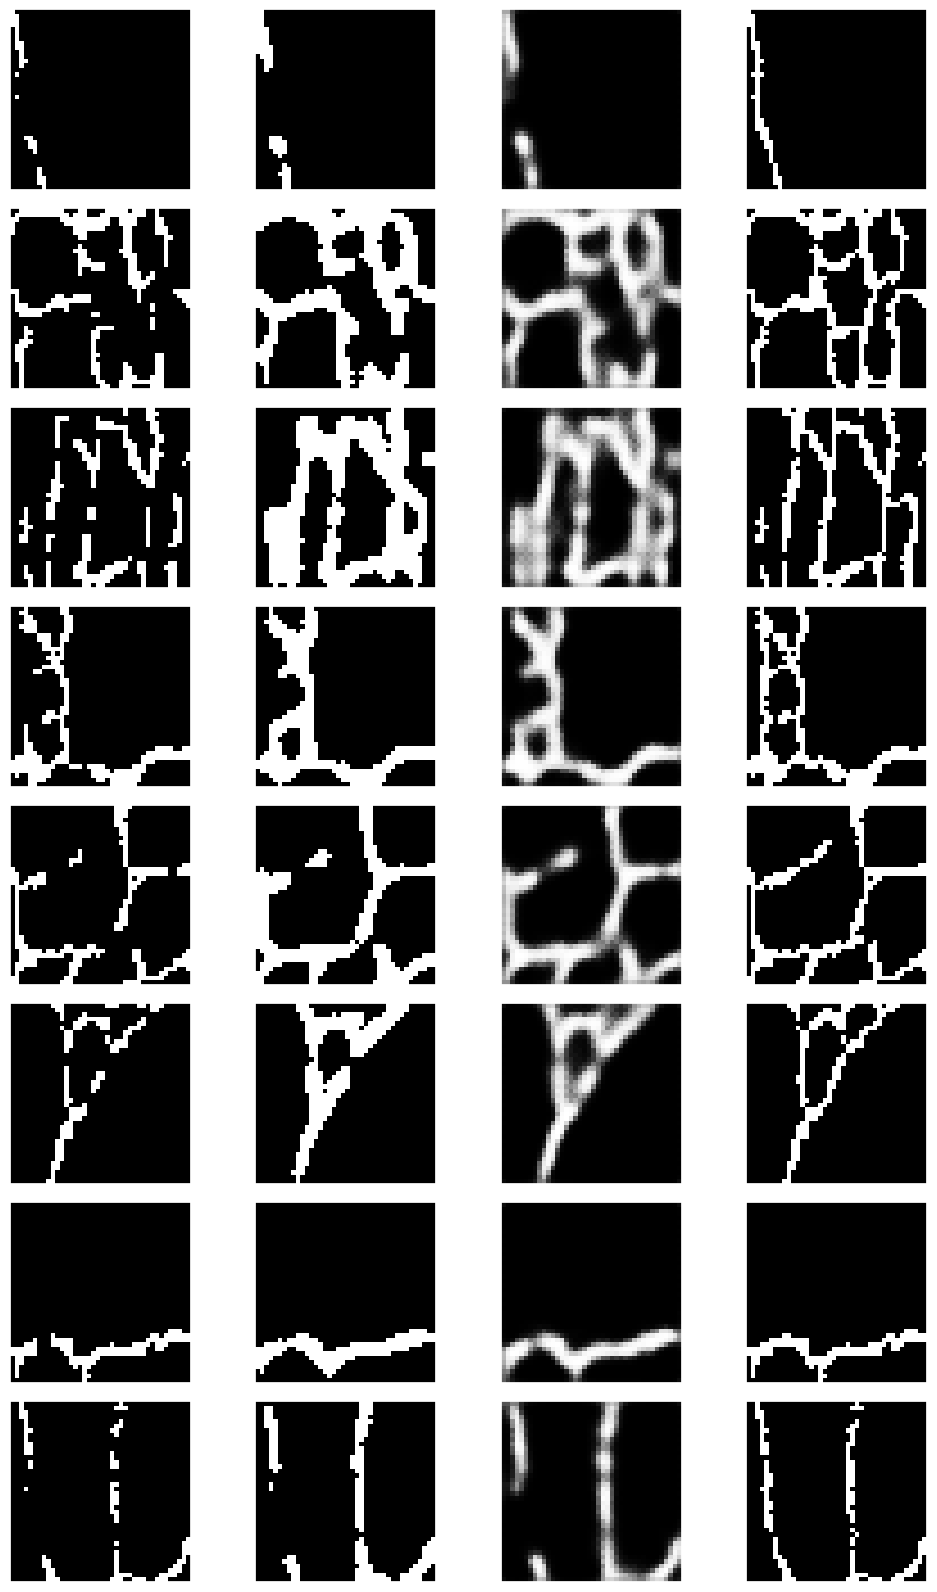

In [34]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_7e-1_height_filtration.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda = 0.1$ & Height Filtration $v = (1, 1)$ & lr = 1e-3

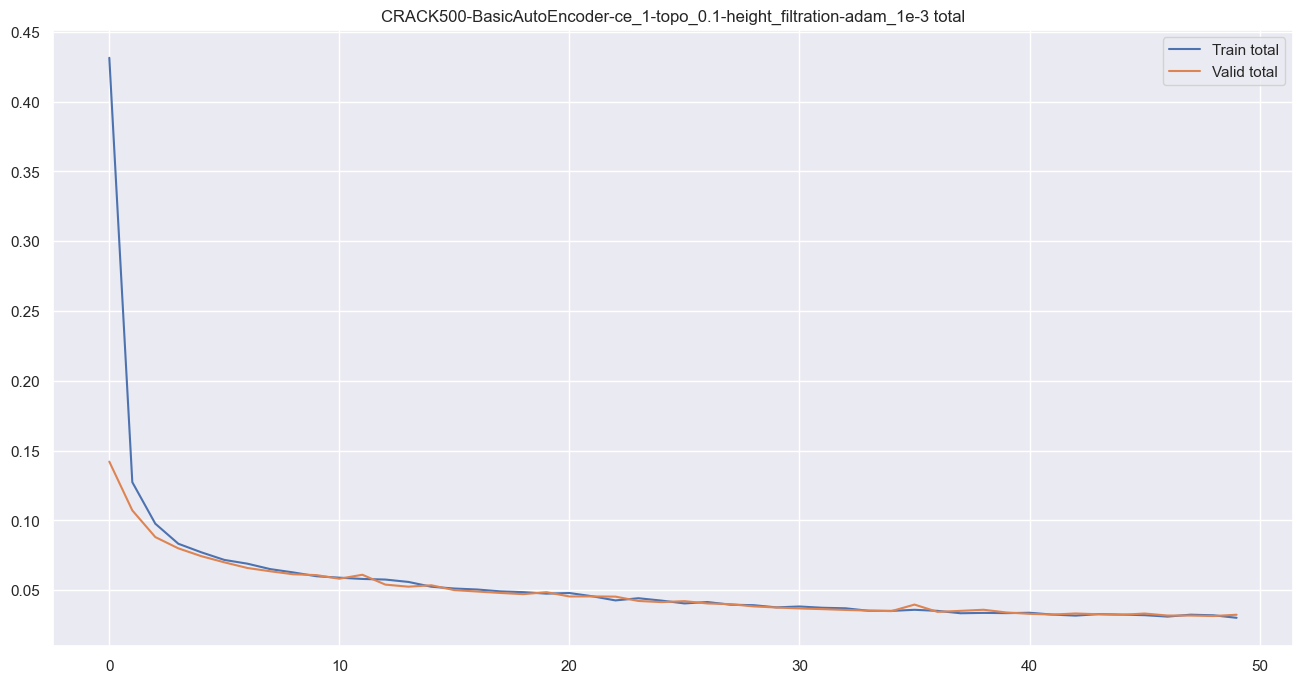

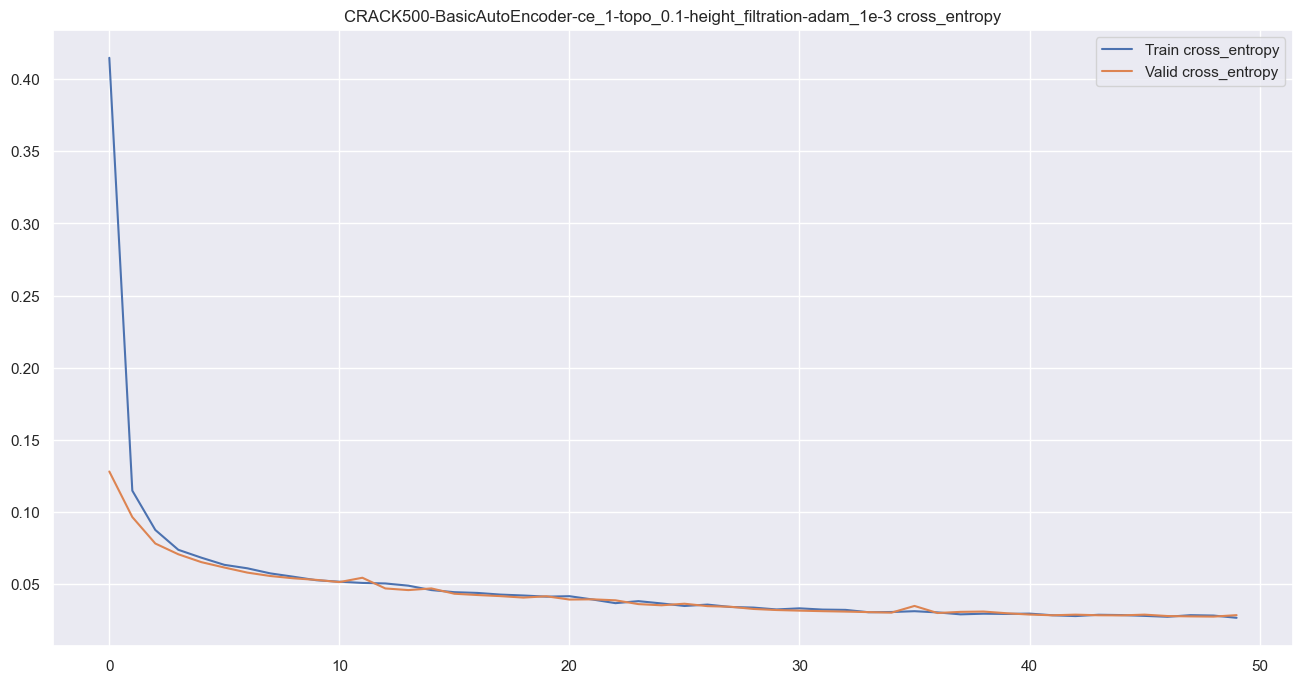

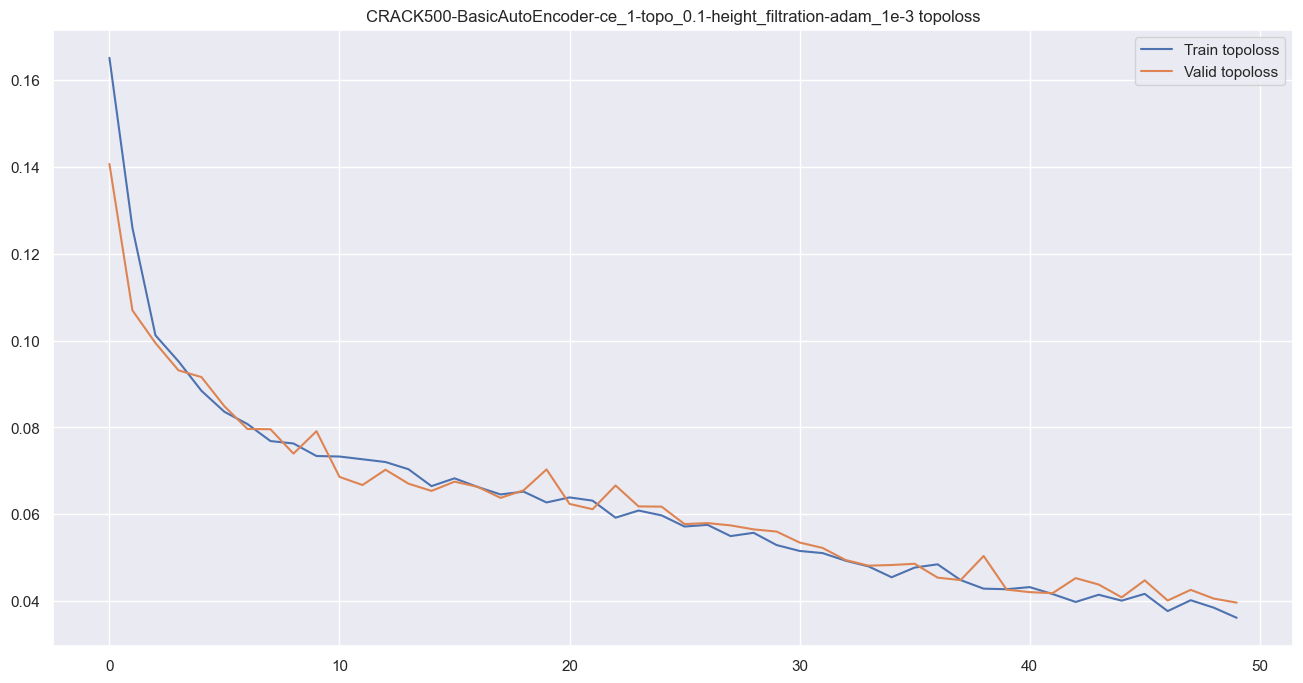

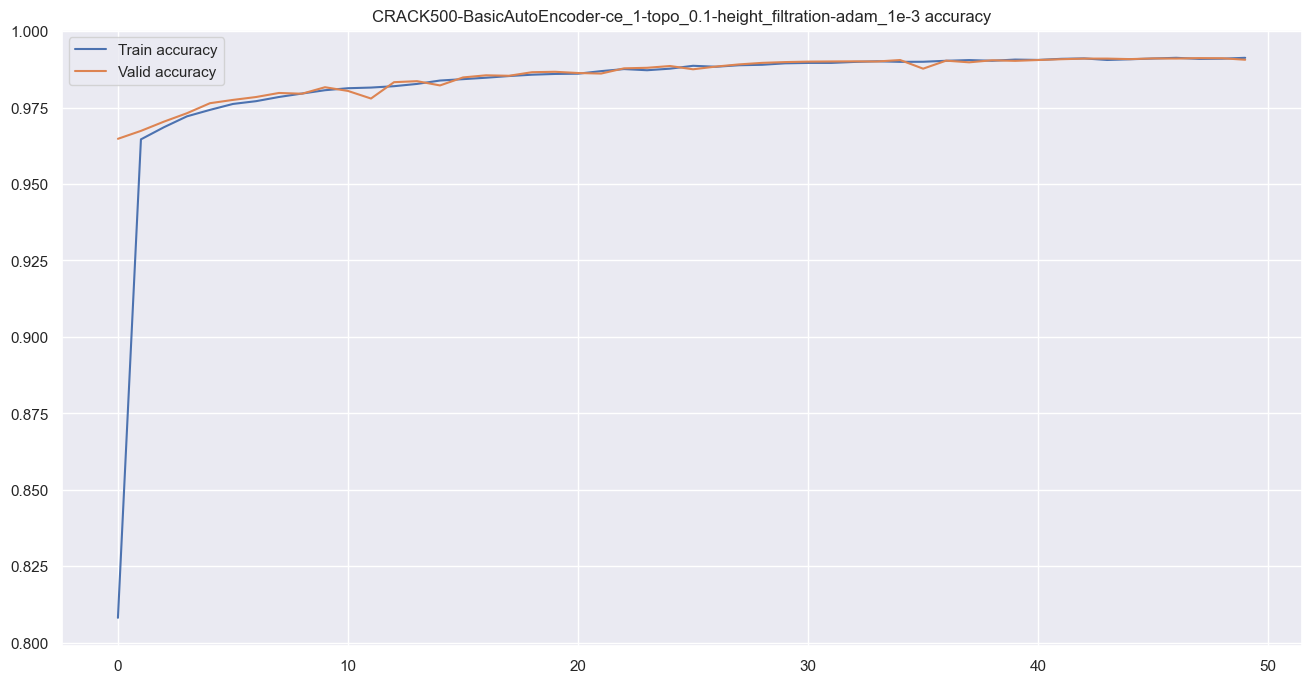

Epoch 49
 train loss: {'total': 0.030249894845665704, 'cross_entropy': 0.02663611681911465, 'topoloss': 0.03613778026551046}, train metrics: {'accuracy': 0.9912742762923133}
 val loss: {'total': 0.03244402415080089, 'cross_entropy': 0.02848061197058417, 'topoloss': 0.03963412180216707}, val metrics: {'accuracy': 0.9906408178870976, 'betti_number_error': 0.4394213381555154, 'betti_number_error_0': 0.25678119349005424, 'betti_number_error_1': 0.18264014466546113}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: ERROR Control-C detected -- Run data was not synced


In [35]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=32,
    epochs=50,
    lr=1e-3,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['filtration']}_filtration-adam_1e-3"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, 1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [36]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_1e-1_height_filtration_adam_1e-3.pt")

100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


{'accuracy': 0.9896874995868559, 'betti_number_error': 0.5126353790613718, 'betti_number_error_0': 0.30505415162454874, 'betti_number_error_1': 0.2075812274368231}


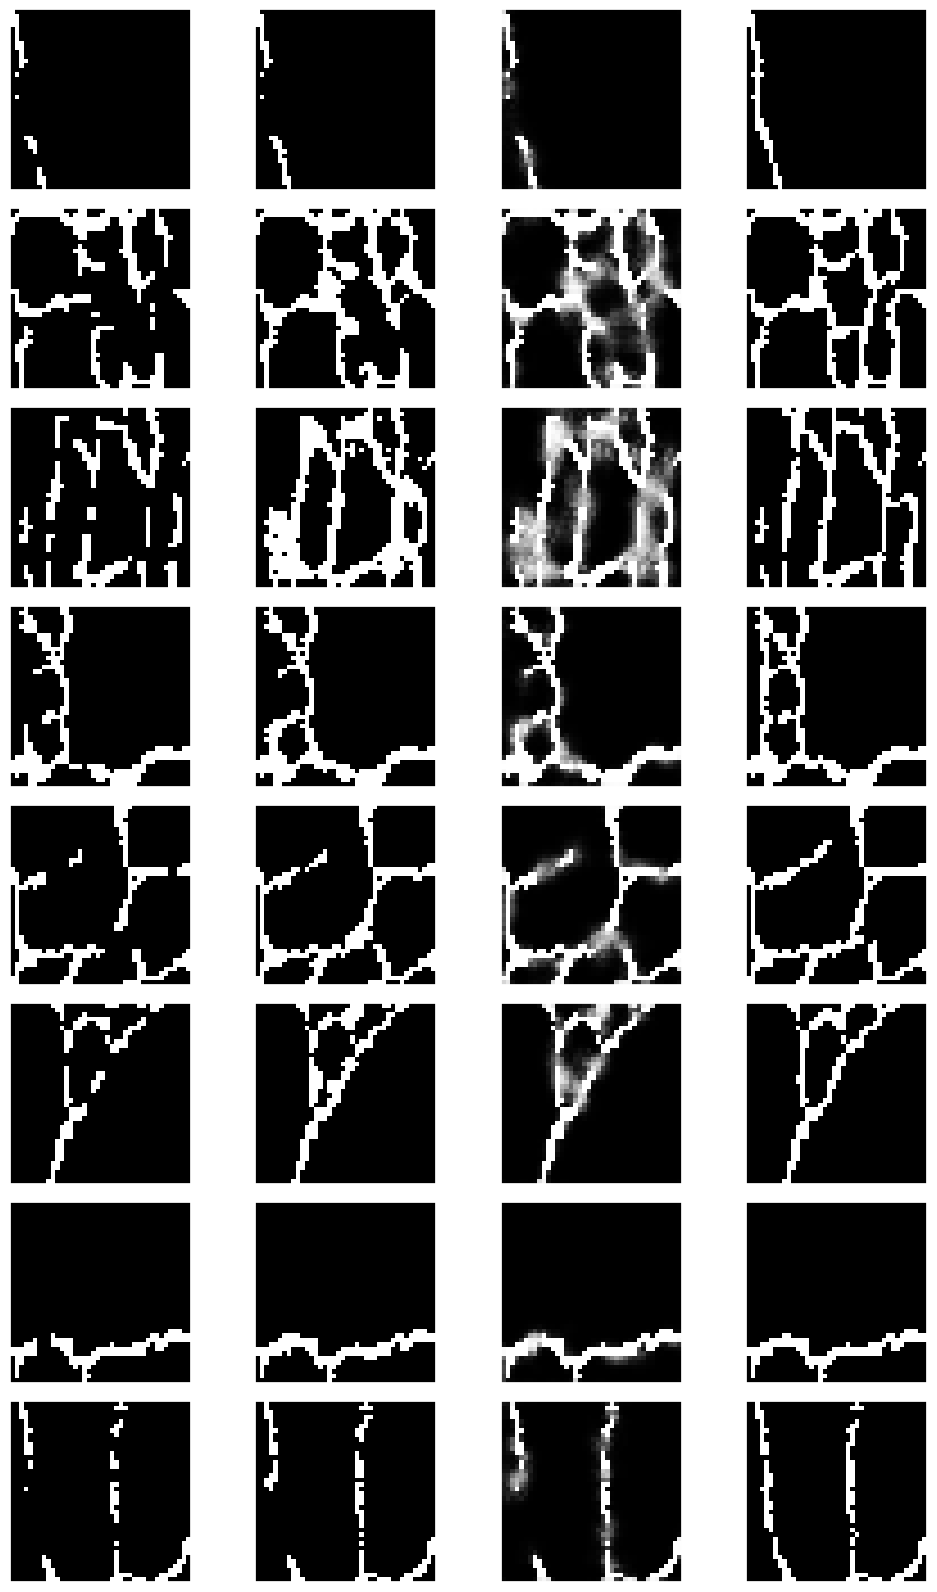

In [37]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_1e-1_height_filtration_adam_1e-3.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### Only BCELoss & lr=1e-3

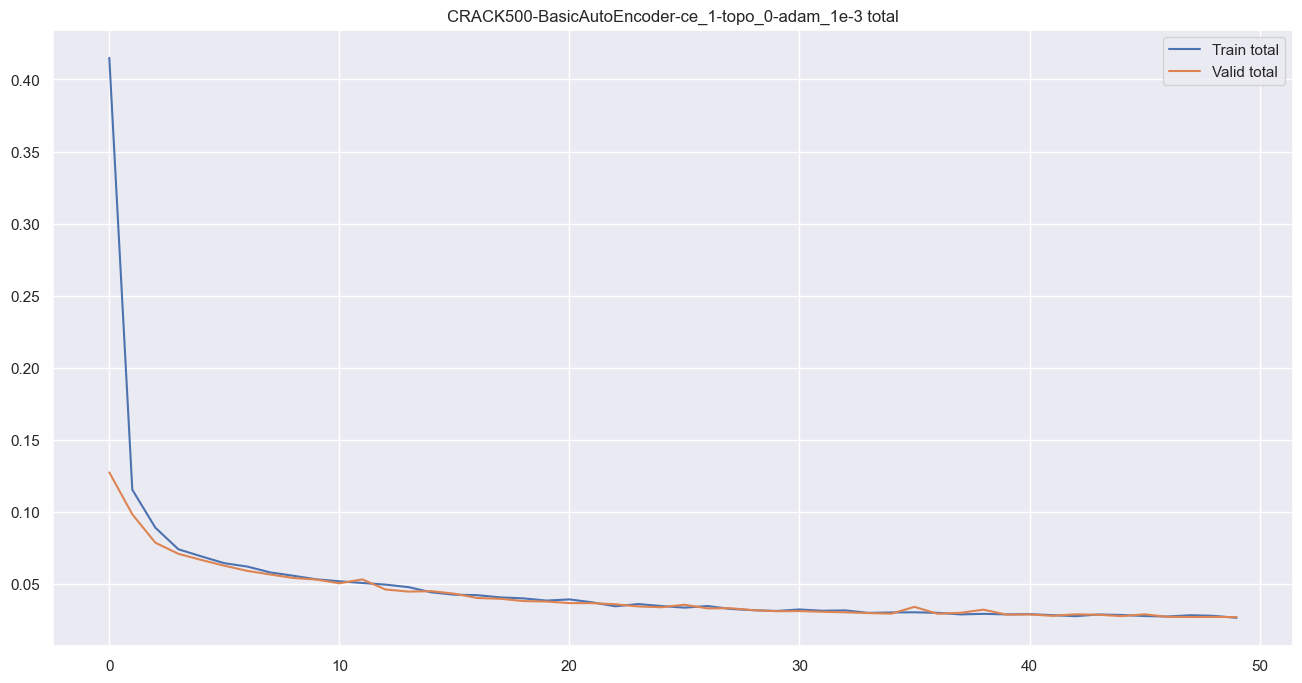

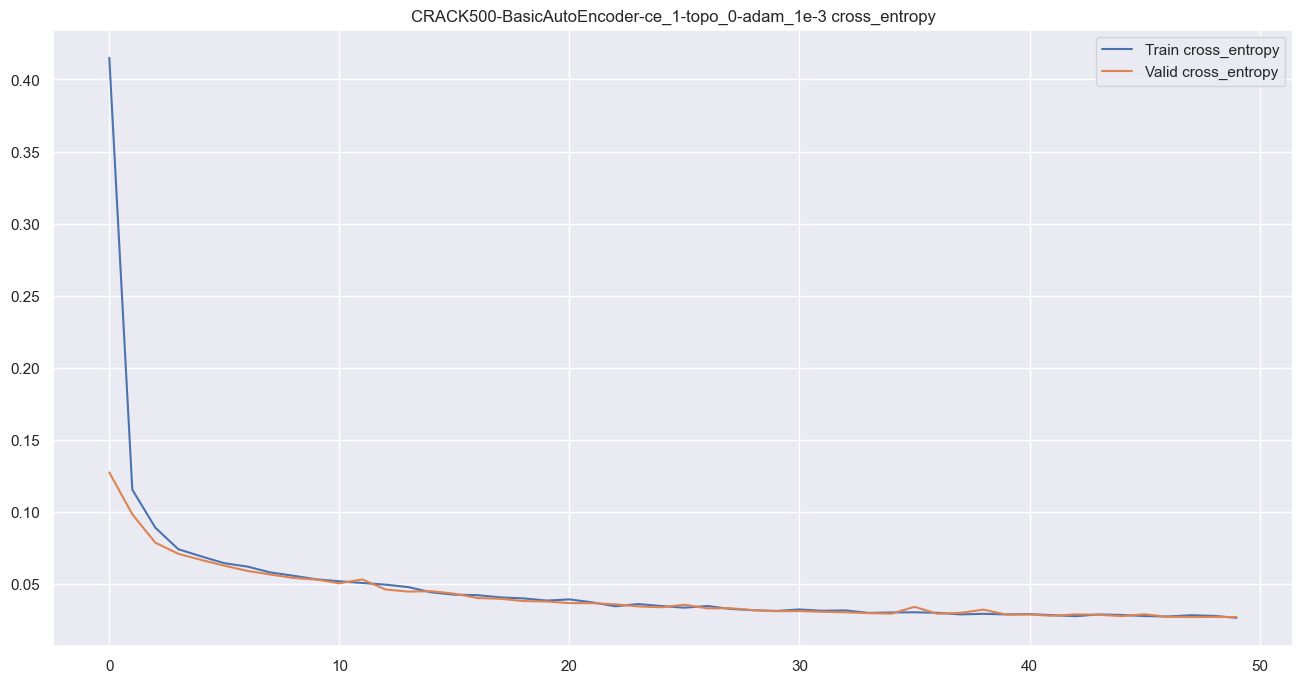

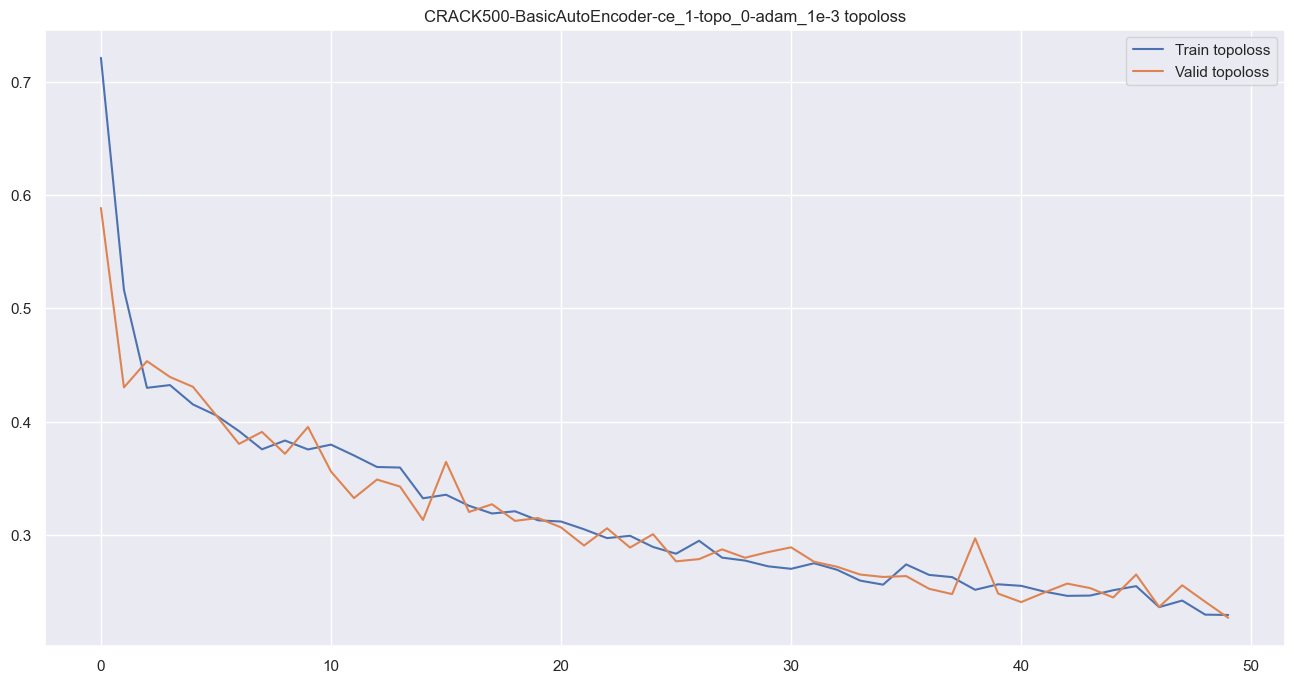

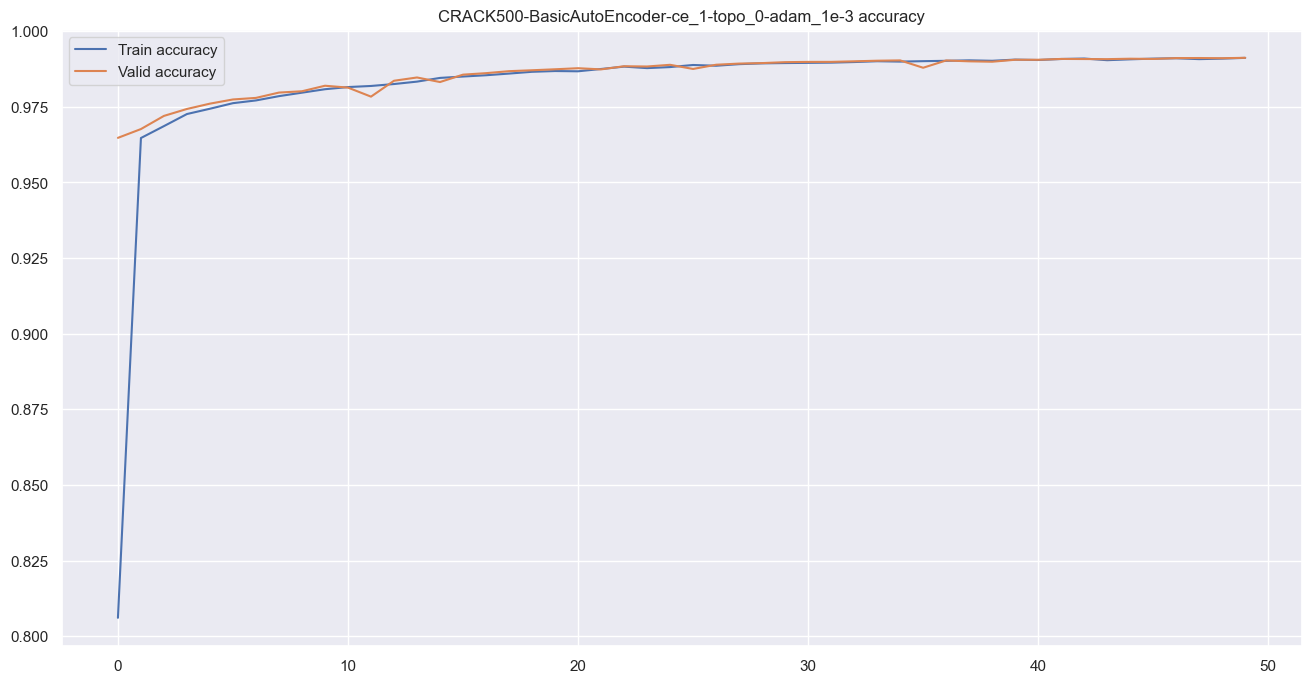

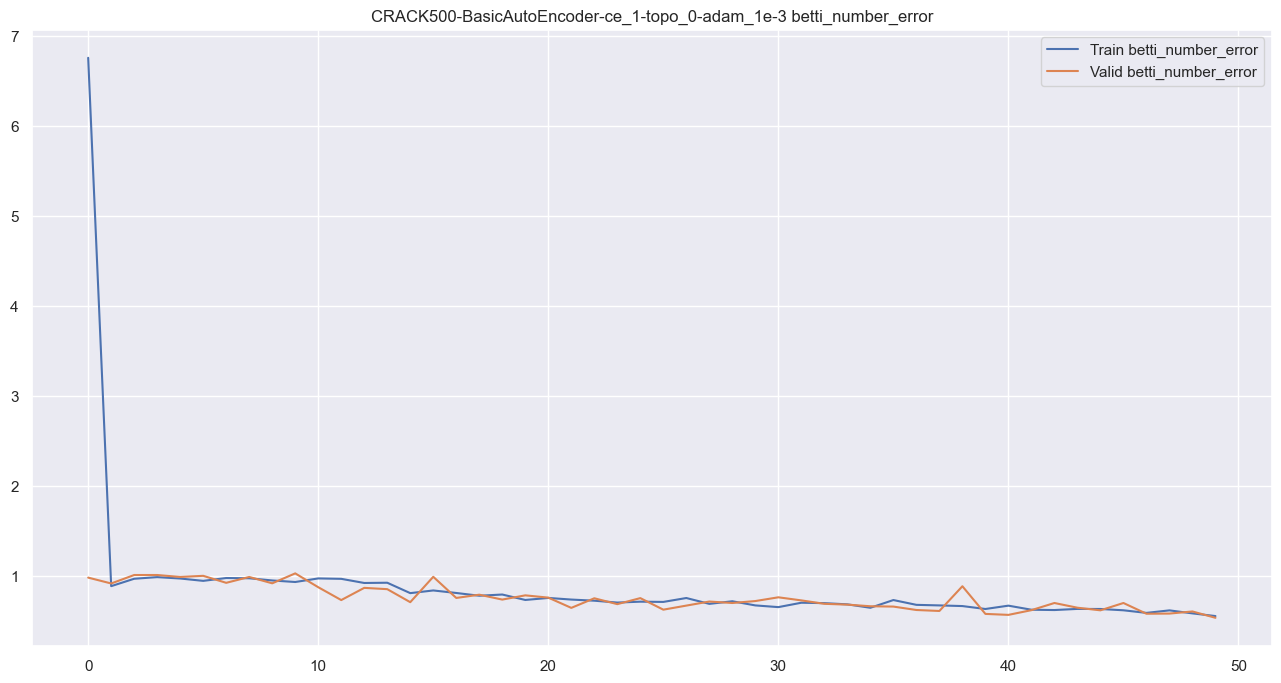

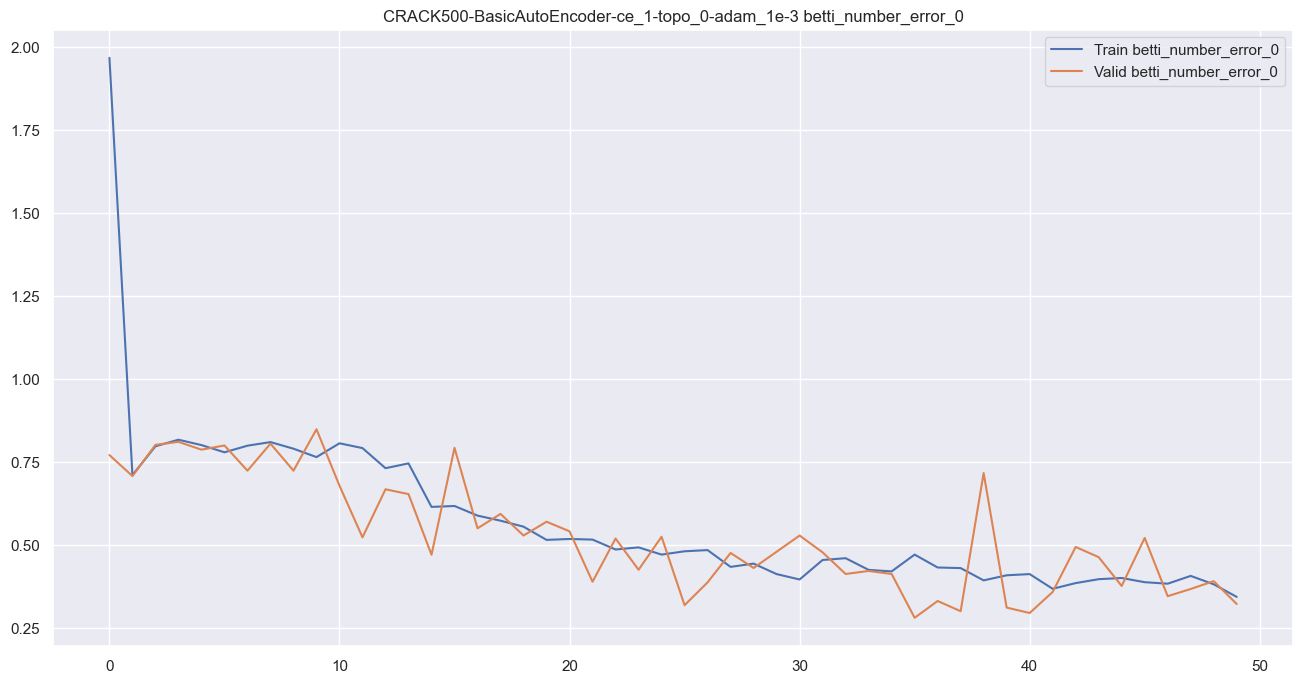

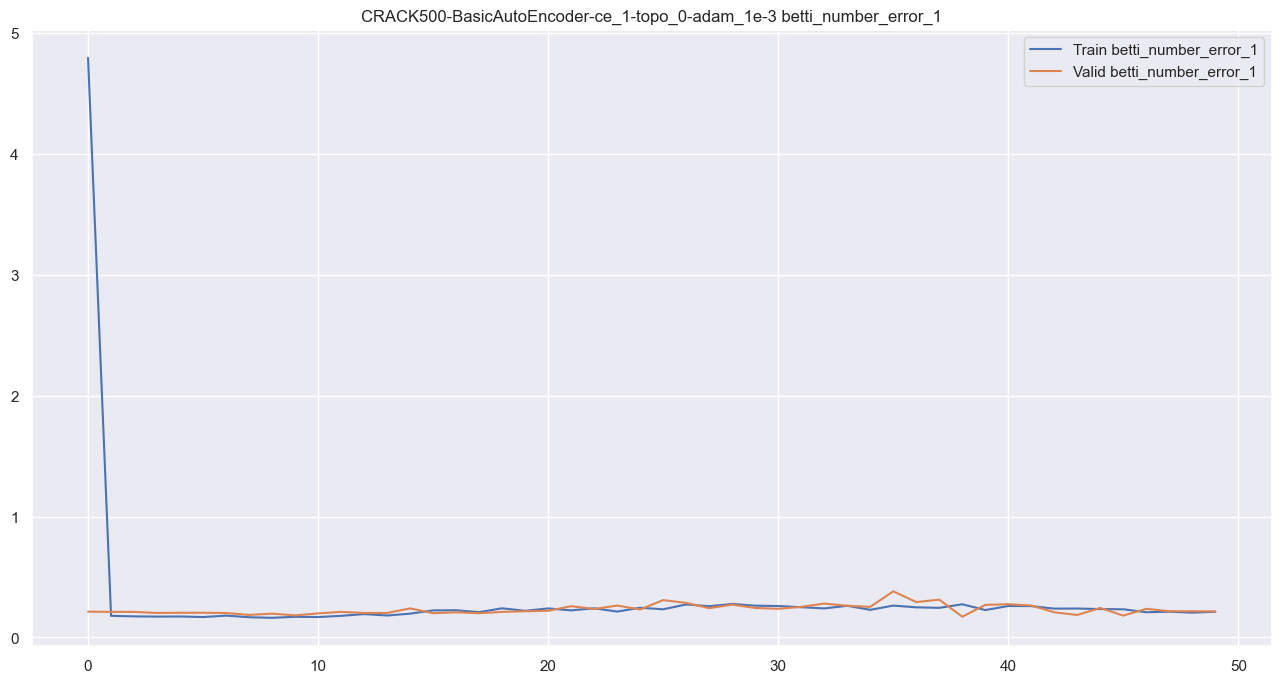

Epoch 49
 train loss: {'total': 0.026726378038754415, 'cross_entropy': 0.026726378038754415, 'topoloss': 0.2293930805364814}, train metrics: {'accuracy': 0.9911782765237728, 'betti_number_error': 0.5564588979223125, 'betti_number_error_0': 0.34327009936766034, 'betti_number_error_1': 0.21318879855465223}
 val loss: {'total': 0.027209553968626163, 'cross_entropy': 0.027209553968626163, 'topoloss': 0.22689214839210994}, val metrics: {'accuracy': 0.9911980085735079, 'betti_number_error': 0.5370705244122965, 'betti_number_error_0': 0.321880650994575, 'betti_number_error_1': 0.21518987341772153}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [6]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0,
    batch_size=32,
    epochs=50,
    lr=1e-3,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0-{config['optimizer']}_1e-3"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, save_checkpoints=False, save_path="", log_wandb=True)

In [7]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_adam_1e-3.pt")

100%|██████████| 18/18 [00:07<00:00,  2.27it/s]


{'accuracy': 0.990192915988743, 'betti_number_error': 0.6678700361010831, 'betti_number_error_0': 0.42418772563176893, 'betti_number_error_1': 0.24368231046931407}


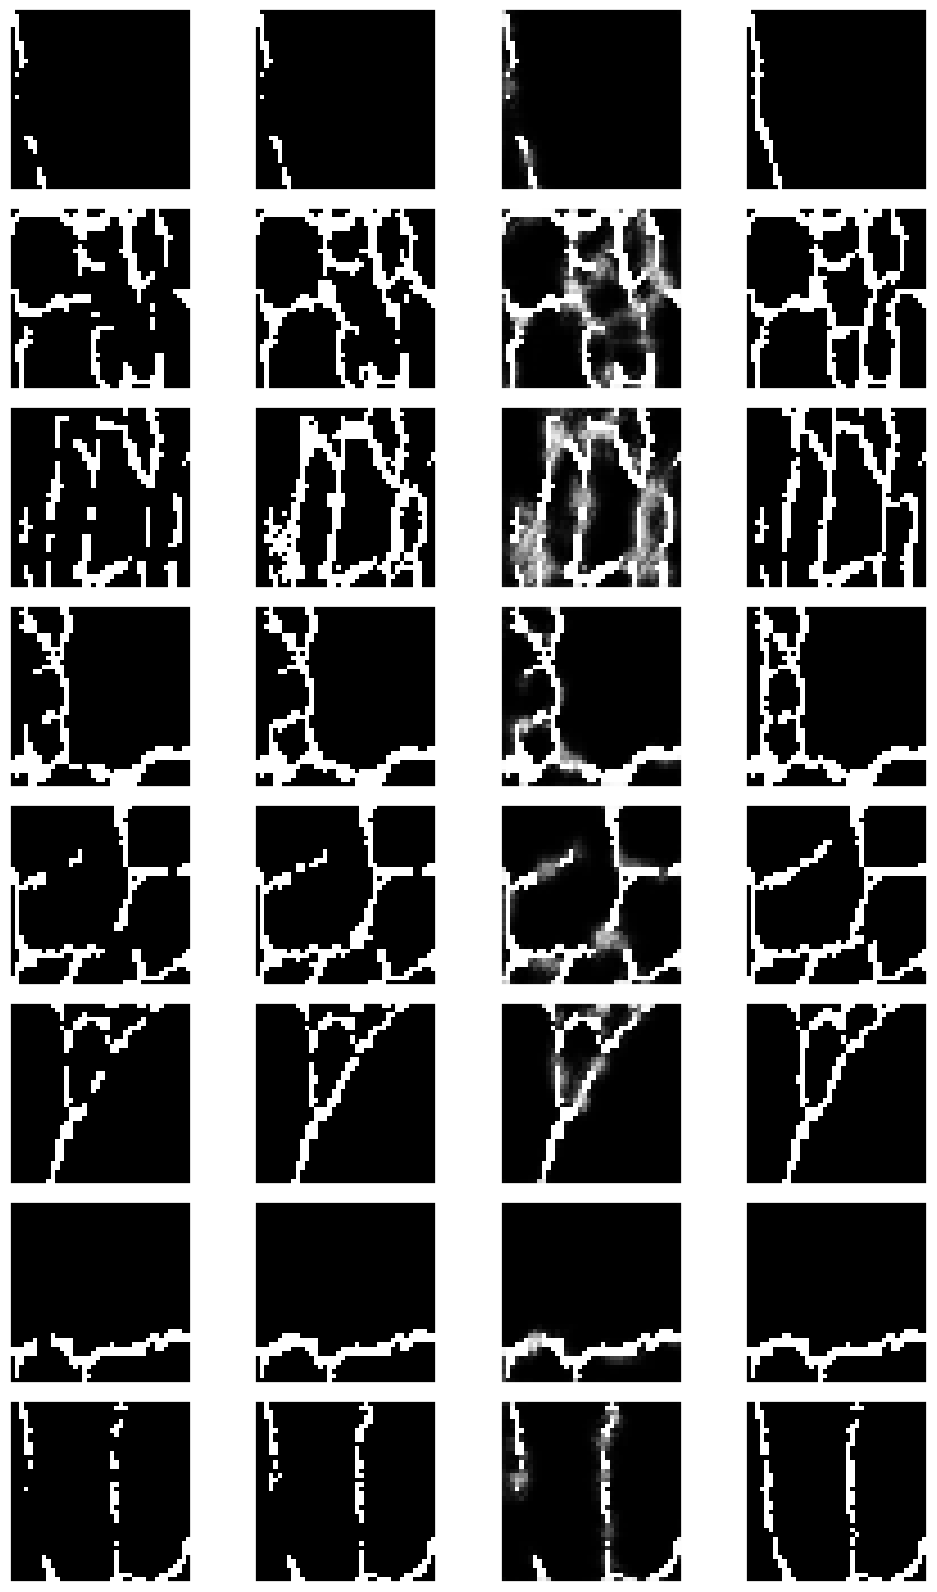

In [8]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_adam_1e-3.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda = 0.1$ & lr = 1e-3

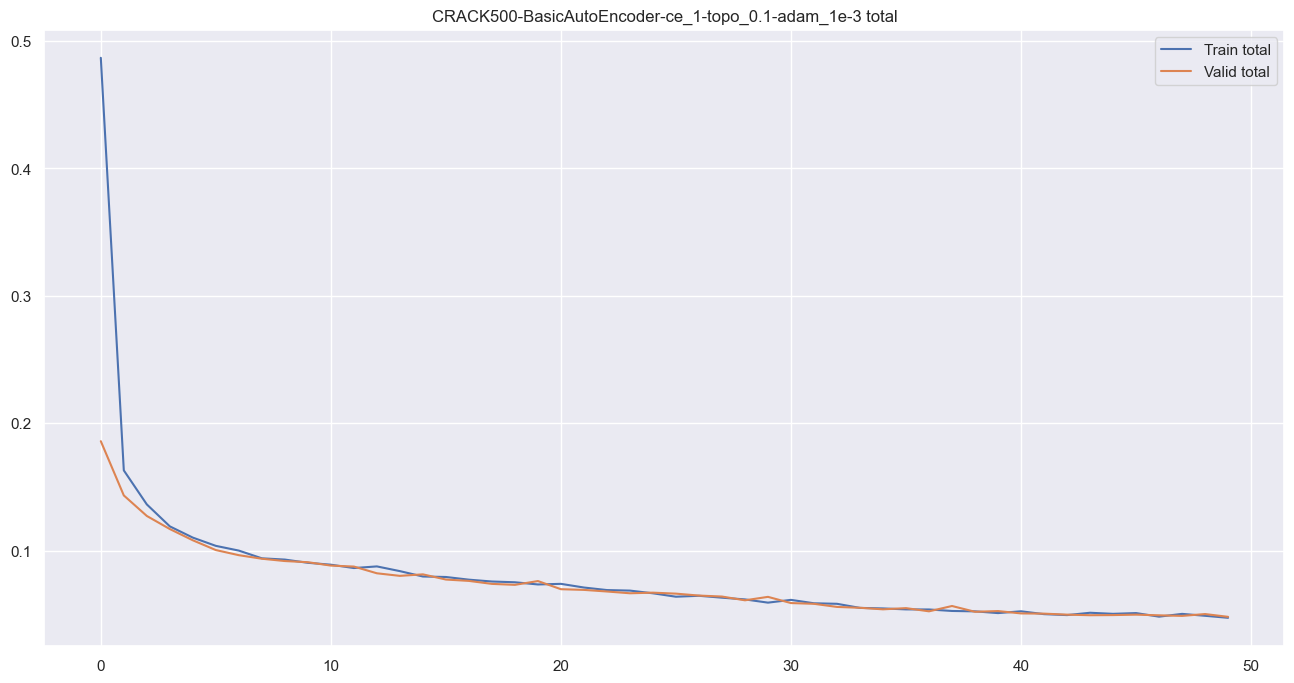

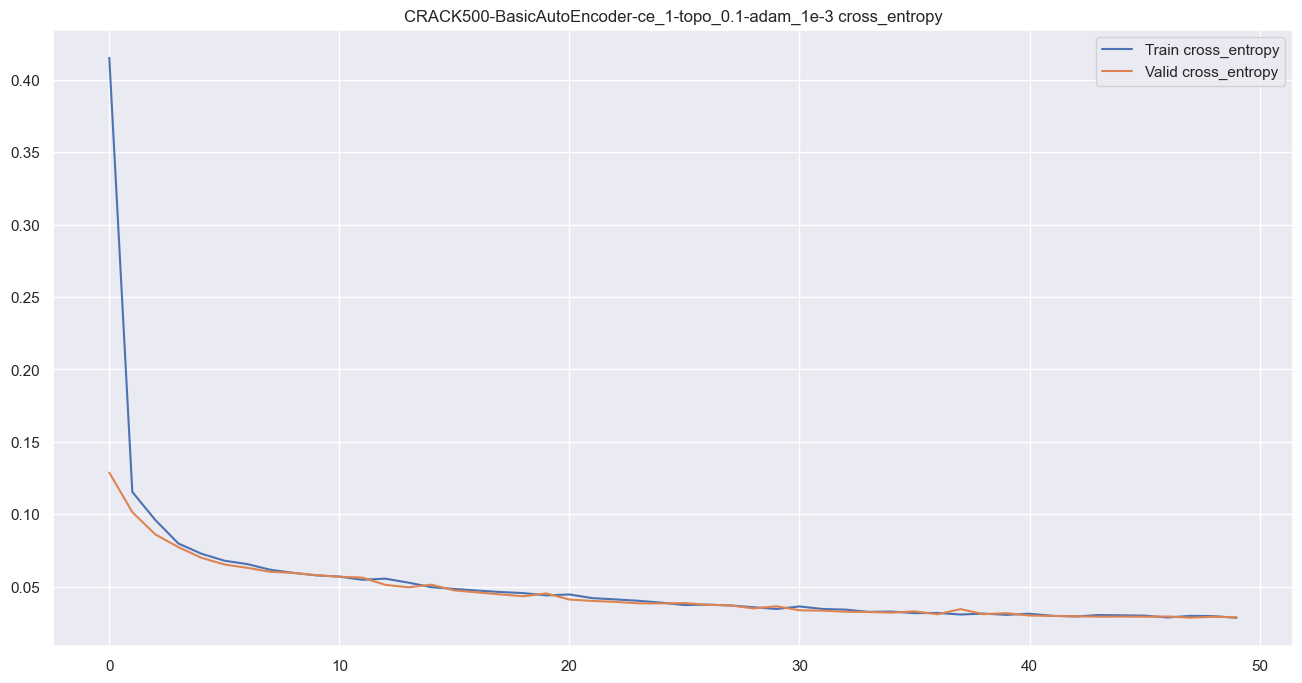

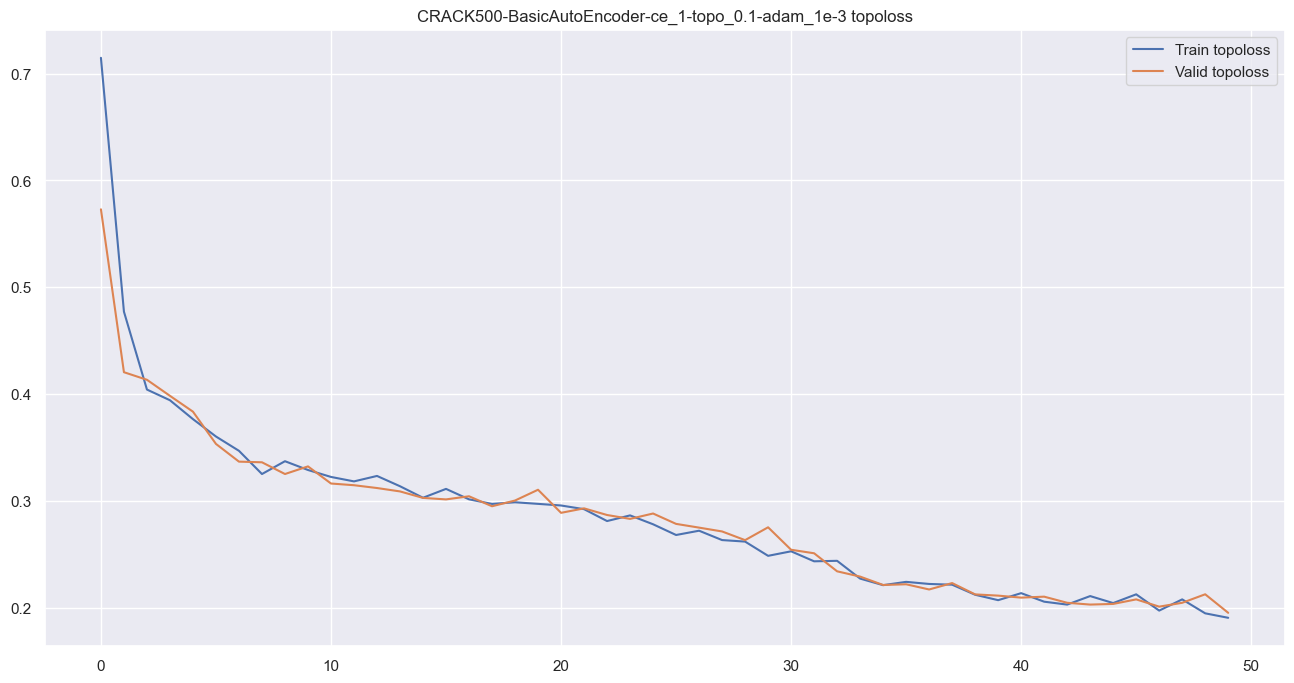

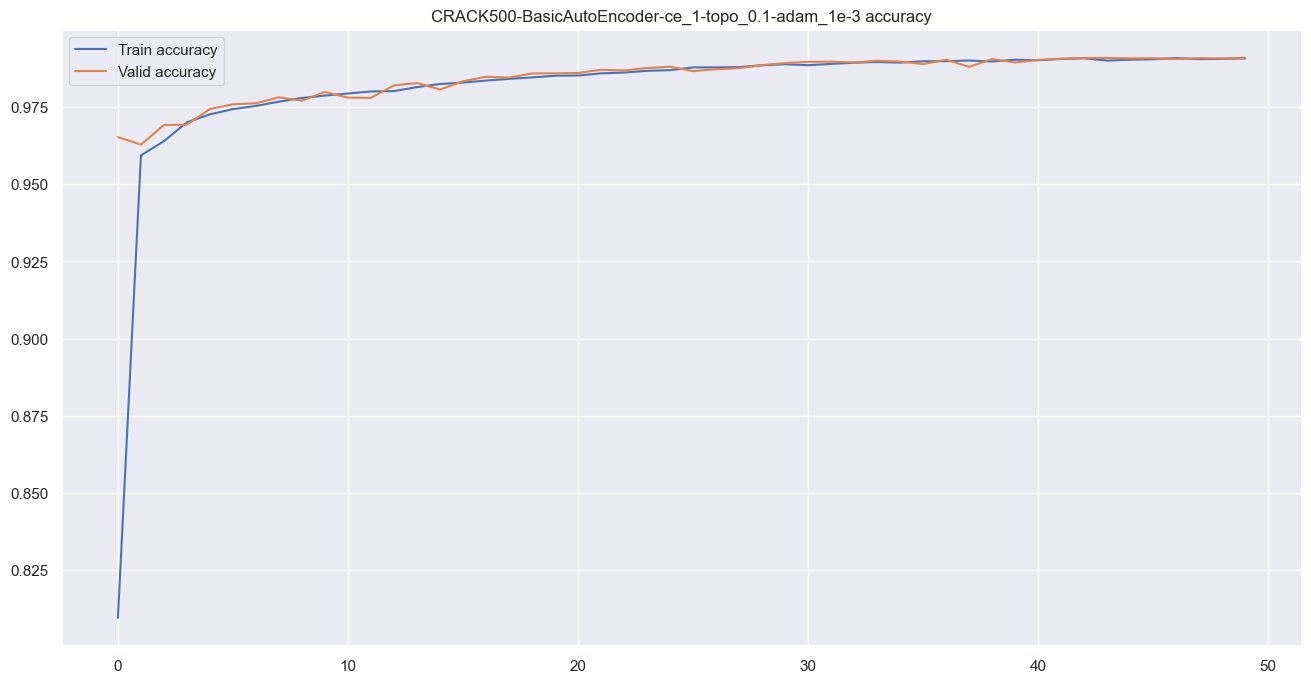

Epoch 49
 train loss: {'total': 0.04744400855325425, 'cross_entropy': 0.02839304936179839, 'topoloss': 0.19050958895317152}, train metrics: {'accuracy': 0.9907497795401334}
 val loss: {'total': 0.04819964392491318, 'cross_entropy': 0.028682316028619113, 'topoloss': 0.1951732764839048}, val metrics: {'accuracy': 0.9909324163123022, 'betti_number_error': 0.4177215189873418, 'betti_number_error_0': 0.26763110307414106, 'betti_number_error_1': 0.15009041591320071}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [10]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=32,
    epochs=50,
    lr=1e-3,
    optimizer="adam",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['optimizer']}_1e-3"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True)

In [11]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_1e-1_adam_1e-3.pt")

100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


{'accuracy': 0.9897856488554917, 'betti_number_error': 0.5054151624548736, 'betti_number_error_0': 0.3231046931407942, 'betti_number_error_1': 0.18231046931407943}


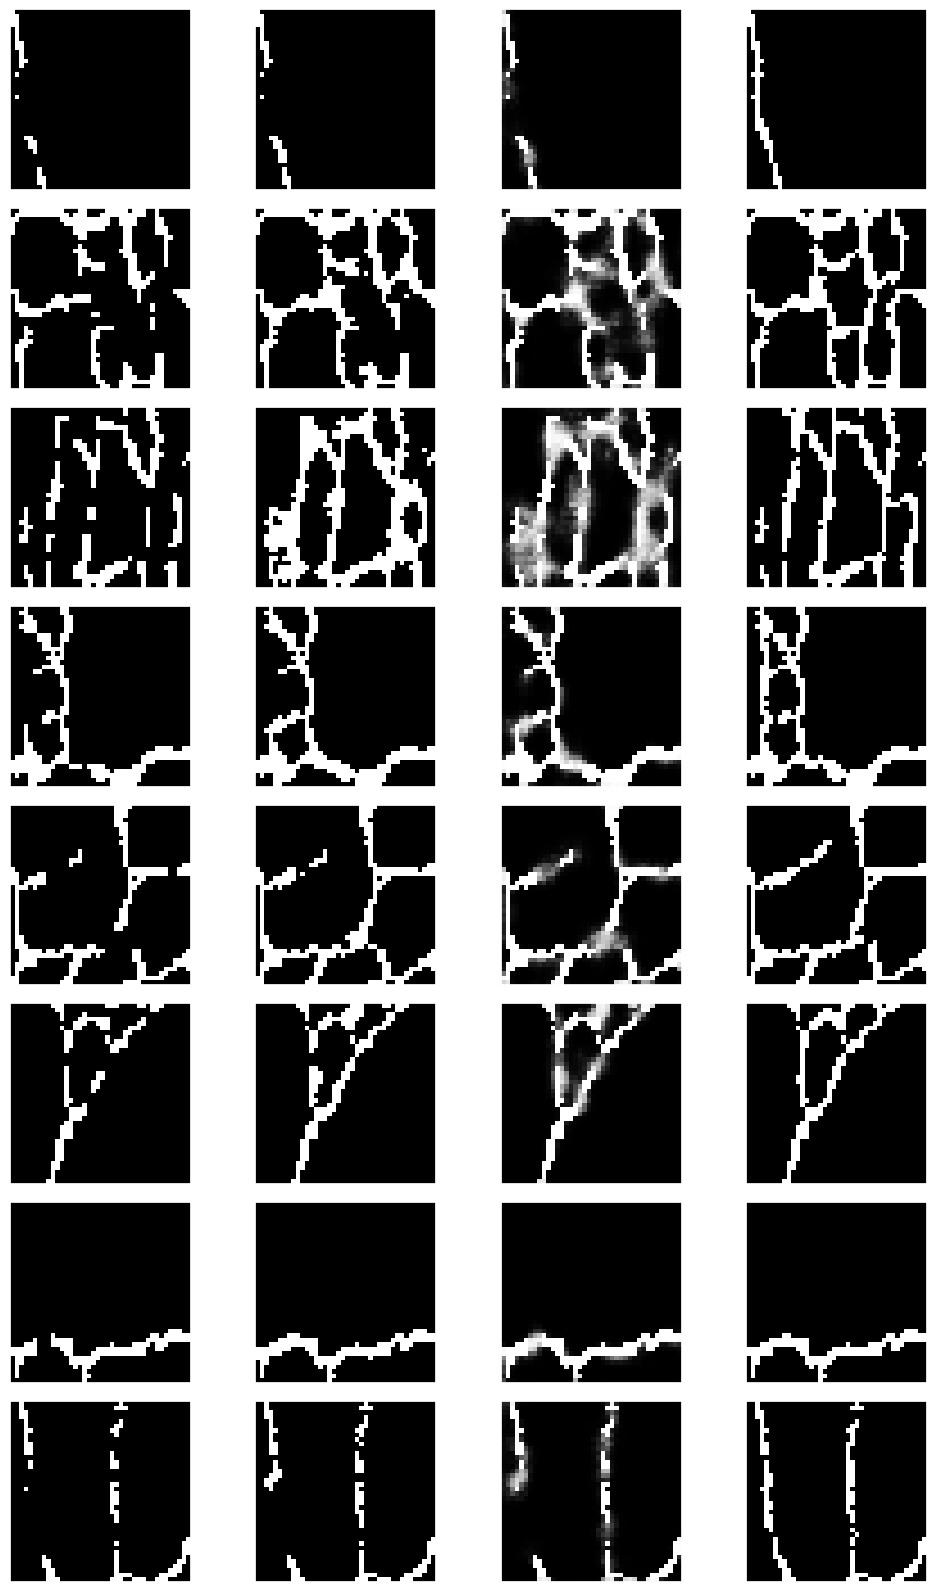

In [12]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_1e-1_adam_1e-3.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda=0.1$ & Height Filtration $v = (1, 0)$

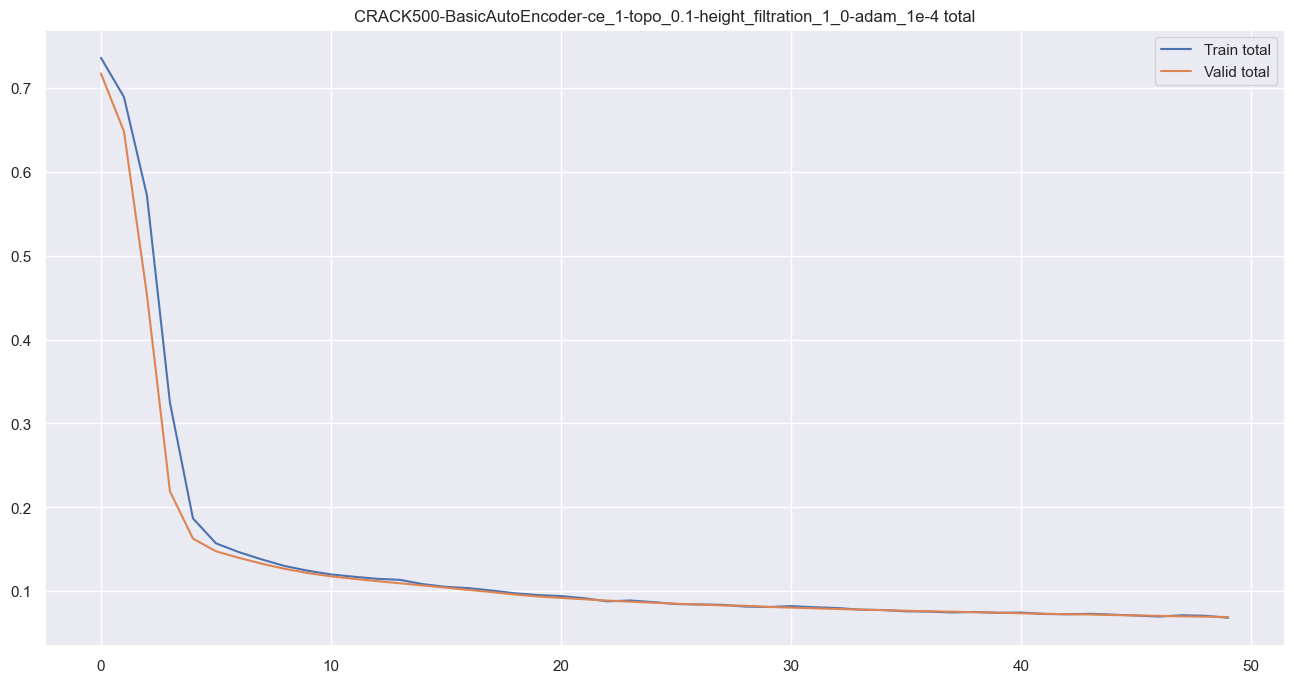

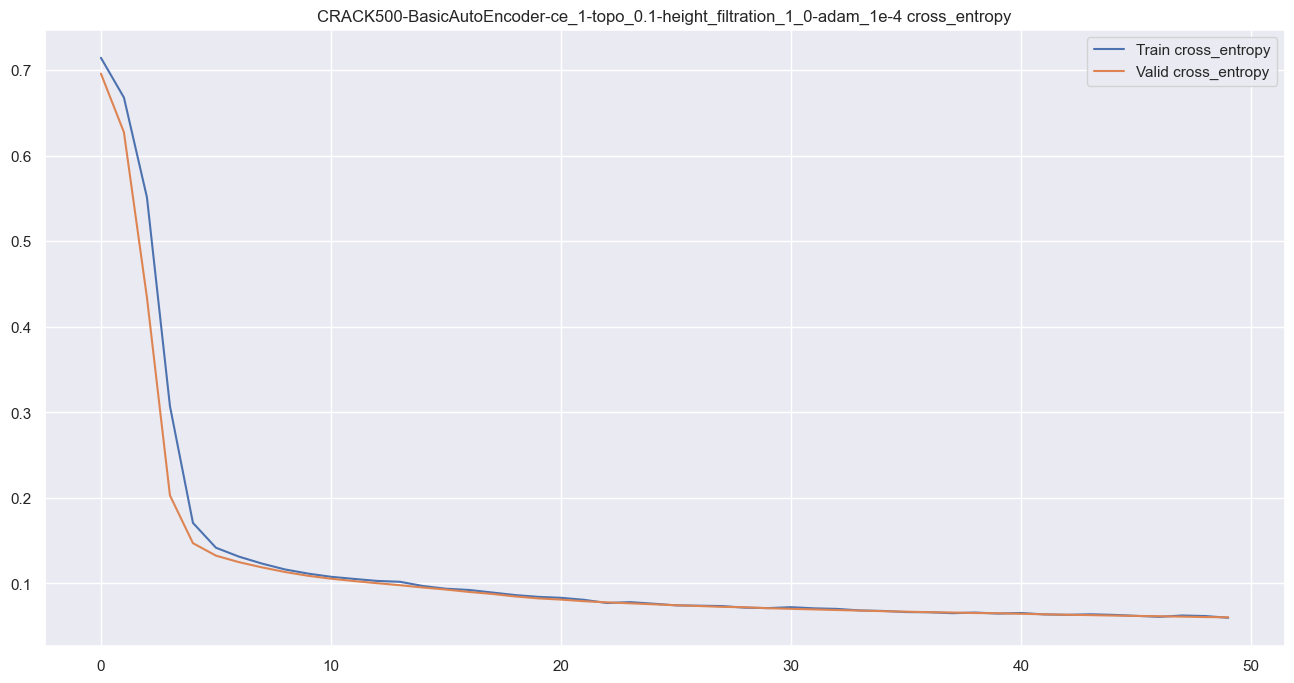

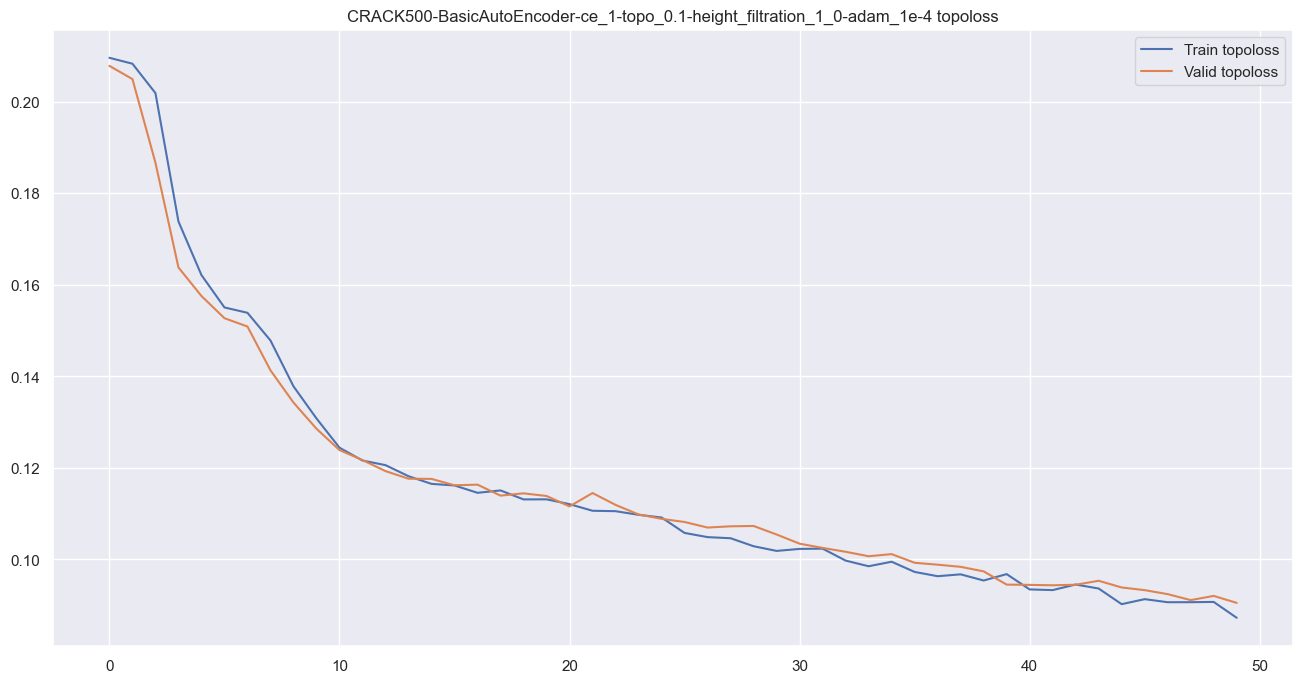

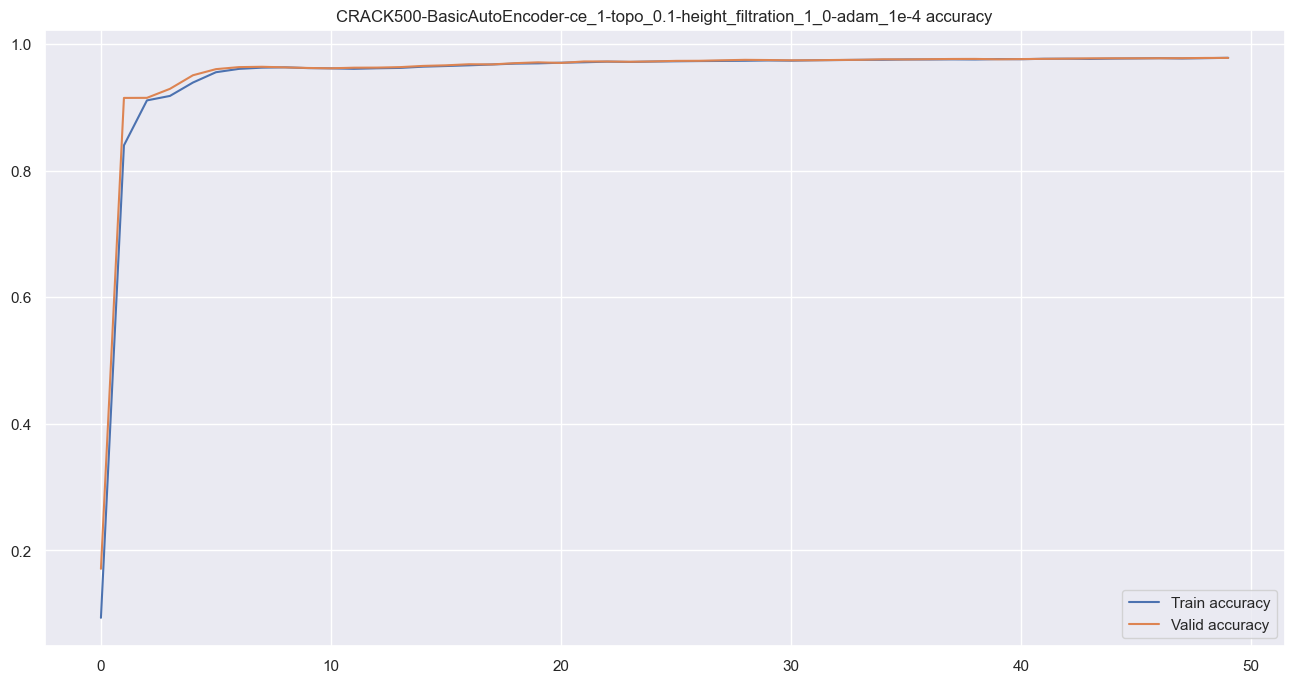

Epoch 49
 train loss: {'total': 0.06853205310560513, 'cross_entropy': 0.0598069183871675, 'topoloss': 0.08725134718437615}, train metrics: {'accuracy': 0.978004176442216}
 val loss: {'total': 0.06945776982038161, 'cross_entropy': 0.06040641315160134, 'topoloss': 0.09051356668780274}, val metrics: {'accuracy': 0.977832287172728, 'betti_number_error': 0.8969258589511754, 'betti_number_error_0': 0.6853526220614828, 'betti_number_error_1': 0.2115732368896926}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [13]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['filtration']}_filtration_1_0-adam_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, 0]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [14]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_1e-1_height_filtration_1_0.pt")

100%|██████████| 18/18 [00:07<00:00,  2.28it/s]


{'accuracy': 0.9762251953786031, 'betti_number_error': 0.9945848375451264, 'betti_number_error_0': 0.7310469314079422, 'betti_number_error_1': 0.26353790613718414}


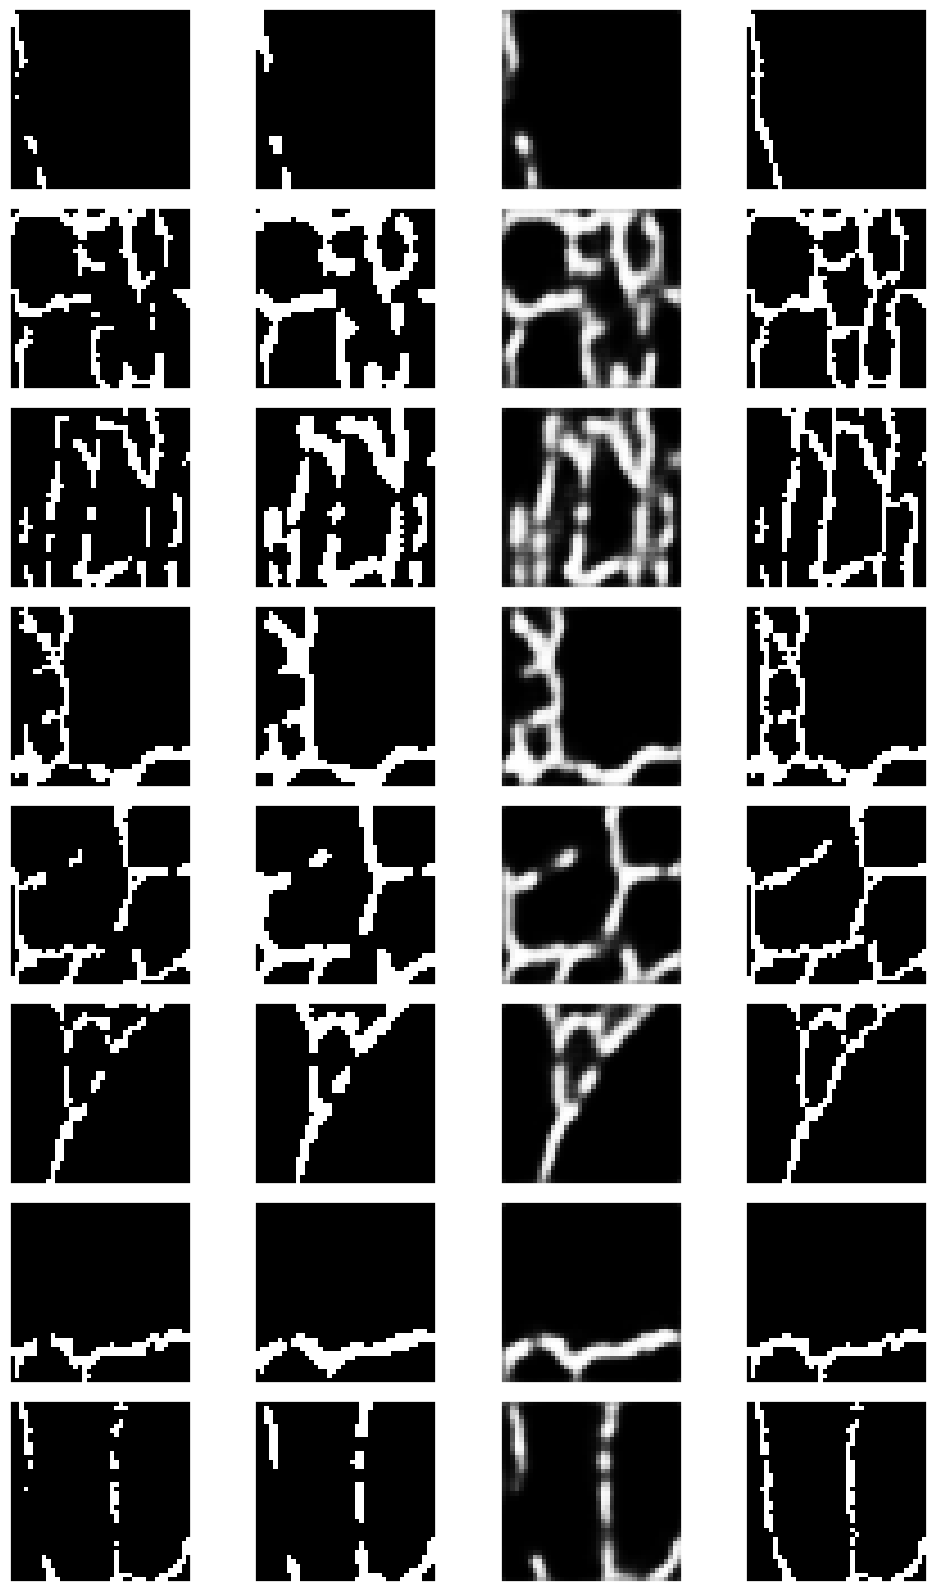

In [15]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_1e-1_height_filtration_1_0.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)

### $\lambda=0.1$ & Height Filtration $v = (1, -1)$

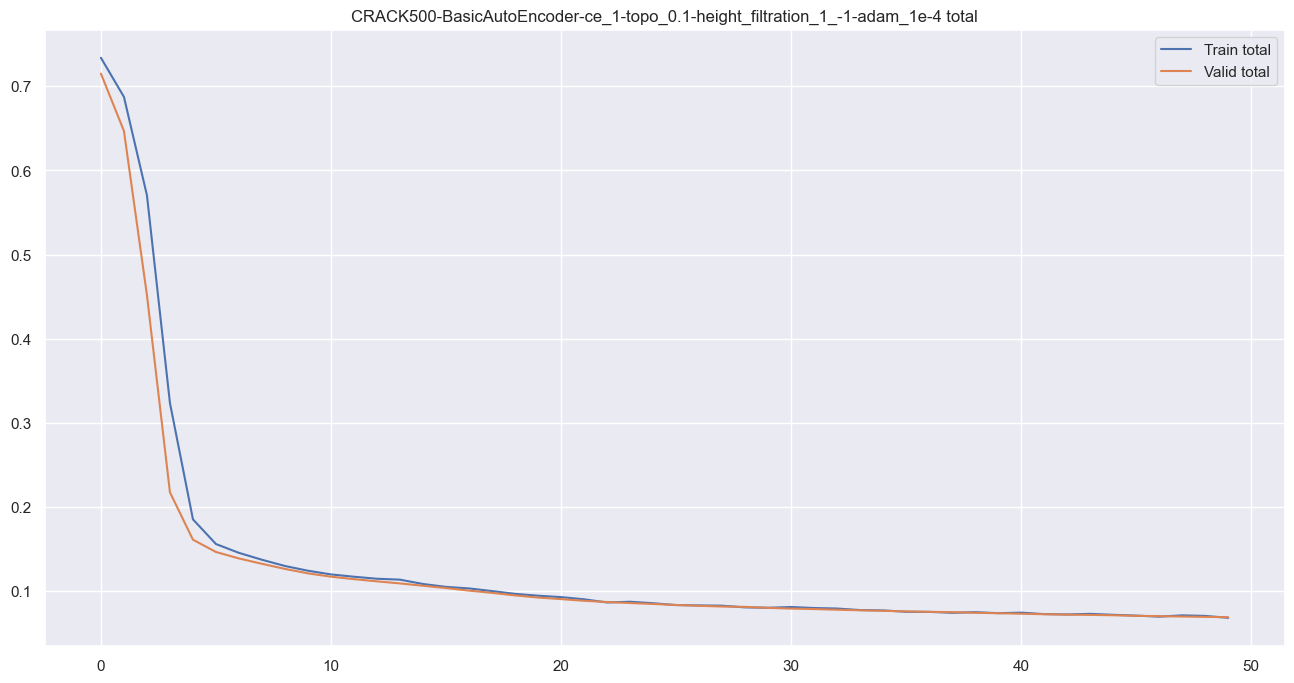

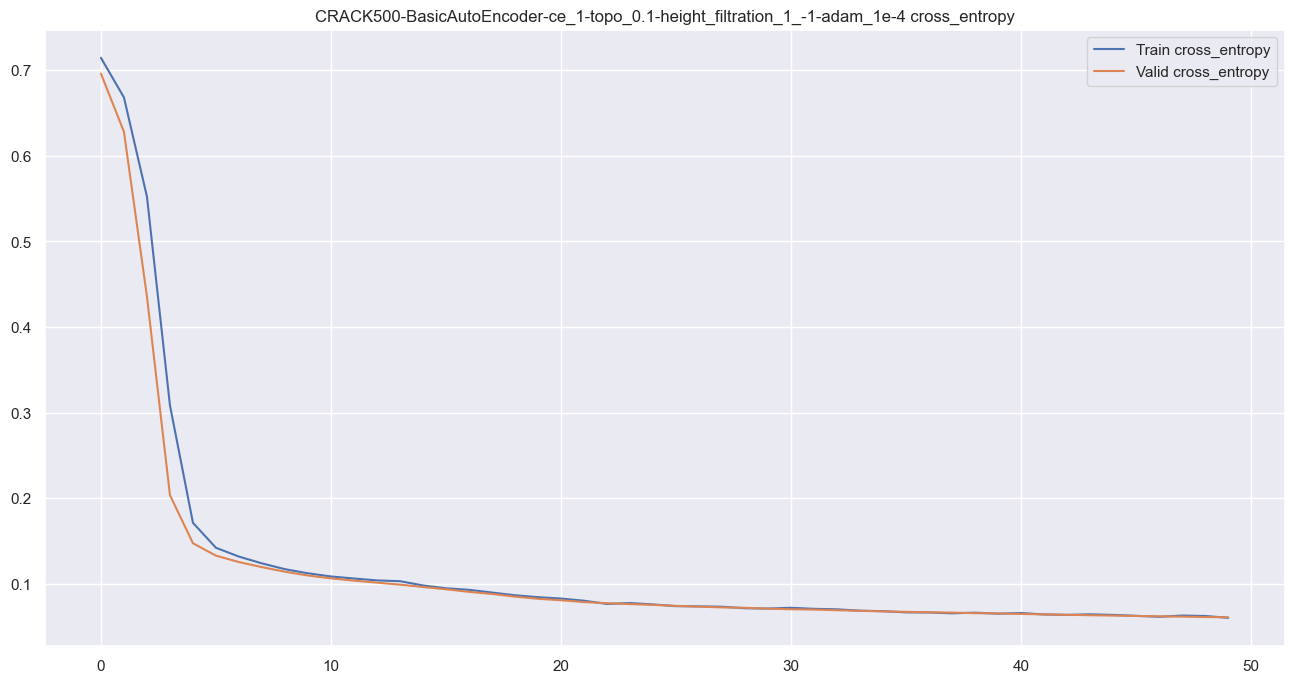

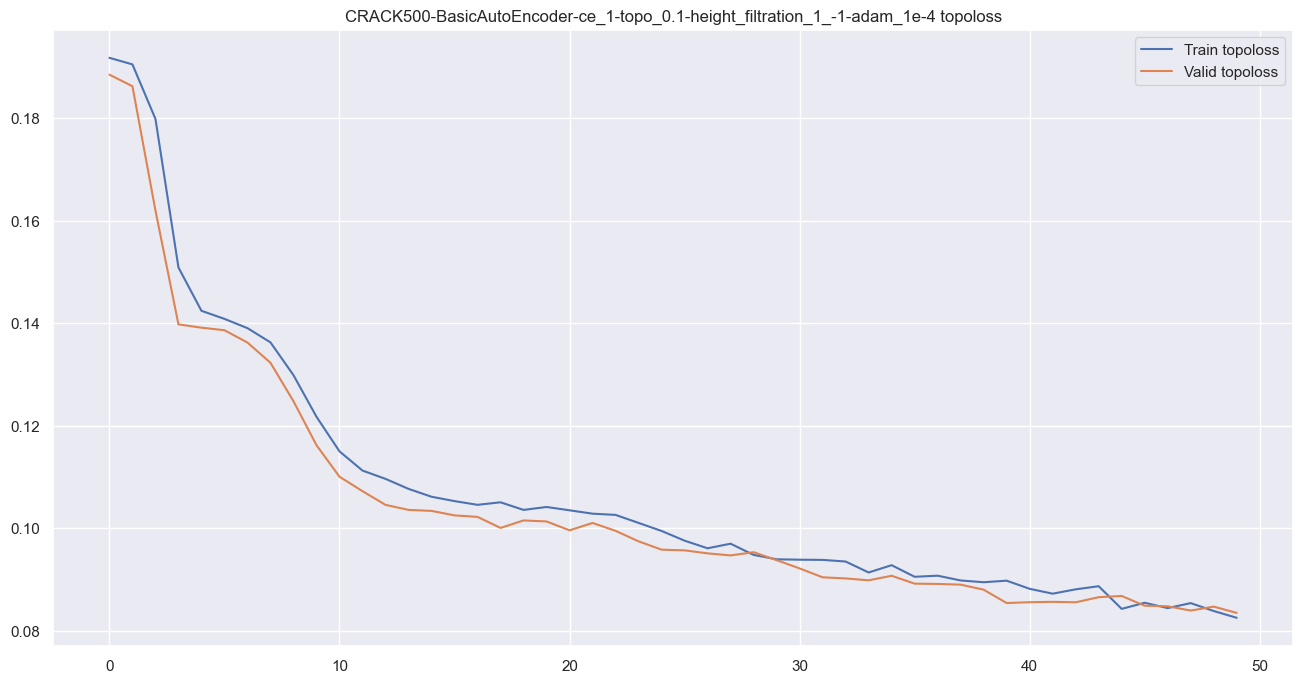

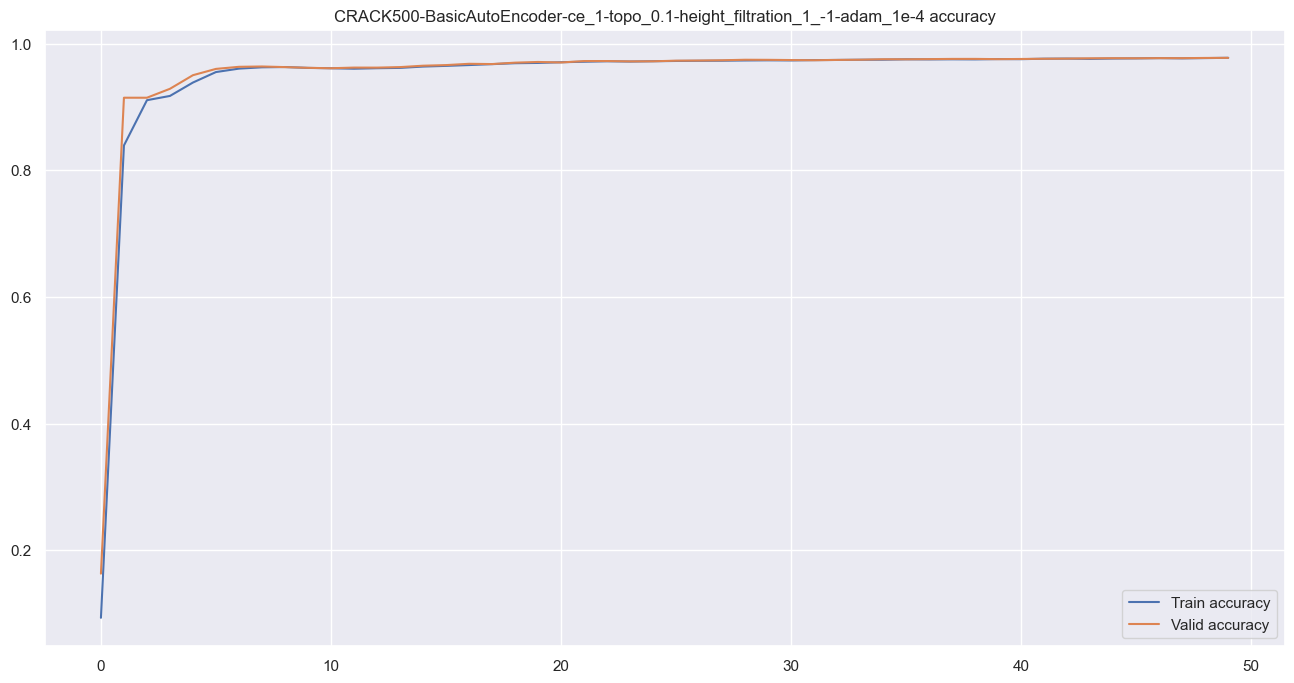

Epoch 49
 train loss: {'total': 0.06849736565120963, 'cross_entropy': 0.060244591578558535, 'topoloss': 0.082527740726511}, train metrics: {'accuracy': 0.9774542656048204}
 val loss: {'total': 0.06917831407247764, 'cross_entropy': 0.060829615614513374, 'topoloss': 0.08348698457964268}, val metrics: {'accuracy': 0.9773666405979591, 'betti_number_error': 0.8752260397830018, 'betti_number_error_0': 0.6636528028933092, 'betti_number_error_1': 0.2115732368896926}



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [16]:
config = dict(
    net="BasicAutoEncoder",
    dataset="CRACK500",
    lambda_ce=1,
    lambda_topo=0.1,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    optimizer="adam",
    filtration="height",
    scheduler="",
    comment=""
)

title = f"{config['dataset']}-{config['net']}-ce_1-topo_0.1-{config['filtration']}_filtration_1_-1-adam_1e-4"

set_random_seed(RANDOM_SEED)

net = BasicAutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
filtration = HeightFiltration((40, 40), np.array([1, -1]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with wandb.init(project="topological-autoencoder", name=title, config=config, settings=wandb.Settings(start_method="fork")):
    config = wandb.config
    fit(net, optimizer, config["epochs"], train_loader, val_loader, config["lambda_ce"], config["lambda_topo"],
        device, title=title, calc_train_betti=False, save_checkpoints=False, save_path="", log_wandb=True, filtration=filtration)

In [17]:
torch.save(net.state_dict(), "models/CRACK500/basic_bce_1_topo_1e-1_height_filtration_1_-1.pt")

100%|██████████| 18/18 [00:07<00:00,  2.26it/s]


{'accuracy': 0.9756261501931972, 'betti_number_error': 0.9296028880866426, 'betti_number_error_0': 0.6841155234657039, 'betti_number_error_1': 0.24548736462093862}


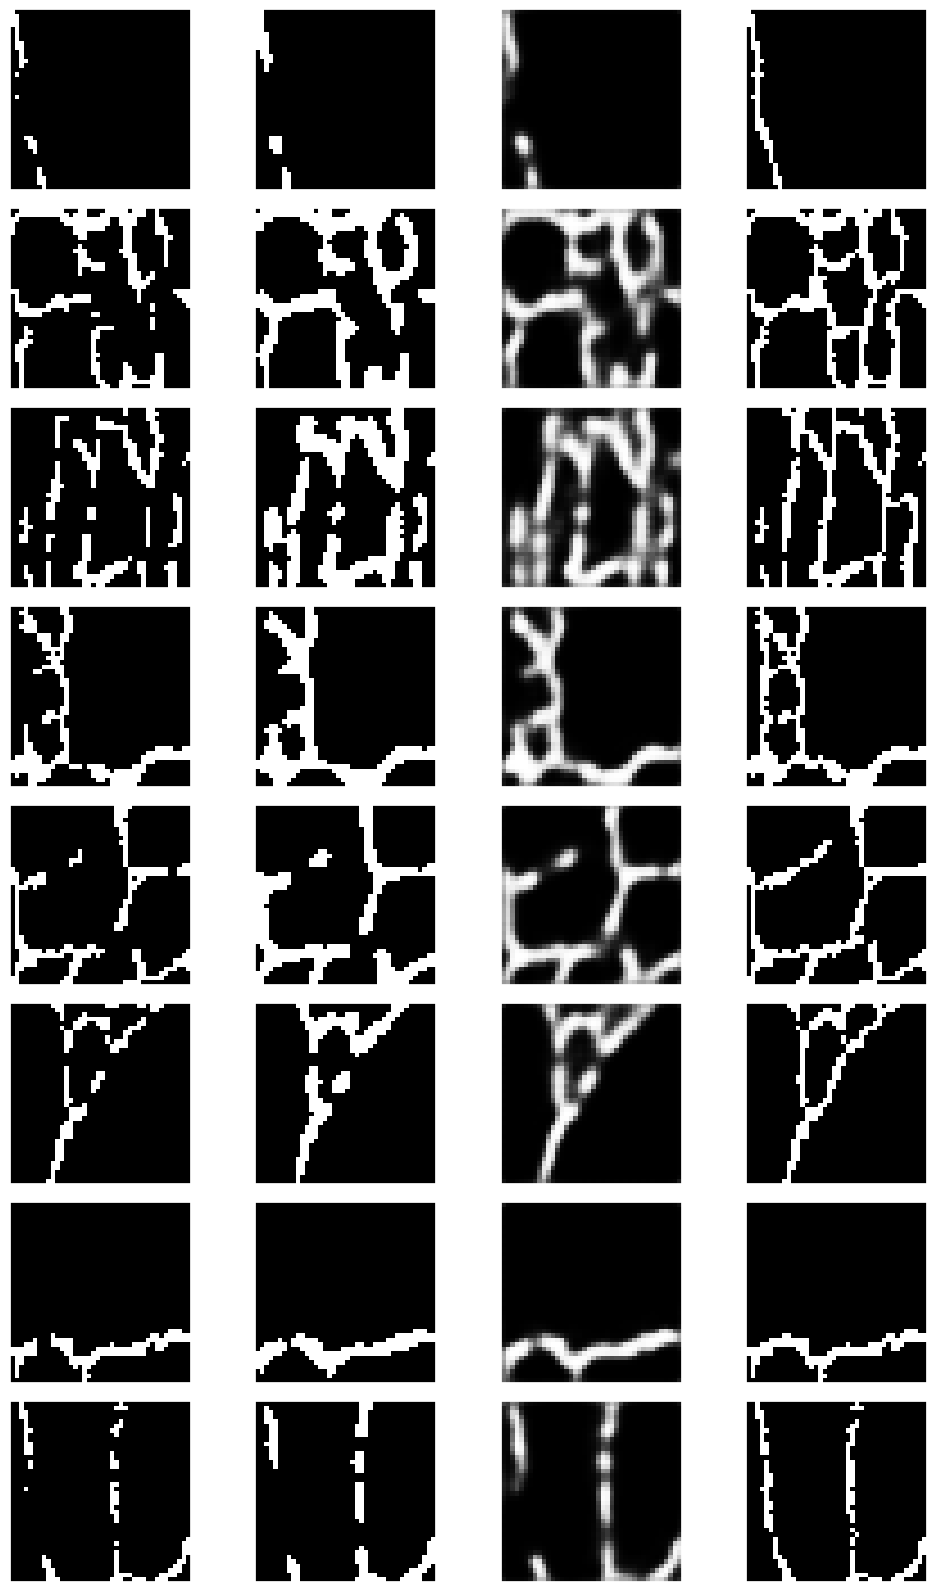

In [18]:
net = BasicAutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("models/CRACK500/basic_bce_1_topo_1e-1_height_filtration_1_-1.pt", map_location=device))

predictions, predictions_proba = evaluate_model(net, test_loader, device, start_ind=32)